# Fitting dNdEta Distribution $n_{BC}$ Depandence $\Delta \eta$ 

## 熵密度分布的形式

### $$
% \begin{equation}
\begin{split}
e(\mathbf{x}_{\perp},\eta)
&=f_L(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+f_R(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+ F_{L,R}(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \beta}
\end{split}
% \end{equation}
$$

### $$F_{L,R}(\eta)=\left\{\begin{array}{ll}1,&\mathrm{if} |\eta|\leq\eta_\mathrm{flat}\\\exp\biggl(-\frac{(|\eta|-\eta_\mathrm{flat})^2}{2\eta_\mathrm{gw}^2}\biggr),&\mathrm{if} |\eta|>\eta_\mathrm{flat}\end{array}\right.$$

### $$f_{L,R}(\eta) = \exp\left(-\frac{(|\eta| \pm \eta_0)^2}{2 \sigma^2}\right)$$

### 这里 $f_L(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为左侧向右侧运动的d核的纵向分布函数；  
### $f_R(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为右侧向左侧运动的Au核的纵向分布函数

# 一、定义计算熵的类，对每个事件添加一个$n_{BC}^{i}$依赖的快度损失
### $$\Delta \eta_{i}= \frac{n_{BC}^{i}-n_{BC}^{min}}{n_{BC}^{max}-n_{BC}^{min}} + 2$$

In [27]:
import os
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed

from scipy.integrate import trapezoid, simpson
import matplotlib.pyplot as plt
import mplhep as hep
# Setting the plot style
hep.style.use('ATLAS')

from tqdm import tqdm
import h5py


In [28]:
class EntropyAndDSdEtaCalculator:
    """
    A class to calculate the dS/dEta distribution for different events.

    Parameters:
        eta (float): Maximum pseudorapidity value.
        slices (int): Number of slices in the pseudorapidity range.
        y_0 (float): Initial rapidity.
        sigma (float): Gaussian width.
        eta_flat (float): Flat region extent in the plateau function.
        eta_gw (float): Gaussian fall-off width in the plateau function.
        P_factor (float): Plateau scaling factor.
        L_factor (float): Left Gaussian scaling factor.
        R_factor (float): Right Gaussian scaling factor.
        alpha (float): Exponent for the left and right entropy.
        beta (float): Exponent for the plateau entropy.
    """

    def __init__(self, eta=6.9, slices=121, y_0=3.78, sigma=0.6, 
                 eta_flat=1.5, eta_gw=1.3, P_factor=1, L_factor=1, R_factor=1, alpha=2.0, beta=0.5):
        self.eta = eta
        self.slices = slices
        self.y_0 = y_0
        self.sigma = sigma
        self.L_factor = L_factor
        self.R_factor = R_factor
        self.P_factor = P_factor
        self.alpha = alpha
        self.beta = beta
        self.eta_flat = eta_flat
        self.eta_gw = eta_gw

    def gaussian_function(self, x=0, center=0, width=1):
        """Compute a Gaussian function."""
        return np.exp(-((x - center)**2) / (2 * width**2))

    def plateau_function(self, eta=np.linspace(-6.9, 6.9, 121)):
        """Compute the plateau function based on pseudorapidity."""
        heta = np.ones_like(eta)
        fall_off = np.abs(eta) > self.eta_flat
        eta_fall = np.abs(eta[fall_off])
        heta[fall_off] = np.exp(-(eta_fall - self.eta_flat)**2 / (2.0 * self.eta_gw**2))
        return heta

    def save_longitudinal_dis_coef(self, y_loss):
        """
        Compute the longitudinal distribution coefficients for left, right, and plateau.

        Parameters:
            y_loss (float): Rapidity loss.

        Returns:
            coef_l, coef_r, coef_lr: Arrays of coefficients.
        """
        etas = np.linspace(-self.eta, self.eta, self.slices)
        coef_l = self.L_factor * self.gaussian_function(x=etas, center=self.y_0-y_loss, width=self.sigma)
        coef_r = self.R_factor * self.gaussian_function(x=etas, center=-(self.y_0-y_loss), width=self.sigma)
        coef_p = self.P_factor * self.plateau_function(eta=etas)
        return coef_l, coef_r, coef_p

    def calc_dSdEta_part(self, entropy_200x200, coef_list):
        """
        Compute part of the dS/dEta distribution for a specific component.

        Parameters:
            entropy_200x200 (ndarray): 2D entropy data.
            coef_list (ndarray): Coefficient list.

        Returns:
            dSdEta_half: Part of the dS/dEta distribution.
        """
        dtau0 = 0.6
        dx = 0.16
        dy = 0.16
        deta = 0.115
        dtau = dtau0 * dx * dy * deta
        dSdEta_half = np.zeros(len(coef_list))
        for i, coef in enumerate(coef_list):
            dSdEta_half[i] = np.sum(entropy_200x200) * dtau * coef
        return dSdEta_half

    def calc_dSdEta(self, entropy_200x200_L, entropy_200x200_R, y_loss):
        """
        Calculate the total dS/dEta distribution.

        Parameters:
            entropy_200x200_L (ndarray): Left entropy data.
            entropy_200x200_R (ndarray): Right entropy data.
            y_loss (float): Rapidity loss.

        Returns:
            dSdEta: Total dS/dEta distribution.
        """
        self.coef_L, self.coef_R, self.coef_P = self.save_longitudinal_dis_coef(y_loss)
        entropy2d_plat = entropy_200x200_L * entropy_200x200_R
        dSdEta_L = self.calc_dSdEta_part(entropy_200x200_L**self.alpha, self.coef_L)
        dSdEta_R = self.calc_dSdEta_part(entropy_200x200_R**self.alpha, self.coef_R)
        dSdEta_P = self.calc_dSdEta_part(entropy2d_plat**self.beta, self.coef_P)
        dSdEta = dSdEta_L + dSdEta_R + dSdEta_P
        return dSdEta
    
    def calc_3D_entropy_part(self, entropy_2D, coef_list):
        """
        Calculate entropy 3D for a specific part
        Multiply a 2D matrix with a 1D coefficient list to produce a 3D matrix.
        """
        entropy_3D = np.zeros((len(coef_list), *entropy_2D.shape))
        for i, coef in enumerate(coef_list):
            entropy_3D[i] = entropy_2D * coef
        
        return entropy_3D

    def calc_entropy3D(self, entropy_200x200_L, entropy_200x200_R, y_loss):
        """
        Calculate the sum of three 3D entropy distribution.
        """
        self.coef_L, self.coef_R, self.coef_P = self.save_longitudinal_dis_coef(y_loss)
        entropy2d_combined = entropy_200x200_L * entropy_200x200_R
        entropy_L = self.calc_3D_entropy_part(entropy_200x200_L ** self.alpha, self.coef_L)
        entropy_R = self.calc_3D_entropy_part(entropy_200x200_R ** self.alpha, self.coef_R)
        entropy_P = self.calc_3D_entropy_part(entropy2d_combined ** self.beta, self.coef_P)
        return entropy_L + entropy_R + entropy_P


### 对每个事件添加一个$n_{BC}^{i}$依赖的快度损失
### $$\Delta \eta_{i}=\frac{n_{BC}^{i}-n_{BC}^{min}}{n_{BC}^{max}-n_{BC}^{min}} + 2$$

### 计算单个事件的dSdEta分布

In [29]:
def calculate_event_dSdEta(event, input_dir, calculator, n_bc_min, n_bc_max):
    """
    Calculate dS/dEta for a specific event.

    Parameters:
        event (int): Event number.
        input_dir (str): Directory containing input files.
        calculator (dSdEtaCalculator): Calculator instance.
        n_bc_min (float): Minimum n_bc value.
        n_bc_max (float): Maximum n_bc value.

    Returns:
        dSdEta: Calculated dS/dEta distribution.
    """
    projectile_file = os.path.join(input_dir, f'entropy2d/projectile_entropy_event_{event}.dat')
    target_file = os.path.join(input_dir, f'entropy2d/target_entropy_event_{event}.dat')
    info_file = os.path.join(input_dir, f'information_of_Au_Au_collision/event_{event}/information_of_output.dat')

    if os.path.exists(projectile_file) and os.path.exists(target_file) and os.path.exists(info_file):
        sum_gaussian_L = np.loadtxt(projectile_file)
        sum_gaussian_R = np.loadtxt(target_file)

        n_bc = np.loadtxt(info_file, usecols=5)
        y_loss = 1 * (n_bc - n_bc_min) / (n_bc_max - n_bc_min) + 2.0     ####  使用1+2的形式

        dSdEta = calculator.calc_dSdEta(sum_gaussian_L, sum_gaussian_R, y_loss)
        return dSdEta, y_loss
    else:
        print(f"Warning: Files for event {event} not found.")
        return None
    

def get_n_bc_range(input_dir, event_range):
    """
    Get the range of n_bc values from input files.

    Parameters:
        input_dir (str): Directory containing input files.
        event_range (list): Range of event numbers.

    Returns:
        n_bc_min, n_bc_max: Minimum and maximum n_bc values.
    """
    n_bc_values = []
    for event in range(event_range[0], event_range[1]):
        info_file = os.path.join(input_dir, f'information_of_Au_Au_collision/event_{event}/information_of_output.dat')
        if os.path.exists(info_file):
            n_bc = np.loadtxt(info_file, usecols=5)
            n_bc_values.append(n_bc)
    return min(n_bc_values), max(n_bc_values)

# 根据实验上划分中心度的eta范围积分排序
def calculate_integral_dS(dsdeta,eta_range=[3.0,4.5], method="trapezoid"):
    """
    Calculate the integral of the dS/dEta distribution.

    Parameters:
        dsdeta (ndarray): dS/dEta distribution.
        etas (ndarray): Pseudorapidity values.
        method (str): Integration method ("trapezoid" or "simpson").

    Returns:
        integral_dS: Integrated value of dS/dEta.
    """
    etas = np.linspace(-6.9, 6.9, 121)
    mask1 = (etas > -eta_range[1]) & (etas < -eta_range[0])
    mask2 = (etas >  eta_range[0]) & (etas <  eta_range[1])
    if method == "trapezoid":
        integral_dS = trapezoid(dsdeta[mask1], etas[mask1]) + trapezoid(dsdeta[mask2], etas[mask2])
    elif method == "simpson":
        integral_dS = simpson(dsdeta[mask1], x=etas[mask1]) + simpson(dsdeta[mask2], x=etas[mask2])
    else:
        raise ValueError("Unsupported method: choose 'trapezoid' or 'simpson'")
    return integral_dS



### 并行化计算所有事件的dSdEta分布

In [31]:
def calc_dSdEta_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                    eta_flat=1.5, eta_gw=1.3, event_range=[0, 300],
                    L_factor=1.0, R_factor=1.0, P_factor=1, 
                    alpha=2.0, beta=0.5,
                    num_workers=4):
    """
    :return
    逐事件并行计算 dSdEta 将结果保存为数组。
    返回值包含每个事件的 dSdEta,快度损失 事件序号，以及积分值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param num_workers: 并行线程数量
    """
    
    calculator = EntropyAndDSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                   y_0=y_0, sigma=sigma, alpha=alpha, beta=beta,
                                   L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)

    input_dir = (f'/media/mengzhu/west16/Au_Au_work/')
    n_bc_min, n_bc_max = get_n_bc_range(input_dir, event_range)
    print(f"n_bc_min={n_bc_min},n_bc_max={n_bc_max}")

    # 保存 dSdEta、y_loss、event、ds_totall的结果
    dSdEta_event_all = []
    
    # 计算总事件数用于进度条
    total_events = event_range[1] - event_range[0]
    
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        # 使用字典保存future和事件的映射关系
        futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator, n_bc_min, n_bc_max): event
                   for event in range(event_range[0], event_range[1])}

        # 使用tqdm显示进度
        with tqdm(total=total_events, desc="Processing events") as pbar:
            for future in as_completed(futures):
                event = futures[future]
                try:
                    dSdEta_result, y_loss = future.result()
                    if dSdEta_result is not None:
                        ds_total = calculate_integral_dS(dsdeta=dSdEta_result, eta_range=[3.0,4.5], method="trapezoid")
                        dSdEta_event_all.append([dSdEta_result, y_loss, event, ds_total])
                    pbar.update(1)  # 每完成一个事件更新进度条
                except Exception as e:
                    print(f"\nError processing event {event}: {e}")
                    pbar.update(1)  # 即使出错也更新进度条

    # 转换为 NumPy 数组并排序
    dSdEta_event_array = np.array(dSdEta_event_all, dtype=object)
    sorted_indices = np.argsort(dSdEta_event_array[:, 3])[::-1]
    dSdEta_event_array = dSdEta_event_array[sorted_indices]
    
    return dSdEta_event_array

### 根据前面的计算，画出给定事件的范围的dSdEta分布，并按照积分值dS排序

In [32]:
def plot_dSdEta_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                    eta_flat=1.5, eta_gw=1.3, event_range=[0, 300],
                    L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                    num_workers=4, plot_dSdEta=True):
   
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果
    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta, num_workers=num_workers)
    
    if plot_dSdEta:
        plt.figure(figsize=(8, 6))
        eta_values = np.linspace(-eta, eta, slices)

        for dSdEta, y_loss, event, dS in dSdEta_event_array:
            plt.plot(eta_values, dSdEta, label=f'Event {event} (dS ={dS:.2f},dy={y_loss:.2f})', alpha=0.6)

        plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
        plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
        plt.title(r'$\rm dS/d\eta$ Distribution'
                  + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                  + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}', fontsize=20)
        plt.legend(fontsize=12, loc='upper right', ncol=1)
        plt.grid()

    return dSdEta_event_array


n_bc_min=2.0,n_bc_max=838.0


Processing events: 100%|██████████████████████| 10/10 [00:00<00:00, 23.38it/s]


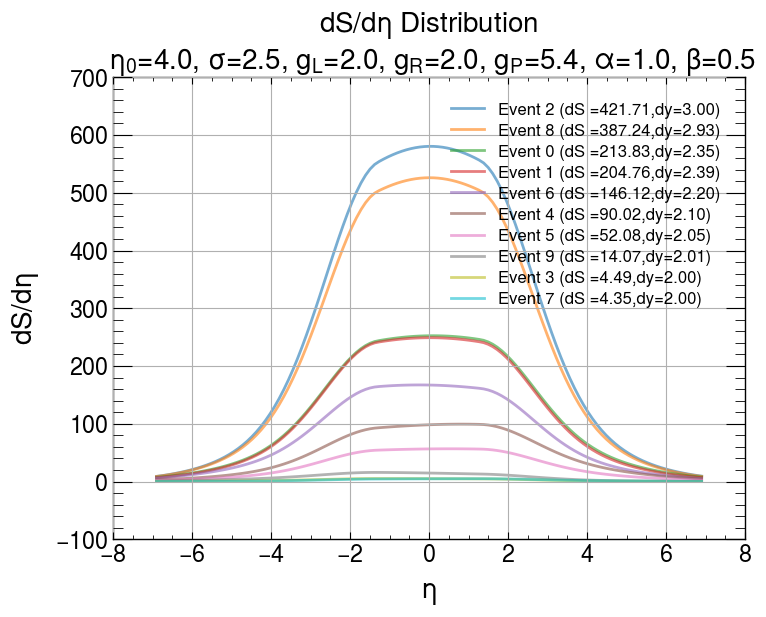

In [67]:
dSdEta_event_array =plot_dSdEta_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                    eta_flat=1.3, eta_gw=1.3, event_range=[0, 10],
                                    L_factor=2.0, R_factor=2.0, P_factor=5.4, alpha=1.0, beta=0.5,
                                    num_workers=4, plot_dSdEta=True)

In [34]:
dSdEta_event_array[:][:,-1]

array([421.7083057159363, 213.8306636578289, 204.76426371034142,
       90.02210506574863, 4.4899008732055625], dtype=object)

### 根据积分值排序后，划分中心度
### 给定 5w 个初始的事件，计算积分值 dS 并排序，排序结果的前10%即为0-10%中心度，以此类推
### 假设我们划分五个中心度[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
### 则每个中心度有1w个事件，再随机从这1w个事件中挑选1k作为碰撞的初始条件

In [35]:
def subplot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                                  eta_flat=1.5, eta_gw=1.3, event_range=[0, 300],
                                  L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                                  percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                                  num_workers=4, plot_dSdEta=True,save_fig=False):
    """
    逐事件并行计算 dSdEta，并按积分值排序后，按百分比绘制不同中心度区间的 dSdEta 分布图。

    :param eta: 纵向快度范围
    :param slices: 快度切片个数
    :param y_0: 高斯分布中心参数
    :param sigma: 高斯分布宽度参数
    :param eta_flat: 平坦区域范围参数
    :param eta_gw: 平坦区域衰减宽度参数
    :param event_range: 要处理的事件范围
    :param L_factor, R_factor, P_factor: 理论模型参数
    :param alpha, beta: 指数参数
    :param percentiles: 百分比区间列表
    :param num_workers: 并行线程数量
    :param plot_dSdEta: 是否绘制图像

    :return: 按中心度排序的事件数据数组 (dSdEta, event_index, integral_value)
    """
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果
    
    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta, num_workers=num_workers)


    if plot_dSdEta:
        # 绘制不同中心度区间的图像
        eta_values = np.linspace(-eta, eta, slices)
        total_events = len(dSdEta_event_array)

        # 创建 2x3 的子图布局
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        axes = axes.flatten()

        for idx, (start, end) in enumerate(percentiles):
            start_idx = int(total_events * start / 100)
            end_idx = int(total_events * end / 100)

            # 获取当前区间的所有事件的 dSdEta
            for i in range(start_idx, end_idx):
                dSdEta = dSdEta_event_array[i, 0]
                axes[idx].plot(eta_values, dSdEta, alpha=0.6)

            # 添加图例
            axes[idx].plot([], [], linestyle=' ', label=f'{start}-{end}%')
            axes[idx].legend(loc='upper right', fontsize=20)
            axes[idx].set_xlabel(r'$\rm \eta$', fontsize=20,ha='center')
            axes[idx].set_ylabel(r'$\rm dS/d\eta}$', fontsize=20,ha='center')
            axes[idx].set_xlim(-eta, eta)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].set_xlim(-8,8)  # 设置统一纵轴范围
            axes[idx].set_ylim(0,800)  # 设置统一纵轴范围
            axes[idx].grid(True,alpha=0.3)

        # 隐藏多余子图
        for ax in axes[len(percentiles):]:
            ax.axis('off')

#         plt.suptitle(r'Distribution of $\rm dS/d\eta$ by Centrality'
#                    + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
#                    + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}',fontsize=25)
        plt.suptitle(r'Distribution of $\rm dS/d\eta$ by Centrality',fontsize=25)
        plt.tight_layout()
        if save_fig:
            plt.savefig(f'fig/dSdeta_ebe_P_factor_{str(P_factor).replace(".", "p")}_beta_{str(beta).replace(".", "p")}_5000.pdf', bbox_inches='tight',dpi=100)
        plt.show()

#     return dSdEta_event_array


### 使用参数(d)

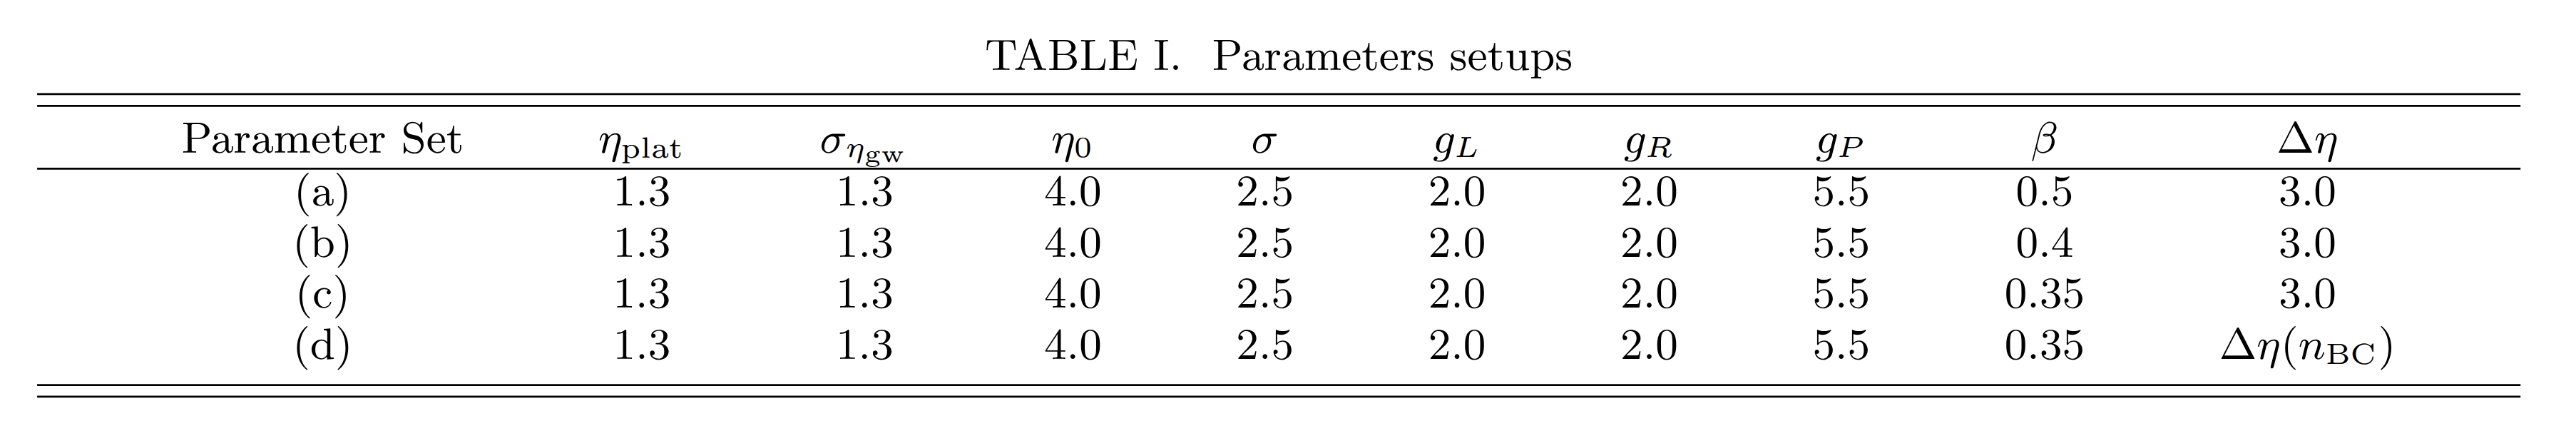

n_bc_min=1.0,n_bc_max=1297.0


Processing events: 100%|██████████████████| 5000/5000 [02:27<00:00, 33.93it/s]


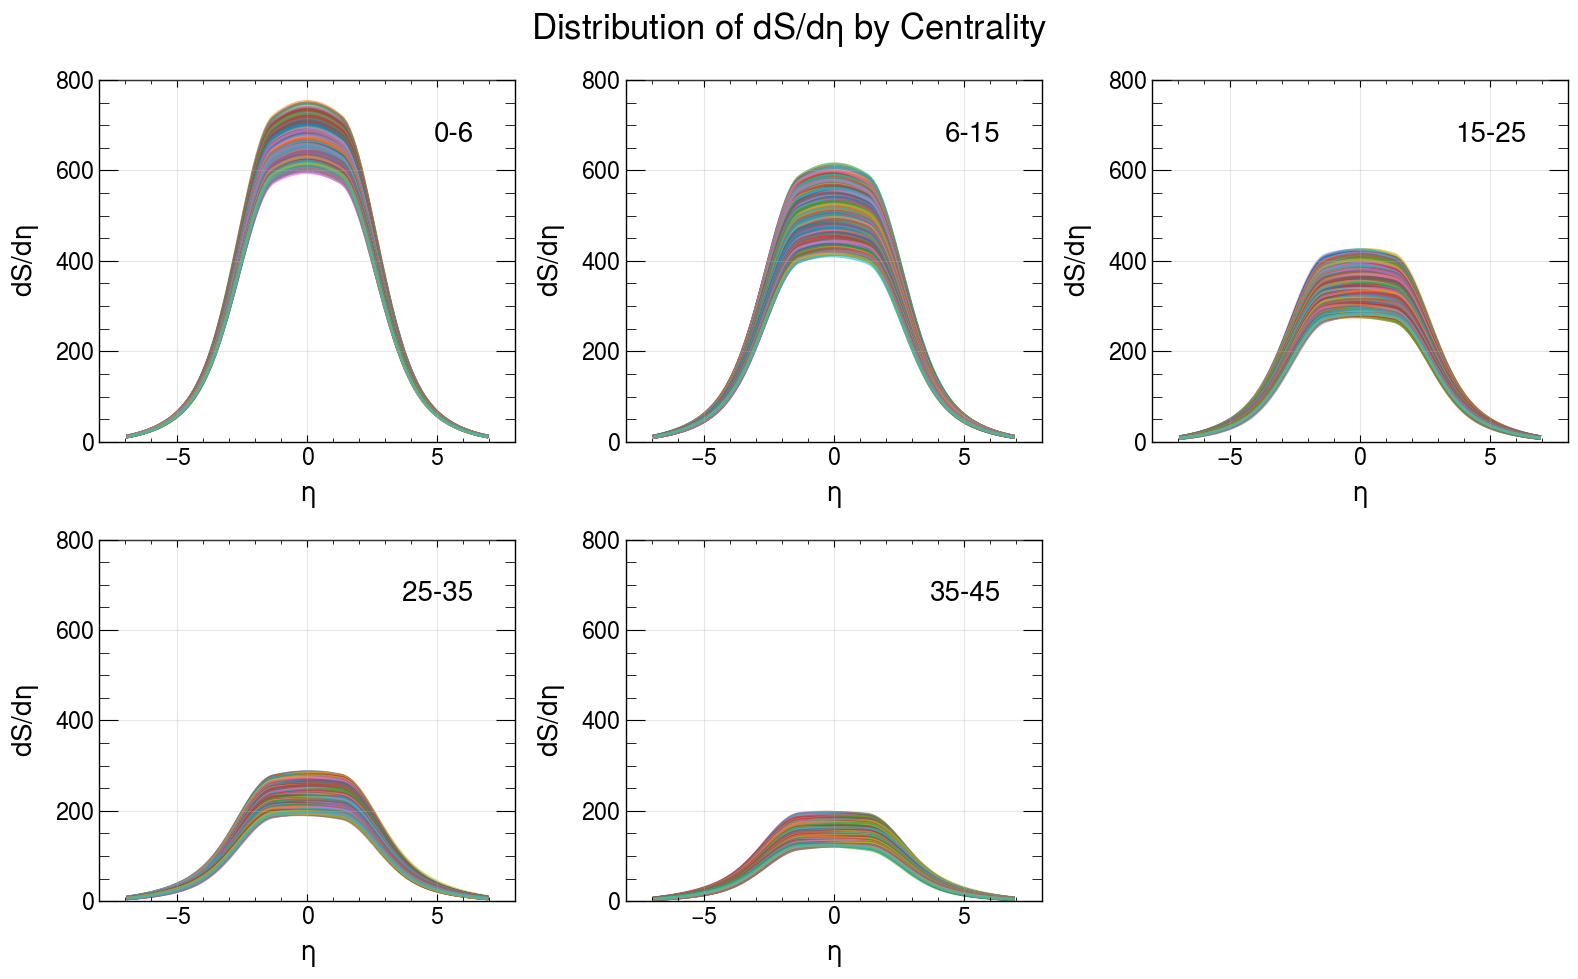

In [36]:
subplot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=4, sigma=2.5,
                              eta_flat=1.3, eta_gw=1.3, event_range=[0, 5000],
                              L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                              percentiles=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],
                              num_workers=8, plot_dSdEta=True,save_fig=False)

### 计算每个中心度的平均的dSdEta分布

In [37]:
def plot_avg_dSdEta_centrality(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                               eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                               L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                               percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                               num_workers=4):
    """
    逐事件并行计算 dSdEta 和积分结果，将结果保存为数组，并计算每个中心度区间的平均 dSdEta。

    返回值包含每个事件的 dSdEta, 事件序号，以及积分值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param num_workers: 并行线程数量
    :param percentiles: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    """
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果
    
    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta,num_workers=num_workers)

    # 绘制不同中心度区间的平均分布图像
    eta_values = np.linspace(-eta, eta, slices)
    total_events = len(dSdEta_event_array)

    average_distributions = []  # 用于保存每个中心度区间的平均分布

    for start, end in percentiles:
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)

        # 获取当前区间的所有事件的 dSdEta
        dSdEta_subset = dSdEta_event_array[start_idx:end_idx, 0]

        # 计算平均分布
        avg_dSdEta = np.mean(np.vstack(dSdEta_subset), axis=0)
        average_distributions.append((avg_dSdEta, f'{start}-{end}%'))

    # 绘图
    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue', 'green', 'orange', 'black']

    for idx, (avg_dist, label) in enumerate(average_distributions):
        plt.plot(eta_values, avg_dist, color=colors[idx % len(colors)], label=label, alpha=0.8)

    plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
    plt.ylabel(r'$\rm dS/d\eta}$', fontsize=20, ha='center')
    plt.title(r'Averaged $\rm dS/d\eta$ Distribution by Centrality'
              + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
              + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}', fontsize=25)
    plt.legend(fontsize=20, loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



n_bc_min=1.0,n_bc_max=1297.0


Processing events: 100%|███████████████████| 5000/5000 [00:05<00:00, 911.03it/s]


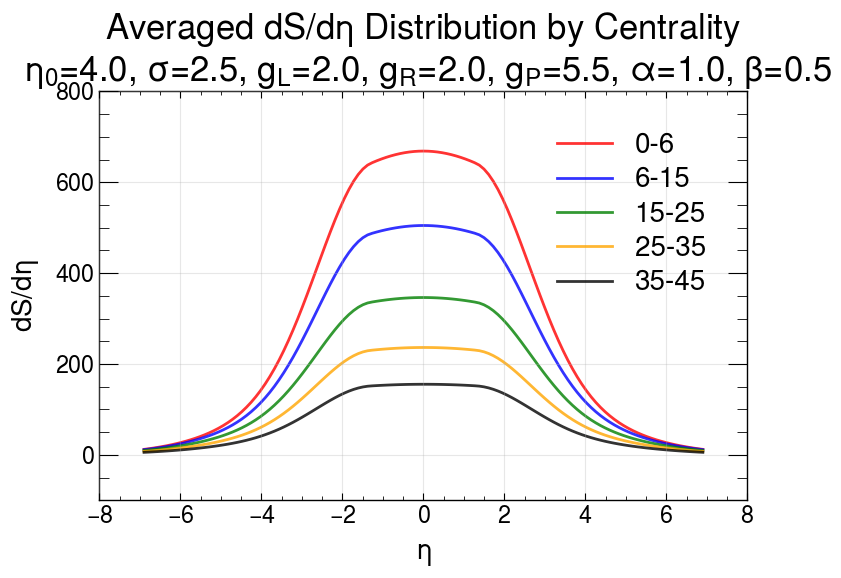

In [12]:
plot_avg_dSdEta_centrality(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                           eta_flat=1.3, eta_gw=1.3, event_range=[0, 5000],
                           L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                           percentiles=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],
                           num_workers=8)

n_bc_min=1.0,n_bc_max=1297.0


Processing events: 100%|████████████████████| 5000/5000 [02:58<00:00, 27.95it/s]


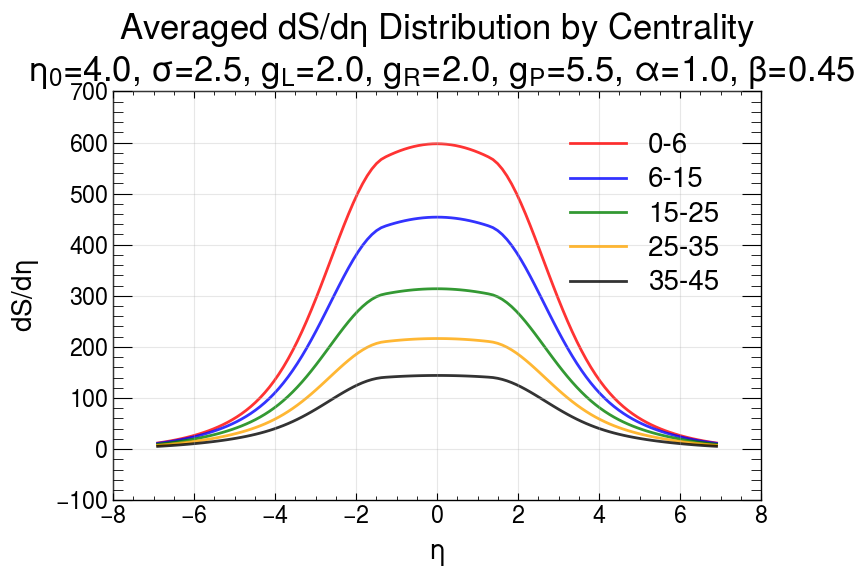

In [42]:
plot_avg_dSdEta_centrality(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                           eta_flat=1.3, eta_gw=1.3, event_range=[0, 5000],
                           L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.45,
                           percentiles=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],
                           num_workers=8)

n_bc_min=1.0,n_bc_max=1297.0


Processing events: 100%|███████████████████| 5000/5000 [00:05<00:00, 879.62it/s]


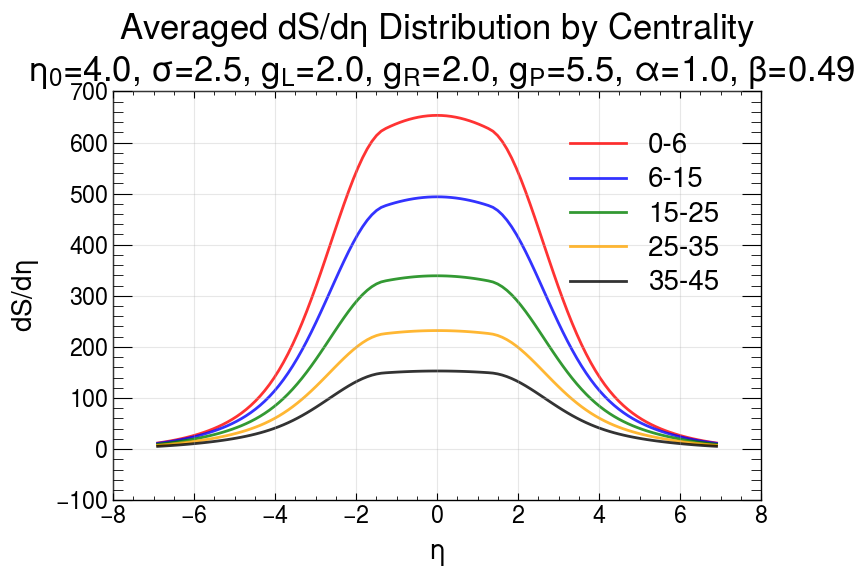

In [77]:
plot_avg_dSdEta_centrality(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                           eta_flat=1.3, eta_gw=1.3, event_range=[0, 5000],
                           L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.49,
                           percentiles=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],
                           num_workers=8)

# 计算用于流体的Entropy3D

### 计算每个中心度区间内的随机事件序号和对应的 y_loss 值

In [38]:
def calc_event_indices_random(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                              eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300], IC_events=1000,
                              L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                              cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                              num_workers=4):
    """
    并行计算 dSdEta distribution 和相应 eta 区间的 dSdEta 对 eta 积分结果，
    并返回指定中心度区间内随机挑选的事件序号和 y_loss 值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向 gaussian distribution 能量沉积的参数
    :param eta_flat, eta_gw: 参数影响 plateau 平坦区域和高斯宽度
    :param y_loss: 损失参数，d核核子碰撞后可能会有纵向停滞
    :param L_factor, R_factor, P_factor, alpha=1, beta=0.5: 理论参数
    :param num_workers: 并行线程数量
    :param cents: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    :event_range: 总的初始条件范围
    :IC_events: 随机挑选的初始条件数量
    :return: 字典，包含每个中心度区间内的随机事件序号和对应的 y_loss 值。
    """
    dSdEta_event_array = calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                         eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                         L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                         alpha=alpha, beta=beta, num_workers=num_workers)

    # 提取每个中心度区间的事件序号和 y_loss 值
    total_events = len(dSdEta_event_array)
    centrality_results = {}

    for start, end in cents:
        print(f"Computing event numbers for centrality range {start}-{end}!")
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)
        selected_data = dSdEta_event_array[start_idx:end_idx, 1:3]  # 提取 y_loss 和事件序号

        # 随机选择事件
        if len(selected_data) >= IC_events:
            random_samples = np.random.choice(len(selected_data), size=IC_events, replace=False)
            selected_samples = selected_data[random_samples]
        else:
            print(f"区间 {start}-{end} 的事件数量不足 {IC_events} 个！")
            selected_samples = selected_data

        # 保存随机挑选的事件信息
        centrality_results[f'{start}_{end}'] = {
            'y_loss': selected_samples[:, 0].tolist(),
            'event_indices': selected_samples[:, 1].astype(int).tolist()
        }

    return centrality_results


In [39]:
event_indices= calc_event_indices_random(
                    eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                    eta_flat=1.3, eta_gw=1.3, event_range=[0, 50],IC_events = 2,
                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                    cents=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],
                    num_workers=8
)

n_bc_min=1.0,n_bc_max=980.0


Processing events: 100%|█████████████████████| 50/50 [00:00<00:00, 755.05it/s]

Computing event numbers for centrality range 0-6!
Computing event numbers for centrality range 6-15!
Computing event numbers for centrality range 15-25!
Computing event numbers for centrality range 25-35!
Computing event numbers for centrality range 35-45!


In [40]:
event_indices

{'0_6': {'y_loss': [2.958120531154239, 3.0], 'event_indices': [42, 31]},
 '6_15': {'y_loss': [2.6149131767109295, 2.791624106230848],
  'event_indices': [11, 8]},
 '15_25': {'y_loss': [2.3748723186925433, 2.560776302349336],
  'event_indices': [34, 22]},
 '25_35': {'y_loss': [2.297242083758938, 2.257405515832482],
  'event_indices': [0, 40]},
 '35_45': {'y_loss': [2.097037793667007, 2.133810010214505],
  'event_indices': [18, 38]}}

In [41]:
for centrality, data in event_indices.items():
    print(centrality)
    print(data["y_loss"])
    print(data["event_indices"])    

0_6
[2.958120531154239, 3.0]
[42, 31]
6_15
[2.6149131767109295, 2.791624106230848]
[11, 8]
15_25
[2.3748723186925433, 2.560776302349336]
[34, 22]
25_35
[2.297242083758938, 2.257405515832482]
[0, 40]
35_45
[2.097037793667007, 2.133810010214505]
[18, 38]


### 计算逐事件的entropy3d，事件数100个，每个事件的entropy3d文件格式为121*200*200

In [42]:
def calc_save_entropy3D(eta=6.9, slices=121, event_range=[0, 100], IC_events=10,
                        y_0=3.78, sigma=0.6, eta_flat=1.5, eta_gw=1.3,
                        P_factor=1, L_factor=1.0, R_factor=1.0, alpha=0.5, beta=2.0,  
                        cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)], 
                        save_entropy3d=False, num_workers=4):
    """
    保存不同中心度的 entropy3D 文件，从 event_0 开始编号。
    :event_range: 总事件数，事件范围10000*5
    :IC_events: 每个中心度挑选出来的事件数，作为初始条件
    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma, eta_flat, eta_gw, P_factor, L_factor, R_factor, alpha, beta: 理论参数
    :param save_entropy3d: 是否保存文件
    :param HWF_or_DWF: 指定 HWF 或 DWF
    :param cents: 中心度划分
    :param num_workers: 并行线程数量
    """
    # 按中心度区间保存 entropy3D 文件
    if save_entropy3d:
        # 实例化计算器
        calculator = EntropyAndDSdEtaCalculator(eta=eta, slices=slices, 
                                                eta_flat=eta_flat, eta_gw=eta_gw, 
                                                y_0=y_0, sigma=sigma, 
                                                P_factor=P_factor, L_factor=L_factor, R_factor=R_factor, 
                                                alpha=alpha, beta=beta)

        # 计算中心度区间的事件序号
        print("centrality_event_indices is computing!")
        centrality_event_indices = calc_event_indices_random(
            eta=eta, slices=slices, y_0=y_0, sigma=sigma, 
            eta_flat=eta_flat, eta_gw=eta_gw,
            L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
            alpha=alpha, beta=beta, cents=cents, 
            num_workers=num_workers, event_range=event_range, IC_events=IC_events
        )
        print("centrality_event_indices has computed!")

        # 准备entropy3D输出路径参数
        base_output_dir = (f'/media/mengzhu/west16/Au_Au_work/'
                           f'entropy3d/entropy3d_ebe_n_BC/plat_{str(eta_flat).replace(".", "p")}_gw_{str(eta_gw).replace(".", "p")}/')

        # 遍历中心度计算
        for centrality, centrality_data in tqdm(centrality_event_indices.items()):
            event_indices = centrality_data['event_indices']
            y_losses = centrality_data['y_loss']

            # 创建中心度子目录
            centrality_dir = os.path.join(base_output_dir, f'entropy_cent_{centrality}')
            os.makedirs(centrality_dir, exist_ok=True)

            # 构造输出文件名
            filename = (f"entropy3D_y0_{str(y_0).replace('.', 'p')}_sigma_{str(sigma).replace('.', 'p')}_"
                        f"L_factor_{str(L_factor).replace('.', 'p')}_R_factor_{str(R_factor).replace('.', 'p')}_"
                        f"P_factor_{str(P_factor).replace('.', 'p')}_alpha_{str(alpha).replace('.', 'p')}_"
                        f"beta_{str(beta).replace('.', 'p')}_new_eta_range.h5")
            output_path = os.path.join(centrality_dir, filename)

            # 检查文件是否已经存在，避免覆盖
            if os.path.exists(output_path):
                print(f"File {output_path} already exists, skipping...")
                continue  # 跳过当前中心度的保存

            # 打印信息确认所计算的内容
            event_indices_len = len(event_indices)
            y_losses_len = len(y_losses)
            
            print(f"Centrality range {centrality} is computing! \n"
                  f"Included events with lens {event_indices_len}: \n {event_indices} \n"
                  f"Included y_loss with lens {y_losses_len}: \n {y_losses} \n")

            # 新建并打开 HDF5 文件
            with h5py.File(output_path, 'w') as f:  # 使用写模式 'w'
                for i, (event, y_loss) in tqdm(enumerate(zip(event_indices, y_losses))):
                    # entropy2d 输入路径
                    input_dir = (f'/media/mengzhu/west16/Au_Au_work/entropy2d/')
                    input_filename_L = f"projectile_entropy_event_{event}.dat"
                    input_filename_R = f"target_entropy_event_{event}.dat"
                    input_path_L = os.path.join(input_dir, input_filename_L)
                    input_path_R = os.path.join(input_dir, input_filename_R)

                    # 读取输入文件
                    gaussian_L = np.loadtxt(input_path_L)
                    gaussian_R = np.loadtxt(input_path_R)

                    # 计算 entropy3D
                    entropy3D = calculator.calc_entropy3D(gaussian_L, gaussian_R, y_loss)

                    # 保存到文件，从 event_0 开始编号
                    dataset_name = f'event_{i}'  # 从 0 开始编号
                    f.create_dataset(dataset_name, data=entropy3D)
                    print(f"event_{event} renamed {dataset_name} added to {centrality_dir}.")
            print(f"entropy3D for {centrality} saved at {centrality_dir}\n")

    else:
        print("Please keep 'save_entropy3d=True'")


In [43]:
calc_save_entropy3D(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                    eta_flat=1.3, eta_gw=1.3,event_range=[0, 50000],IC_events=1000,
                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.47,
                    cents=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],
                    num_workers=16,save_entropy3d=True)

centrality_event_indices is computing!
n_bc_min=1.0,n_bc_max=1361.0


Processing events: 100%|████████████████| 50000/50000 [19:28<00:00, 42.81it/s]


Computing event numbers for centrality range 0-6!
Computing event numbers for centrality range 6-15!
Computing event numbers for centrality range 15-25!
Computing event numbers for centrality range 25-35!
Computing event numbers for centrality range 35-45!
centrality_event_indices has computed!


  0%|                                                   | 0/5 [00:00<?, ?it/s]

Centrality range 0_6 is computing! 
Included events with lens 1000: 
 [5841, 27416, 15136, 4989, 40019, 774, 46665, 18993, 35076, 41937, 20385, 49527, 5706, 48747, 7479, 12798, 3883, 31786, 48328, 35465, 35505, 49905, 12911, 20728, 20765, 11005, 23469, 29995, 49208, 49389, 4889, 39517, 32657, 29437, 23324, 47516, 30110, 14795, 19459, 288, 2413, 48741, 20443, 18597, 32898, 23051, 44787, 46231, 27991, 11707, 2823, 18158, 22849, 2228, 37000, 21028, 49336, 15827, 1983, 28752, 6102, 38922, 13096, 14841, 15813, 21200, 15624, 17239, 39708, 46034, 12951, 24685, 21885, 28452, 23223, 5614, 18466, 25107, 10458, 36836, 855, 47723, 3053, 13662, 4985, 12074, 24767, 37583, 1005, 32083, 5358, 11163, 21813, 41543, 38241, 15917, 9067, 10232, 38673, 48036, 32089, 4787, 40977, 14357, 41200, 8907, 43559, 22059, 19396, 21194, 45706, 38647, 37774, 11842, 37575, 42600, 40042, 8857, 2164, 2556, 41985, 11431, 8643, 7307, 15304, 46127, 46626, 43342, 10460, 46601, 21423, 32074, 37907, 17570, 28679, 35445, 43993, 


0it [00:00, ?it/s]
1it [00:00,  8.53it/s]

event_5841 renamed event_0 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27416 renamed event_1 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



3it [00:00,  8.39it/s]

event_15136 renamed event_2 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



4it [00:00,  8.60it/s]

event_4989 renamed event_3 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40019 renamed event_4 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



6it [00:00, 10.03it/s]

event_774 renamed event_5 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



8it [00:00, 10.85it/s]

event_46665 renamed event_6 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_18993 renamed event_7 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35076 renamed event_8 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



10it [00:00, 12.75it/s]

event_41937 renamed event_9 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20385 renamed event_10 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



12it [00:01, 11.43it/s]
14it [00:01, 11.73it/s]

event_49527 renamed event_11 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5706 renamed event_12 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48747 renamed event_13 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



16it [00:01, 10.82it/s]

event_7479 renamed event_14 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12798 renamed event_15 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



18it [00:01, 10.62it/s]

event_3883 renamed event_16 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31786 renamed event_17 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48328 renamed event_18 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



20it [00:01, 12.30it/s]
22it [00:01, 12.51it/s]

event_35465 renamed event_19 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35505 renamed event_20 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49905 renamed event_21 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



24it [00:02, 12.94it/s]

event_12911 renamed event_22 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20728 renamed event_23 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20765 renamed event_24 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



26it [00:02, 12.79it/s]
28it [00:02, 12.95it/s]

event_11005 renamed event_25 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23469 renamed event_26 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29995 renamed event_27 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



30it [00:02, 13.39it/s]

event_49208 renamed event_28 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49389 renamed event_29 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_4889 renamed event_30 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



32it [00:02, 13.50it/s]
34it [00:02, 13.34it/s]

event_39517 renamed event_31 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32657 renamed event_32 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29437 renamed event_33 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



36it [00:02, 14.03it/s]

event_23324 renamed event_34 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47516 renamed event_35 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_30110 renamed event_36 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



38it [00:03, 13.76it/s]

event_14795 renamed event_37 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19459 renamed event_38 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



40it [00:03, 12.15it/s]
42it [00:03, 12.37it/s]

event_288 renamed event_39 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2413 renamed event_40 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48741 renamed event_41 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



44it [00:03, 12.33it/s]

event_20443 renamed event_42 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_18597 renamed event_43 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32898 renamed event_44 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



46it [00:03, 12.48it/s]
48it [00:03, 13.77it/s]

event_23051 renamed event_45 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44787 renamed event_46 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46231 renamed event_47 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27991 renamed event_48 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



50it [00:04, 12.98it/s]
52it [00:04, 12.42it/s]

event_11707 renamed event_49 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2823 renamed event_50 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_18158 renamed event_51 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



54it [00:04, 12.38it/s]

event_22849 renamed event_52 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2228 renamed event_53 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37000 renamed event_54 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



56it [00:04, 13.06it/s]
58it [00:04, 13.93it/s]

event_21028 renamed event_55 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49336 renamed event_56 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15827 renamed event_57 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



60it [00:04, 12.60it/s]

event_1983 renamed event_58 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_28752 renamed event_59 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6102 renamed event_60 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



62it [00:05, 12.85it/s]
64it [00:05, 13.19it/s]

event_38922 renamed event_61 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13096 renamed event_62 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14841 renamed event_63 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



66it [00:05, 12.90it/s]

event_15813 renamed event_64 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21200 renamed event_65 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15624 renamed event_66 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



68it [00:05, 13.30it/s]
70it [00:05, 14.29it/s]

event_17239 renamed event_67 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_39708 renamed event_68 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46034 renamed event_69 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



72it [00:05, 13.57it/s]

event_12951 renamed event_70 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24685 renamed event_71 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21885 renamed event_72 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



74it [00:05, 13.24it/s]
76it [00:06, 12.50it/s]

event_28452 renamed event_73 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23223 renamed event_74 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5614 renamed event_75 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



78it [00:06, 12.63it/s]

event_18466 renamed event_76 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25107 renamed event_77 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10458 renamed event_78 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



80it [00:06, 12.76it/s]
82it [00:06, 12.78it/s]

event_36836 renamed event_79 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_855 renamed event_80 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47723 renamed event_81 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



84it [00:06, 12.84it/s]

event_3053 renamed event_82 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13662 renamed event_83 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_4985 renamed event_84 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



86it [00:06, 12.50it/s]
88it [00:07, 12.03it/s]

event_12074 renamed event_85 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24767 renamed event_86 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37583 renamed event_87 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



90it [00:07, 10.90it/s]

event_1005 renamed event_88 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32083 renamed event_89 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



92it [00:07, 10.55it/s]

event_5358 renamed event_90 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11163 renamed event_91 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21813 renamed event_92 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



94it [00:07, 11.57it/s]
96it [00:07, 12.22it/s]

event_41543 renamed event_93 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_38241 renamed event_94 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15917 renamed event_95 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9067 renamed event_96 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



98it [00:08,  8.75it/s]
100it [00:08, 10.39it/s]

event_10232 renamed event_97 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_38673 renamed event_98 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48036 renamed event_99 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32089 renamed event_100 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



102it [00:12,  1.57it/s]

event_4787 renamed event_101 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40977 renamed event_102 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



104it [00:14,  1.28it/s]

event_14357 renamed event_103 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41200 renamed event_104 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



106it [00:16,  1.19it/s]

event_8907 renamed event_105 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43559 renamed event_106 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



108it [00:18,  1.02it/s]

event_22059 renamed event_107 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



109it [00:20,  1.14s/it]

event_19396 renamed event_108 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



110it [00:23,  1.44s/it]
111it [00:23,  1.16s/it]

event_21194 renamed event_109 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45706 renamed event_110 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



113it [00:23,  1.37it/s]

event_38647 renamed event_111 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37774 renamed event_112 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



114it [00:28,  1.66s/it]
116it [00:28,  1.05s/it]

event_11842 renamed event_113 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37575 renamed event_114 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_42600 renamed event_115 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40042 renamed event_116 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



118it [00:32,  1.41s/it]

event_8857 renamed event_117 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



119it [00:34,  1.40s/it]

event_2164 renamed event_118 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



120it [00:38,  1.93s/it]

event_2556 renamed event_119 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41985 renamed event_120 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



122it [00:39,  1.54s/it]

event_11431 renamed event_121 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



123it [00:45,  2.44s/it]

event_8643 renamed event_122 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



124it [00:48,  2.52s/it]

event_7307 renamed event_123 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



125it [00:52,  2.99s/it]
127it [00:52,  1.76s/it]

event_15304 renamed event_124 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46127 renamed event_125 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46626 renamed event_126 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43342 renamed event_127 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



129it [00:52,  1.13s/it]
131it [00:53,  1.30it/s]

event_10460 renamed event_128 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46601 renamed event_129 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21423 renamed event_130 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



132it [00:53,  1.58it/s]

event_32074 renamed event_131 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37907 renamed event_132 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



134it [00:53,  2.26it/s]
135it [00:53,  2.63it/s]

event_17570 renamed event_133 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_28679 renamed event_134 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



137it [00:53,  3.78it/s]
139it [00:53,  5.18it/s]

event_35445 renamed event_135 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43993 renamed event_136 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45799 renamed event_137 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46679 renamed event_138 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



141it [00:54,  5.48it/s]

event_5548 renamed event_139 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_26032 renamed event_140 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48318 renamed event_141 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



143it [00:54,  6.63it/s]
145it [00:54,  7.71it/s]

event_6119 renamed event_142 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27621 renamed event_143 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15694 renamed event_144 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



147it [00:54,  8.75it/s]

event_41850 renamed event_145 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6850 renamed event_146 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40308 renamed event_147 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



149it [00:54,  9.37it/s]
151it [00:55, 10.22it/s]

event_15198 renamed event_148 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32303 renamed event_149 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_38737 renamed event_150 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



153it [00:55, 10.91it/s]

event_27933 renamed event_151 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40574 renamed event_152 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



155it [00:55,  7.40it/s]

event_11310 renamed event_153 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12766 renamed event_154 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



157it [00:55,  8.26it/s]
159it [00:55,  9.77it/s]

event_7169 renamed event_155 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47364 renamed event_156 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47520 renamed event_157 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41160 renamed event_158 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



161it [00:56,  9.41it/s]

event_31788 renamed event_159 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_8361 renamed event_160 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40057 renamed event_161 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



163it [00:56, 10.95it/s]
165it [00:56, 11.05it/s]

event_42181 renamed event_162 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14101 renamed event_163 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14356 renamed event_164 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



167it [00:56,  9.92it/s]

event_9546 renamed event_165 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35977 renamed event_166 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48158 renamed event_167 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



169it [00:56, 10.33it/s]
171it [00:57, 10.32it/s]

event_16332 renamed event_168 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32086 renamed event_169 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29844 renamed event_170 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



173it [00:57,  9.30it/s]

event_4401 renamed event_171 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37032 renamed event_172 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



174it [00:57,  7.66it/s]
175it [00:57,  8.01it/s]

event_4799 renamed event_173 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20761 renamed event_174 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35954 renamed event_175 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



177it [00:57,  9.37it/s]

event_47291 renamed event_176 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46769 renamed event_177 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



179it [00:58,  8.62it/s]
181it [00:58,  9.22it/s]

event_34813 renamed event_178 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41831 renamed event_179 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_8936 renamed event_180 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



182it [00:58,  8.99it/s]

event_21348 renamed event_181 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



183it [00:58,  7.54it/s]
184it [00:58,  7.89it/s]

event_4217 renamed event_182 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20175 renamed event_183 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40749 renamed event_184 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



186it [00:58,  9.01it/s]
188it [00:59,  9.97it/s]

event_32441 renamed event_185 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_16735 renamed event_186 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10248 renamed event_187 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



190it [00:59, 10.54it/s]

event_2774 renamed event_188 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_16197 renamed event_189 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24529 renamed event_190 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



192it [00:59, 11.48it/s]
194it [00:59, 11.73it/s]

event_46974 renamed event_191 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32728 renamed event_192 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11046 renamed event_193 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



196it [00:59, 11.31it/s]

event_16094 renamed event_194 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6267 renamed event_195 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



198it [01:00, 10.11it/s]

event_34239 renamed event_196 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31798 renamed event_197 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



200it [01:00,  9.02it/s]

event_14522 renamed event_198 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6012 renamed event_199 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



201it [01:00,  8.66it/s]

event_1843 renamed event_200 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_42443 renamed event_201 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



203it [01:00,  8.71it/s]
204it [01:00,  8.67it/s]

event_10966 renamed event_202 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6476 renamed event_203 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



205it [01:00,  7.83it/s]
206it [01:01,  7.51it/s]

event_6573 renamed event_204 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10281 renamed event_205 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



207it [01:01,  7.06it/s]
209it [01:01,  8.63it/s]

event_22368 renamed event_206 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7889 renamed event_207 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6935 renamed event_208 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



211it [01:01,  9.66it/s]

event_14875 renamed event_209 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5255 renamed event_210 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45417 renamed event_211 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



213it [01:01, 10.40it/s]
215it [01:01, 10.64it/s]

event_893 renamed event_212 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5105 renamed event_213 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32823 renamed event_214 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



217it [01:02, 10.16it/s]

event_14284 renamed event_215 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2345 renamed event_216 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17421 renamed event_217 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



219it [01:02,  7.38it/s]
221it [01:02,  8.43it/s]

event_4380 renamed event_218 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_39554 renamed event_219 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_18843 renamed event_220 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



222it [01:03,  4.65it/s]

event_34374 renamed event_221 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43825 renamed event_222 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



224it [01:03,  4.11it/s]

event_20964 renamed event_223 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



225it [01:04,  2.90it/s]

event_30588 renamed event_224 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



226it [01:05,  2.72it/s]

event_8126 renamed event_225 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12413 renamed event_226 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



228it [01:05,  2.64it/s]

event_20578 renamed event_227 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



229it [01:06,  2.29it/s]

event_2575 renamed event_228 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



230it [01:07,  2.12it/s]
231it [01:07,  2.62it/s]

event_25450 renamed event_229 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_18273 renamed event_230 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



232it [01:07,  2.24it/s]

event_23219 renamed event_231 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



233it [01:10,  1.05s/it]

event_20010 renamed event_232 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



234it [01:12,  1.43s/it]

event_21180 renamed event_233 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



235it [01:14,  1.48s/it]

event_25894 renamed event_234 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



236it [01:16,  1.69s/it]

event_19556 renamed event_235 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



237it [01:19,  2.01s/it]

event_27199 renamed event_236 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



238it [01:22,  2.20s/it]

event_8763 renamed event_237 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



239it [01:25,  2.43s/it]
241it [01:25,  1.34s/it]

event_23271 renamed event_238 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46931 renamed event_239 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48710 renamed event_240 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



242it [01:29,  2.06s/it]
243it [01:29,  1.56s/it]

event_12012 renamed event_241 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48514 renamed event_242 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44117 renamed event_243 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



245it [01:32,  1.59s/it]

event_2089 renamed event_244 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



246it [01:35,  1.71s/it]

event_7012 renamed event_245 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



247it [01:39,  2.39s/it]

event_32864 renamed event_246 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



248it [01:40,  1.97s/it]

event_12033 renamed event_247 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



249it [01:44,  2.68s/it]

event_3780 renamed event_248 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



250it [01:49,  3.20s/it]
251it [01:49,  2.32s/it]

event_34837 renamed event_249 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_30621 renamed event_250 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



253it [01:49,  1.34s/it]

event_11608 renamed event_251 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7761 renamed event_252 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



254it [01:49,  1.05s/it]
256it [01:50,  1.52it/s]

event_18444 renamed event_253 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44541 renamed event_254 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20383 renamed event_255 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



258it [01:50,  2.26it/s]

event_25138 renamed event_256 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24561 renamed event_257 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_28808 renamed event_258 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



260it [01:50,  3.20it/s]
262it [01:50,  4.13it/s]

event_45540 renamed event_259 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12605 renamed event_260 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35712 renamed event_261 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



264it [01:50,  5.25it/s]

event_5290 renamed event_262 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23948 renamed event_263 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_26938 renamed event_264 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



266it [01:50,  6.45it/s]
268it [01:51,  7.46it/s]

event_39803 renamed event_265 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43757 renamed event_266 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10199 renamed event_267 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



270it [01:51,  8.30it/s]

event_30090 renamed event_268 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_28308 renamed event_269 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19329 renamed event_270 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



272it [01:51,  9.07it/s]
274it [01:51, 10.00it/s]

event_13831 renamed event_271 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9219 renamed event_272 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_33418 renamed event_273 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



276it [01:51, 11.05it/s]

event_26080 renamed event_274 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43448 renamed event_275 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



278it [01:52, 10.05it/s]

event_24870 renamed event_276 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12243 renamed event_277 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24325 renamed event_278 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



280it [01:52, 10.09it/s]
282it [01:52, 10.31it/s]

event_4134 renamed event_279 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3614 renamed event_280 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_8014 renamed event_281 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



284it [01:52, 10.72it/s]

event_43544 renamed event_282 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27819 renamed event_283 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19236 renamed event_284 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



286it [01:52, 11.58it/s]
288it [01:52, 11.35it/s]

event_44251 renamed event_285 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11215 renamed event_286 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10728 renamed event_287 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



290it [01:53, 11.94it/s]

event_17837 renamed event_288 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_18036 renamed event_289 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12436 renamed event_290 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



292it [01:53, 11.62it/s]
294it [01:53, 12.60it/s]

event_39186 renamed event_291 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2127 renamed event_292 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41356 renamed event_293 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



296it [01:53, 11.08it/s]

event_32047 renamed event_294 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7224 renamed event_295 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



298it [01:53, 11.04it/s]

event_14289 renamed event_296 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_39163 renamed event_297 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



300it [01:53, 10.56it/s]

event_4811 renamed event_298 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35780 renamed event_299 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



302it [01:54,  9.21it/s]

event_5342 renamed event_300 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6744 renamed event_301 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



304it [01:54, 10.02it/s]

event_31471 renamed event_302 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20572 renamed event_303 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



306it [01:54,  9.43it/s]
307it [01:54,  9.42it/s]

event_36204 renamed event_304 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13480 renamed event_305 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2003 renamed event_306 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



309it [01:54, 10.08it/s]

event_44768 renamed event_307 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_26616 renamed event_308 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



311it [01:55,  9.86it/s]

event_25055 renamed event_309 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37802 renamed event_310 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_36705 renamed event_311 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



313it [01:55, 11.22it/s]
315it [01:55, 10.97it/s]

event_49846 renamed event_312 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14673 renamed event_313 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5445 renamed event_314 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



317it [01:55, 10.84it/s]

event_25962 renamed event_315 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6239 renamed event_316 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



319it [01:55, 10.45it/s]

event_7330 renamed event_317 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13915 renamed event_318 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14254 renamed event_319 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



321it [01:56, 10.68it/s]
323it [01:56, 11.25it/s]

event_39772 renamed event_320 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15239 renamed event_321 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14422 renamed event_322 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



325it [01:56, 12.29it/s]

event_37525 renamed event_323 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44217 renamed event_324 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_30053 renamed event_325 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



327it [01:56, 11.79it/s]
329it [01:56, 12.09it/s]

event_10661 renamed event_326 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13287 renamed event_327 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_36919 renamed event_328 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



331it [01:56, 11.84it/s]

event_13744 renamed event_329 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12026 renamed event_330 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25861 renamed event_331 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



333it [01:57, 11.50it/s]

event_1997 renamed event_332 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_28250 renamed event_333 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



335it [01:57, 10.71it/s]
337it [01:57, 11.24it/s]

event_32100 renamed event_334 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29545 renamed event_335 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37145 renamed event_336 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



339it [01:57, 10.86it/s]

event_34377 renamed event_337 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20071 renamed event_338 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5939 renamed event_339 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



341it [01:57, 11.45it/s]
343it [01:57, 11.50it/s]

event_17203 renamed event_340 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44265 renamed event_341 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21647 renamed event_342 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



345it [01:58, 12.20it/s]

event_20057 renamed event_343 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44225 renamed event_344 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_42338 renamed event_345 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



347it [01:58,  6.34it/s]

event_7652 renamed event_346 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



348it [01:59,  3.95it/s]

event_22824 renamed event_347 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



349it [02:00,  2.90it/s]
350it [02:00,  3.39it/s]

event_10080 renamed event_348 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7113 renamed event_349 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



351it [02:02,  1.16it/s]

event_38744 renamed event_350 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



352it [02:05,  1.36s/it]

event_11260 renamed event_351 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



353it [02:09,  1.91s/it]

event_14740 renamed event_352 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47583 renamed event_353 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



355it [02:11,  1.58s/it]

event_14557 renamed event_354 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



356it [02:14,  2.04s/it]

event_27588 renamed event_355 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



357it [02:20,  2.81s/it]

event_4321 renamed event_356 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



358it [02:24,  3.21s/it]

event_11997 renamed event_357 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



359it [02:27,  3.24s/it]

event_38259 renamed event_358 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



360it [02:30,  3.14s/it]

event_18304 renamed event_359 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46912 renamed event_360 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



362it [02:36,  3.00s/it]

event_6021 renamed event_361 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



363it [02:39,  3.12s/it]
365it [02:39,  1.89s/it]

event_16401 renamed event_362 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41010 renamed event_363 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15637 renamed event_364 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



367it [02:40,  1.22s/it]

event_7700 renamed event_365 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40374 renamed event_366 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48055 renamed event_367 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



369it [02:40,  1.20it/s]
370it [02:40,  1.44it/s]

event_8127 renamed event_368 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31902 renamed event_369 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



371it [02:40,  1.77it/s]
373it [02:40,  2.64it/s]

event_34803 renamed event_370 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15561 renamed event_371 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_39812 renamed event_372 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



375it [02:40,  3.71it/s]

event_48372 renamed event_373 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32614 renamed event_374 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_34460 renamed event_375 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



377it [02:40,  4.98it/s]
379it [02:41,  6.23it/s]

event_48342 renamed event_376 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15682 renamed event_377 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15603 renamed event_378 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



381it [02:41,  7.01it/s]

event_26979 renamed event_379 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20696 renamed event_380 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24131 renamed event_381 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



383it [02:41,  7.89it/s]
385it [02:41,  8.76it/s]

event_37075 renamed event_382 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2427 renamed event_383 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22630 renamed event_384 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



387it [02:41,  8.55it/s]

event_39075 renamed event_385 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31077 renamed event_386 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41641 renamed event_387 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



389it [02:42,  8.91it/s]
391it [02:42,  9.71it/s]

event_26727 renamed event_388 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22656 renamed event_389 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14948 renamed event_390 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



393it [02:42, 10.51it/s]

event_45524 renamed event_391 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13359 renamed event_392 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23198 renamed event_393 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



395it [02:42, 11.11it/s]
397it [02:42, 11.43it/s]

event_17603 renamed event_394 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47535 renamed event_395 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2570 renamed event_396 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



399it [02:42, 11.86it/s]

event_23956 renamed event_397 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2016 renamed event_398 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45644 renamed event_399 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



401it [02:43, 12.04it/s]
403it [02:43, 12.03it/s]

event_10862 renamed event_400 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21020 renamed event_401 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21905 renamed event_402 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



405it [02:43, 12.15it/s]

event_40752 renamed event_403 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2426 renamed event_404 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23503 renamed event_405 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



407it [02:43, 11.80it/s]
409it [02:43, 11.75it/s]

event_35766 renamed event_406 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47053 renamed event_407 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9579 renamed event_408 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



411it [02:43, 12.05it/s]

event_26159 renamed event_409 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25377 renamed event_410 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9918 renamed event_411 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



413it [02:44, 12.36it/s]
415it [02:44, 11.90it/s]

event_14382 renamed event_412 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11504 renamed event_413 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_763 renamed event_414 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



417it [02:44, 11.28it/s]

event_31736 renamed event_415 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12143 renamed event_416 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43147 renamed event_417 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



419it [02:44, 11.87it/s]
421it [02:44, 11.63it/s]

event_14466 renamed event_418 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5752 renamed event_419 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3487 renamed event_420 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



423it [02:44, 11.88it/s]

event_28904 renamed event_421 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44229 renamed event_422 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2393 renamed event_423 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



425it [02:45, 10.96it/s]
427it [02:45, 10.84it/s]

event_34245 renamed event_424 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14891 renamed event_425 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15043 renamed event_426 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



429it [02:45, 11.13it/s]

event_6186 renamed event_427 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37745 renamed event_428 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49764 renamed event_429 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



431it [02:45, 11.55it/s]
433it [02:45, 11.27it/s]

event_22439 renamed event_430 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_8556 renamed event_431 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_8439 renamed event_432 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



435it [02:46, 10.80it/s]

event_35819 renamed event_433 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10590 renamed event_434 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20499 renamed event_435 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



437it [02:46, 11.71it/s]
439it [02:46, 11.49it/s]

event_49723 renamed event_436 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12559 renamed event_437 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17796 renamed event_438 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



441it [02:46, 11.72it/s]

event_37734 renamed event_439 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7908 renamed event_440 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24004 renamed event_441 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



443it [02:46, 11.95it/s]
445it [02:46, 12.16it/s]

event_10992 renamed event_442 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23887 renamed event_443 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35645 renamed event_444 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



447it [02:47, 10.46it/s]

event_41411 renamed event_445 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17981 renamed event_446 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



449it [02:47, 10.82it/s]

event_43931 renamed event_447 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31382 renamed event_448 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_26506 renamed event_449 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



451it [02:47, 10.86it/s]


event_40071 renamed event_450 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_1552 renamed event_451 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17001 renamed event_452 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.


453it [02:47, 10.58it/s]
455it [02:47, 10.23it/s]

event_22197 renamed event_453 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27282 renamed event_454 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7845 renamed event_455 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



457it [02:47, 10.75it/s]

event_30965 renamed event_456 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45150 renamed event_457 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



459it [02:48,  6.31it/s]
461it [02:48,  7.49it/s]

event_15547 renamed event_458 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15941 renamed event_459 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49868 renamed event_460 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_4473 renamed event_461 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



463it [02:52,  1.71it/s]

event_779 renamed event_462 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



464it [02:55,  1.12s/it]

event_14181 renamed event_463 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48721 renamed event_464 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



466it [02:58,  1.24s/it]

event_7284 renamed event_465 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45882 renamed event_466 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



468it [03:00,  1.19s/it]

event_19886 renamed event_467 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



469it [03:05,  1.81s/it]

event_27624 renamed event_468 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



470it [03:08,  2.10s/it]

event_18932 renamed event_469 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



471it [03:13,  2.76s/it]

event_40309 renamed event_470 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



472it [03:15,  2.67s/it]

event_2972 renamed event_471 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49823 renamed event_472 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



474it [03:18,  2.08s/it]

event_13965 renamed event_473 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



475it [03:24,  3.08s/it]

event_934 renamed event_474 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44445 renamed event_475 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



477it [03:28,  2.61s/it]

event_25615 renamed event_476 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



478it [03:29,  2.36s/it]
480it [03:30,  1.48s/it]

event_28093 renamed event_477 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11867 renamed event_478 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48068 renamed event_479 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



481it [03:30,  1.18s/it]

event_33995 renamed event_480 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24960 renamed event_481 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



483it [03:30,  1.29it/s]
484it [03:30,  1.57it/s]

event_36559 renamed event_482 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24455 renamed event_483 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



485it [03:30,  1.94it/s]
487it [03:30,  2.95it/s]

event_31959 renamed event_484 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35199 renamed event_485 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49783 renamed event_486 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



489it [03:31,  4.06it/s]

event_4744 renamed event_487 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40593 renamed event_488 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7994 renamed event_489 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



491it [03:31,  5.39it/s]

event_49332 renamed event_490 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29032 renamed event_491 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



493it [03:31,  6.35it/s]
495it [03:31,  7.58it/s]

event_40402 renamed event_492 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37947 renamed event_493 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22116 renamed event_494 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



497it [03:31,  8.74it/s]
499it [03:31, 10.27it/s]

event_42324 renamed event_495 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_30830 renamed event_496 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44608 renamed event_497 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45944 renamed event_498 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



501it [03:32, 10.48it/s]

event_48959 renamed event_499 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24539 renamed event_500 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31504 renamed event_501 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



503it [03:32, 10.98it/s]

event_39395 renamed event_502 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5351 renamed event_503 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



505it [03:32,  9.55it/s]
507it [03:32,  9.74it/s]

event_42084 renamed event_504 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17717 renamed event_505 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25799 renamed event_506 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



509it [03:32, 10.04it/s]

event_18197 renamed event_507 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_36365 renamed event_508 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25986 renamed event_509 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



511it [03:32, 10.59it/s]
513it [03:33, 10.44it/s]

event_11887 renamed event_510 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_42238 renamed event_511 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_34496 renamed event_512 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



515it [03:33, 10.13it/s]

event_6288 renamed event_513 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_34214 renamed event_514 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32667 renamed event_515 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



517it [03:33, 10.77it/s]
519it [03:33, 10.85it/s]

event_19058 renamed event_516 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_33414 renamed event_517 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_1474 renamed event_518 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



521it [03:33, 11.00it/s]

event_29735 renamed event_519 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2788 renamed event_520 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32307 renamed event_521 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



523it [03:34, 10.62it/s]
525it [03:34, 10.68it/s]

event_32332 renamed event_522 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40420 renamed event_523 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35909 renamed event_524 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



527it [03:34, 10.89it/s]

event_45768 renamed event_525 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24290 renamed event_526 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24288 renamed event_527 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



529it [03:34, 11.16it/s]
531it [03:34, 10.87it/s]

event_37597 renamed event_528 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31242 renamed event_529 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10548 renamed event_530 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



533it [03:34, 11.57it/s]

event_46732 renamed event_531 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23353 renamed event_532 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2955 renamed event_533 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



535it [03:35, 11.23it/s]
537it [03:35, 11.10it/s]

event_20302 renamed event_534 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11357 renamed event_535 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_375 renamed event_536 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



539it [03:35, 11.36it/s]

event_23212 renamed event_537 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35958 renamed event_538 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14169 renamed event_539 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



541it [03:35, 11.30it/s]
543it [03:35, 11.40it/s]

event_36768 renamed event_540 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9759 renamed event_541 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27189 renamed event_542 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



545it [03:36, 11.61it/s]

event_49413 renamed event_543 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_4510 renamed event_544 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20679 renamed event_545 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



547it [03:36, 11.85it/s]
549it [03:36, 12.76it/s]

event_37254 renamed event_546 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12173 renamed event_547 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48732 renamed event_548 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



551it [03:36, 11.65it/s]

event_39017 renamed event_549 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15591 renamed event_550 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



553it [03:36, 10.14it/s]

event_28072 renamed event_551 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_33261 renamed event_552 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



555it [03:36, 10.33it/s]

event_31968 renamed event_553 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17223 renamed event_554 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40751 renamed event_555 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



557it [03:37, 10.69it/s]
559it [03:37, 10.80it/s]

event_40620 renamed event_556 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43688 renamed event_557 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9207 renamed event_558 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



561it [03:37, 10.91it/s]

event_15618 renamed event_559 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25295 renamed event_560 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45006 renamed event_561 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



563it [03:37, 11.15it/s]
565it [03:37, 10.80it/s]

event_34696 renamed event_562 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47992 renamed event_563 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32682 renamed event_564 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



567it [03:38, 10.78it/s]

event_11016 renamed event_565 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7079 renamed event_566 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



569it [03:38, 10.27it/s]

event_7678 renamed event_567 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19420 renamed event_568 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23837 renamed event_569 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



571it [03:38, 10.93it/s]
573it [03:38, 11.62it/s]

event_42203 renamed event_570 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_8161 renamed event_571 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45283 renamed event_572 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12626 renamed event_573 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



575it [03:39,  3.73it/s]

event_41674 renamed event_574 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10399 renamed event_575 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



577it [03:40,  3.90it/s]

event_9745 renamed event_576 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



578it [03:41,  2.84it/s]

event_36590 renamed event_577 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



579it [03:45,  1.18s/it]

event_2201 renamed event_578 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



580it [03:47,  1.23s/it]

event_8496 renamed event_579 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



581it [03:51,  1.97s/it]

event_19354 renamed event_580 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



582it [03:53,  2.09s/it]

event_5146 renamed event_581 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



583it [03:57,  2.60s/it]

event_15174 renamed event_582 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



584it [04:02,  3.22s/it]

event_27325 renamed event_583 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



585it [04:05,  3.18s/it]

event_41040 renamed event_584 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



586it [04:07,  2.80s/it]

event_23119 renamed event_585 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



587it [04:12,  3.31s/it]

event_4523 renamed event_586 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



588it [04:16,  3.60s/it]

event_15747 renamed event_587 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



589it [04:18,  3.29s/it]

event_5164 renamed event_588 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



590it [04:19,  2.55s/it]
591it [04:19,  1.84s/it]

event_9190 renamed event_589 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31401 renamed event_590 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



592it [04:20,  1.33s/it]
594it [04:20,  1.34it/s]

event_20377 renamed event_591 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5966 renamed event_592 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49495 renamed event_593 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



595it [04:20,  1.69it/s]
596it [04:20,  2.16it/s]

event_40605 renamed event_594 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22639 renamed event_595 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



597it [04:20,  2.73it/s]
599it [04:20,  4.11it/s]

event_30315 renamed event_596 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21273 renamed event_597 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5180 renamed event_598 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



601it [04:20,  5.52it/s]

event_16102 renamed event_599 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43102 renamed event_600 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



603it [04:21,  6.63it/s]

event_25834 renamed event_601 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11276 renamed event_602 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_16925 renamed event_603 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



605it [04:21,  8.13it/s]

event_47473 renamed event_604 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9455 renamed event_605 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



607it [04:21,  8.62it/s]
609it [04:21,  9.13it/s]

event_11706 renamed event_606 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_45282 renamed event_607 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_18826 renamed event_608 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



611it [04:21,  9.72it/s]

event_10158 renamed event_609 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37340 renamed event_610 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_1058 renamed event_611 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



613it [04:21, 10.44it/s]
615it [04:22, 10.98it/s]

event_15118 renamed event_612 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27436 renamed event_613 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17591 renamed event_614 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



617it [04:22, 11.10it/s]

event_49572 renamed event_615 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_34597 renamed event_616 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12397 renamed event_617 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



619it [04:22, 11.43it/s]
621it [04:22, 12.29it/s]

event_28777 renamed event_618 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21075 renamed event_619 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49877 renamed event_620 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



623it [04:22, 11.73it/s]

event_22647 renamed event_621 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5814 renamed event_622 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_30510 renamed event_623 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



625it [04:22, 11.90it/s]
627it [04:23, 12.00it/s]

event_38754 renamed event_624 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_332 renamed event_625 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43782 renamed event_626 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



629it [04:23, 11.57it/s]

event_8245 renamed event_627 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_16586 renamed event_628 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9176 renamed event_629 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



631it [04:23, 12.05it/s]
633it [04:23, 12.94it/s]

event_16369 renamed event_630 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37502 renamed event_631 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48778 renamed event_632 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



635it [04:23, 11.80it/s]

event_43456 renamed event_633 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5574 renamed event_634 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47551 renamed event_635 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



637it [04:23, 11.57it/s]
639it [04:24, 11.37it/s]

event_29351 renamed event_636 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_36052 renamed event_637 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_110 renamed event_638 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



641it [04:24, 10.69it/s]

event_8963 renamed event_639 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_8279 renamed event_640 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27866 renamed event_641 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



643it [04:24, 11.44it/s]
645it [04:24, 11.81it/s]

event_18270 renamed event_642 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31417 renamed event_643 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_33292 renamed event_644 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



647it [04:24, 11.18it/s]

event_29440 renamed event_645 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_18730 renamed event_646 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



649it [04:25,  9.37it/s]

event_11990 renamed event_647 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17587 renamed event_648 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19327 renamed event_649 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



651it [04:25, 10.40it/s]
653it [04:25, 10.32it/s]

event_23076 renamed event_650 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21755 renamed event_651 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13133 renamed event_652 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



655it [04:25, 10.85it/s]

event_27628 renamed event_653 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47342 renamed event_654 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_39558 renamed event_655 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



657it [04:25, 10.73it/s]

event_27397 renamed event_656 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_4921 renamed event_657 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



659it [04:26,  9.19it/s]
661it [04:26, 10.09it/s]

event_11472 renamed event_658 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3748 renamed event_659 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17277 renamed event_660 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



663it [04:26, 11.03it/s]

event_18258 renamed event_661 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_42988 renamed event_662 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_33174 renamed event_663 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



665it [04:26, 10.90it/s]
667it [04:26, 10.74it/s]

event_1255 renamed event_664 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24419 renamed event_665 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_33009 renamed event_666 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



669it [04:26, 10.36it/s]

event_31429 renamed event_667 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14923 renamed event_668 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



671it [04:27,  9.99it/s]

event_4535 renamed event_669 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5790 renamed event_670 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44138 renamed event_671 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



673it [04:27, 10.76it/s]
675it [04:27, 11.27it/s]

event_44304 renamed event_672 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47448 renamed event_673 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11098 renamed event_674 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



677it [04:27, 10.21it/s]

event_26743 renamed event_675 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_858 renamed event_676 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



679it [04:27, 10.66it/s]

event_44564 renamed event_677 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41122 renamed event_678 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_320 renamed event_679 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



681it [04:28, 10.37it/s]

event_44633 renamed event_680 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6466 renamed event_681 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



683it [04:28,  9.93it/s]
685it [04:28, 10.75it/s]

event_41766 renamed event_682 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_26882 renamed event_683 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7596 renamed event_684 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_1938 renamed event_685 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



687it [04:29,  4.36it/s]

event_29557 renamed event_686 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



688it [04:30,  3.46it/s]
689it [04:30,  3.95it/s]

event_8747 renamed event_687 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9816 renamed event_688 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



690it [04:32,  1.43it/s]

event_42050 renamed event_689 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



691it [04:34,  1.07s/it]

event_35152 renamed event_690 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



692it [04:37,  1.44s/it]

event_20802 renamed event_691 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



693it [04:41,  2.30s/it]

event_7358 renamed event_692 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



694it [04:45,  2.57s/it]

event_34736 renamed event_693 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



695it [04:47,  2.49s/it]

event_37474 renamed event_694 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



696it [04:49,  2.37s/it]

event_45162 renamed event_695 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



697it [04:54,  3.22s/it]

event_2114 renamed event_696 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



698it [04:56,  2.88s/it]

event_19031 renamed event_697 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



699it [04:58,  2.51s/it]

event_24626 renamed event_698 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



700it [05:01,  2.69s/it]

event_15863 renamed event_699 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



701it [05:02,  2.02s/it]
703it [05:02,  1.13s/it]

event_17273 renamed event_700 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41319 renamed event_701 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2882 renamed event_702 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



704it [05:02,  1.14it/s]
706it [05:02,  1.81it/s]

event_21111 renamed event_703 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2357 renamed event_704 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3045 renamed event_705 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



708it [05:02,  2.69it/s]

event_4209 renamed event_706 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49524 renamed event_707 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_30480 renamed event_708 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



710it [05:02,  3.71it/s]
712it [05:02,  4.80it/s]

event_41527 renamed event_709 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_34631 renamed event_710 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44353 renamed event_711 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



714it [05:03,  6.01it/s]

event_7892 renamed event_712 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_33933 renamed event_713 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_16322 renamed event_714 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



716it [05:03,  7.15it/s]
718it [05:03,  8.18it/s]

event_45619 renamed event_715 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40663 renamed event_716 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15019 renamed event_717 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



720it [05:03,  9.10it/s]

event_38203 renamed event_718 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27356 renamed event_719 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_42513 renamed event_720 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



722it [05:03,  9.90it/s]
724it [05:03, 10.91it/s]

event_27799 renamed event_721 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31006 renamed event_722 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24813 renamed event_723 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



726it [05:04, 11.01it/s]

event_12348 renamed event_724 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17430 renamed event_725 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3759 renamed event_726 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



728it [05:04, 11.42it/s]
730it [05:04, 11.60it/s]

event_5891 renamed event_727 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22734 renamed event_728 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20298 renamed event_729 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



732it [05:04, 11.97it/s]

event_1372 renamed event_730 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13063 renamed event_731 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7228 renamed event_732 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



734it [05:04, 11.98it/s]
736it [05:04, 12.60it/s]

event_44014 renamed event_733 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6366 renamed event_734 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_640 renamed event_735 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



738it [05:05, 12.49it/s]

event_29770 renamed event_736 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41624 renamed event_737 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10124 renamed event_738 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



740it [05:05, 12.49it/s]

event_44623 renamed event_739 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2384 renamed event_740 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



742it [05:05, 11.50it/s]
744it [05:05, 12.04it/s]

event_18064 renamed event_741 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9004 renamed event_742 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29398 renamed event_743 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



746it [05:05, 12.52it/s]

event_35531 renamed event_744 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43357 renamed event_745 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19570 renamed event_746 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



748it [05:05, 13.03it/s]
750it [05:06, 12.92it/s]

event_23936 renamed event_747 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24360 renamed event_748 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31025 renamed event_749 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



752it [05:06, 12.94it/s]
754it [05:06, 13.48it/s]

event_33187 renamed event_750 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10641 renamed event_751 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2641 renamed event_752 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5438 renamed event_753 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



756it [05:06, 13.27it/s]

event_21384 renamed event_754 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9164 renamed event_755 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_43176 renamed event_756 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



758it [05:06, 13.25it/s]
760it [05:06, 12.18it/s]

event_10373 renamed event_757 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46185 renamed event_758 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_33473 renamed event_759 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



762it [05:07, 10.71it/s]

event_2038 renamed event_760 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5140 renamed event_761 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35631 renamed event_762 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



764it [05:07, 10.75it/s]
766it [05:07, 10.85it/s]

event_15090 renamed event_763 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_28719 renamed event_764 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5769 renamed event_765 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



768it [05:07, 10.73it/s]

event_37523 renamed event_766 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_26473 renamed event_767 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



770it [05:07, 10.04it/s]

event_39151 renamed event_768 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25898 renamed event_769 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13059 renamed event_770 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



772it [05:08, 10.57it/s]
774it [05:08, 11.16it/s]

event_48352 renamed event_771 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12302 renamed event_772 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29933 renamed event_773 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



776it [05:08, 11.71it/s]

event_32824 renamed event_774 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_4299 renamed event_775 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_36513 renamed event_776 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



778it [05:08, 12.30it/s]
780it [05:08, 12.55it/s]

event_11128 renamed event_777 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_39353 renamed event_778 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21185 renamed event_779 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



782it [05:08, 12.42it/s]

event_31399 renamed event_780 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_8568 renamed event_781 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6227 renamed event_782 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



784it [05:08, 11.80it/s]
786it [05:09, 12.31it/s]

event_25191 renamed event_783 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_36544 renamed event_784 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11489 renamed event_785 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



788it [05:09, 12.10it/s]

event_16335 renamed event_786 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_4576 renamed event_787 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3786 renamed event_788 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



790it [05:09, 12.27it/s]
792it [05:09, 12.62it/s]

event_49344 renamed event_789 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48346 renamed event_790 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12314 renamed event_791 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



794it [05:09, 12.60it/s]

event_49179 renamed event_792 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32426 renamed event_793 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_16484 renamed event_794 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



796it [05:10,  7.22it/s]

event_380 renamed event_795 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15096 renamed event_796 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



798it [05:10,  5.65it/s]
800it [05:10,  6.79it/s]

event_31604 renamed event_797 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_27264 renamed event_798 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_48950 renamed event_799 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



801it [05:11,  5.10it/s]

event_19103 renamed event_800 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_691 renamed event_801 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



803it [05:12,  4.02it/s]

event_46499 renamed event_802 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_39283 renamed event_803 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



805it [05:12,  3.93it/s]
806it [05:12,  4.40it/s]

event_30130 renamed event_804 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25596 renamed event_805 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



807it [05:14,  1.87it/s]

event_16309 renamed event_806 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



808it [05:16,  1.04it/s]

event_46299 renamed event_807 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



809it [05:19,  1.43s/it]
810it [05:19,  1.10s/it]

event_19389 renamed event_808 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3378 renamed event_809 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



811it [05:21,  1.39s/it]

event_43670 renamed event_810 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



812it [05:25,  2.00s/it]

event_49787 renamed event_811 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



813it [05:26,  1.70s/it]
814it [05:26,  1.26s/it]

event_11432 renamed event_812 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22326 renamed event_813 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



815it [05:27,  1.05s/it]

event_2480 renamed event_814 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



816it [05:30,  1.66s/it]

event_31540 renamed event_815 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



817it [05:34,  2.31s/it]
819it [05:34,  1.29s/it]

event_1807 renamed event_816 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19665 renamed event_817 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2211 renamed event_818 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



820it [05:34,  1.00s/it]
821it [05:34,  1.29it/s]

event_32672 renamed event_819 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29988 renamed event_820 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22317 renamed event_821 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



823it [05:34,  2.09it/s]
825it [05:34,  3.01it/s]

event_726 renamed event_822 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44493 renamed event_823 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_4832 renamed event_824 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



827it [05:35,  4.16it/s]

event_14001 renamed event_825 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12370 renamed event_826 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13708 renamed event_827 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



829it [05:35,  5.04it/s]
831it [05:35,  6.33it/s]

event_37315 renamed event_828 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_11023 renamed event_829 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13987 renamed event_830 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



833it [05:35,  7.40it/s]

event_27736 renamed event_831 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14144 renamed event_832 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15497 renamed event_833 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



835it [05:35,  8.47it/s]
837it [05:35,  9.49it/s]

event_20084 renamed event_834 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13838 renamed event_835 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12003 renamed event_836 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



839it [05:36,  9.86it/s]

event_10261 renamed event_837 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37958 renamed event_838 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22754 renamed event_839 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



841it [05:36, 10.45it/s]
843it [05:36, 11.02it/s]

event_9561 renamed event_840 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40388 renamed event_841 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31487 renamed event_842 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



845it [05:36, 11.45it/s]

event_23871 renamed event_843 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23206 renamed event_844 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46774 renamed event_845 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



847it [05:36, 11.62it/s]
849it [05:36, 11.89it/s]

event_28097 renamed event_846 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10851 renamed event_847 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15647 renamed event_848 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



851it [05:37, 12.09it/s]

event_12946 renamed event_849 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3598 renamed event_850 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22409 renamed event_851 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



853it [05:37, 12.33it/s]
855it [05:37, 12.25it/s]

event_46595 renamed event_852 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9085 renamed event_853 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20754 renamed event_854 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



857it [05:37, 11.52it/s]

event_45921 renamed event_855 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19620 renamed event_856 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7547 renamed event_857 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



859it [05:37, 11.51it/s]
861it [05:37, 12.12it/s]

event_11093 renamed event_858 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49468 renamed event_859 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_36158 renamed event_860 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



863it [05:38, 12.23it/s]

event_36451 renamed event_861 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_42 renamed event_862 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13535 renamed event_863 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



865it [05:38, 11.82it/s]
867it [05:38, 11.72it/s]

event_42069 renamed event_864 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32980 renamed event_865 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12767 renamed event_866 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



869it [05:38, 10.65it/s]

event_6855 renamed event_867 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_553 renamed event_868 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



871it [05:38, 10.91it/s]

event_12965 renamed event_869 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_24654 renamed event_870 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12546 renamed event_871 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



873it [05:39, 11.26it/s]
875it [05:39, 11.74it/s]

event_35621 renamed event_872 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15679 renamed event_873 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17778 renamed event_874 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



877it [05:39, 11.34it/s]

event_2548 renamed event_875 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_31890 renamed event_876 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_39197 renamed event_877 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



879it [05:39, 12.13it/s]
881it [05:39, 12.67it/s]

event_36458 renamed event_878 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12630 renamed event_879 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_14986 renamed event_880 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



883it [05:39, 13.17it/s]

event_34151 renamed event_881 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29037 renamed event_882 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41179 renamed event_883 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



885it [05:39, 12.72it/s]
887it [05:40, 12.89it/s]

event_4875 renamed event_884 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41465 renamed event_885 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12700 renamed event_886 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



889it [05:40, 12.95it/s]

event_30281 renamed event_887 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47742 renamed event_888 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_22640 renamed event_889 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



891it [05:40, 11.08it/s]
893it [05:40, 11.47it/s]

event_17919 renamed event_890 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_15889 renamed event_891 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25390 renamed event_892 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



895it [05:40, 10.47it/s]

event_19622 renamed event_893 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_26651 renamed event_894 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



897it [05:41, 10.37it/s]

event_2698 renamed event_895 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35255 renamed event_896 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35733 renamed event_897 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



899it [05:41, 11.23it/s]
901it [05:41, 11.73it/s]

event_17628 renamed event_898 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3404 renamed event_899 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_16333 renamed event_900 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



903it [05:41, 12.10it/s]

event_32370 renamed event_901 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2582 renamed event_902 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37352 renamed event_903 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



905it [05:41, 12.43it/s]

event_46798 renamed event_904 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25166 renamed event_905 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



907it [05:41, 10.60it/s]
909it [05:42, 11.22it/s]

event_42018 renamed event_906 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_9705 renamed event_907 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_5119 renamed event_908 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



911it [05:42, 10.15it/s]

event_12877 renamed event_909 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_20345 renamed event_910 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



913it [05:43,  5.39it/s]

event_11235 renamed event_911 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49024 renamed event_912 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_41769 renamed event_913 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



915it [05:43,  4.01it/s]

event_14785 renamed event_914 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29536 renamed event_915 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



917it [05:44,  3.46it/s]

event_7846 renamed event_916 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_33241 renamed event_917 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



919it [05:51,  1.29s/it]

event_16349 renamed event_918 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



920it [05:58,  2.28s/it]

event_13196 renamed event_919 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



921it [06:05,  3.11s/it]

event_3833 renamed event_920 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



922it [06:12,  3.97s/it]
923it [06:12,  3.04s/it]

event_21762 renamed event_921 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2186 renamed event_922 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



925it [06:12,  1.84s/it]

event_27800 renamed event_923 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47142 renamed event_924 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_40048 renamed event_925 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



927it [06:12,  1.19s/it]
929it [06:12,  1.24it/s]

event_46642 renamed event_926 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_1772 renamed event_927 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_30865 renamed event_928 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



931it [06:13,  1.77it/s]

event_10826 renamed event_929 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3263 renamed event_930 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21421 renamed event_931 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



933it [06:13,  2.42it/s]
935it [06:13,  3.24it/s]

event_28232 renamed event_932 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_16868 renamed event_933 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47200 renamed event_934 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



937it [06:13,  4.24it/s]

event_42645 renamed event_935 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13067 renamed event_936 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_480 renamed event_937 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



939it [06:13,  5.36it/s]
941it [06:13,  6.34it/s]

event_11885 renamed event_938 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_38454 renamed event_939 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_37109 renamed event_940 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



943it [06:13,  7.54it/s]

event_45267 renamed event_941 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44543 renamed event_942 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_341 renamed event_943 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



945it [06:14,  8.38it/s]
947it [06:14,  9.07it/s]

event_25550 renamed event_944 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_26336 renamed event_945 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13071 renamed event_946 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



949it [06:14,  9.82it/s]

event_39454 renamed event_947 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_34819 renamed event_948 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



951it [06:14,  9.85it/s]

event_10062 renamed event_949 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_44749 renamed event_950 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_32087 renamed event_951 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



953it [06:14, 10.71it/s]
955it [06:15, 11.68it/s]

event_8823 renamed event_952 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_38579 renamed event_953 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47578 renamed event_954 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



957it [06:15, 11.73it/s]

event_29492 renamed event_955 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10331 renamed event_956 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_7187 renamed event_957 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



959it [06:15, 11.98it/s]
961it [06:15, 11.76it/s]

event_42743 renamed event_958 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_49338 renamed event_959 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_46733 renamed event_960 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



963it [06:15, 11.77it/s]

event_8621 renamed event_961 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_38085 renamed event_962 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_25601 renamed event_963 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



965it [06:15, 11.56it/s]
967it [06:16, 12.00it/s]

event_47349 renamed event_964 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_8490 renamed event_965 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19397 renamed event_966 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



969it [06:16, 12.24it/s]

event_16452 renamed event_967 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_34828 renamed event_968 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_23656 renamed event_969 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



971it [06:16, 12.59it/s]
973it [06:16, 12.54it/s]

event_27079 renamed event_970 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_2150 renamed event_971 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_10595 renamed event_972 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



975it [06:16, 12.26it/s]

event_23485 renamed event_973 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29955 renamed event_974 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_13026 renamed event_975 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



977it [06:16, 12.56it/s]
979it [06:16, 12.79it/s]

event_18738 renamed event_976 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_42525 renamed event_977 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_28571 renamed event_978 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



981it [06:17, 10.84it/s]

event_16294 renamed event_979 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_17056 renamed event_980 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



983it [06:17,  9.89it/s]

event_48032 renamed event_981 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_12680 renamed event_982 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_47360 renamed event_983 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



985it [06:17, 10.42it/s]
987it [06:17, 11.25it/s]

event_38395 renamed event_984 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_6273 renamed event_985 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_35878 renamed event_986 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



989it [06:17, 11.79it/s]

event_28832 renamed event_987 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29573 renamed event_988 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_21098 renamed event_989 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



991it [06:18, 11.98it/s]
993it [06:18, 12.04it/s]

event_22682 renamed event_990 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_3269 renamed event_991 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_34103 renamed event_992 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



995it [06:18, 11.92it/s]

event_6665 renamed event_993 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19775 renamed event_994 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_4888 renamed event_995 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.



997it [06:18, 12.30it/s]
999it [06:18, 12.53it/s]

event_4427 renamed event_996 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_19127 renamed event_997 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.
event_29954 renamed event_998 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.


1000it [06:18,  2.64it/s]


event_33211 renamed event_999 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6.


 20%|████████▍                                 | 1/5 [06:19<25:16, 379.05s/it]

entropy3D for 0_6 saved at /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_6

Centrality range 6_15 is computing! 
Included events with lens 1000: 
 [42010, 42415, 45716, 49546, 12481, 22000, 43748, 4407, 36550, 37967, 44508, 48452, 45278, 24118, 35429, 44637, 11899, 22887, 1648, 35830, 47248, 43335, 28372, 4030, 49661, 17513, 47773, 9555, 42113, 44241, 18935, 21993, 13981, 23733, 36439, 5361, 22333, 13077, 45304, 49936, 13261, 25220, 48924, 28392, 18161, 15791, 8578, 39072, 20225, 49920, 7262, 39958, 7094, 11659, 12255, 36751, 10734, 29703, 36834, 3105, 25435, 13696, 41951, 15425, 19361, 31096, 27810, 40504, 43628, 30906, 18562, 32310, 43904, 41933, 20272, 40458, 37029, 47747, 23045, 34917, 14743, 14091, 23367, 6372, 17469, 45514, 47267, 45890, 24996, 17365, 36306, 7597, 47271, 38689, 1121, 48847, 4461, 47617, 6160, 42721, 26143, 5837, 32281, 5489, 27832, 34055, 13229, 34197, 23665, 3360, 40007, 5289, 35353, 42008, 44902, 10107, 8558, 30525


0it [00:00, ?it/s]
2it [00:00, 12.83it/s]

event_42010 renamed event_0 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42415 renamed event_1 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45716 renamed event_2 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



4it [00:00, 12.64it/s]

event_49546 renamed event_3 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



6it [00:00, 11.84it/s]

event_12481 renamed event_4 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22000 renamed event_5 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43748 renamed event_6 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



8it [00:00, 11.50it/s]

event_4407 renamed event_7 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36550 renamed event_8 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



10it [00:00, 10.92it/s]

event_37967 renamed event_9 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



12it [00:01, 11.50it/s]

event_44508 renamed event_10 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48452 renamed event_11 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45278 renamed event_12 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



14it [00:01, 11.82it/s]

event_24118 renamed event_13 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35429 renamed event_14 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



16it [00:01, 12.16it/s]

event_44637 renamed event_15 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11899 renamed event_16 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



18it [00:02,  6.18it/s]

event_22887 renamed event_17 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



19it [00:02,  4.07it/s]

event_1648 renamed event_18 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35830 renamed event_19 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



21it [00:03,  3.54it/s]
22it [00:03,  3.96it/s]

event_47248 renamed event_20 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43335 renamed event_21 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



23it [00:13,  2.46s/it]

event_28372 renamed event_22 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



24it [00:21,  3.80s/it]

event_4030 renamed event_23 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



25it [00:27,  4.27s/it]

event_49661 renamed event_24 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



26it [00:31,  4.14s/it]
27it [00:31,  3.03s/it]

event_17513 renamed event_25 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_47773 renamed event_26 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



29it [00:31,  1.73s/it]

event_9555 renamed event_27 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42113 renamed event_28 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44241 renamed event_29 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



31it [00:31,  1.10s/it]
33it [00:31,  1.35it/s]

event_18935 renamed event_30 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_21993 renamed event_31 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13981 renamed event_32 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



35it [00:32,  1.94it/s]

event_23733 renamed event_33 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36439 renamed event_34 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5361 renamed event_35 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



37it [00:32,  2.67it/s]
39it [00:32,  3.51it/s]

event_22333 renamed event_36 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13077 renamed event_37 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45304 renamed event_38 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



41it [00:32,  4.44it/s]

event_49936 renamed event_39 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13261 renamed event_40 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_25220 renamed event_41 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



43it [00:32,  5.60it/s]
45it [00:32,  6.62it/s]

event_48924 renamed event_42 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28392 renamed event_43 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18161 renamed event_44 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



47it [00:33,  7.79it/s]

event_15791 renamed event_45 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8578 renamed event_46 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_39072 renamed event_47 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



49it [00:33,  8.88it/s]
51it [00:33,  9.69it/s]

event_20225 renamed event_48 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_49920 renamed event_49 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7262 renamed event_50 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



53it [00:33, 10.35it/s]

event_39958 renamed event_51 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7094 renamed event_52 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11659 renamed event_53 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



55it [00:33, 11.40it/s]
57it [00:33, 12.08it/s]

event_12255 renamed event_54 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36751 renamed event_55 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10734 renamed event_56 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



59it [00:34, 12.59it/s]

event_29703 renamed event_57 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36834 renamed event_58 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3105 renamed event_59 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



61it [00:34, 12.33it/s]

event_25435 renamed event_60 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13696 renamed event_61 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



63it [00:34, 10.70it/s]
65it [00:34, 11.09it/s]

event_41951 renamed event_62 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_15425 renamed event_63 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_19361 renamed event_64 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



67it [00:34, 11.61it/s]

event_31096 renamed event_65 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27810 renamed event_66 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40504 renamed event_67 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



69it [00:34, 11.85it/s]
71it [00:35, 12.35it/s]

event_43628 renamed event_68 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_30906 renamed event_69 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18562 renamed event_70 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



73it [00:35, 12.45it/s]

event_32310 renamed event_71 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43904 renamed event_72 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41933 renamed event_73 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



75it [00:35, 12.58it/s]
77it [00:35, 12.87it/s]

event_20272 renamed event_74 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40458 renamed event_75 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37029 renamed event_76 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



79it [00:35, 12.47it/s]

event_47747 renamed event_77 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23045 renamed event_78 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34917 renamed event_79 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



81it [00:35, 12.82it/s]
83it [00:35, 12.65it/s]

event_14743 renamed event_80 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_14091 renamed event_81 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23367 renamed event_82 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



85it [00:36, 12.32it/s]

event_6372 renamed event_83 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17469 renamed event_84 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45514 renamed event_85 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



87it [00:36, 12.59it/s]

event_47267 renamed event_86 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45890 renamed event_87 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



89it [00:36, 11.57it/s]
91it [00:36, 11.19it/s]

event_24996 renamed event_88 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17365 renamed event_89 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36306 renamed event_90 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



93it [00:36, 11.74it/s]

event_7597 renamed event_91 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_47271 renamed event_92 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38689 renamed event_93 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



95it [00:37, 10.95it/s]
97it [00:37, 11.39it/s]

event_1121 renamed event_94 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48847 renamed event_95 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4461 renamed event_96 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



99it [00:37, 11.69it/s]

event_47617 renamed event_97 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6160 renamed event_98 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42721 renamed event_99 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



101it [00:37, 11.45it/s]
103it [00:37, 11.58it/s]

event_26143 renamed event_100 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5837 renamed event_101 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32281 renamed event_102 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



105it [00:37, 11.68it/s]

event_5489 renamed event_103 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27832 renamed event_104 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34055 renamed event_105 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



107it [00:38, 12.33it/s]
109it [00:38, 12.83it/s]

event_13229 renamed event_106 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34197 renamed event_107 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23665 renamed event_108 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



111it [00:38, 11.65it/s]

event_3360 renamed event_109 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40007 renamed event_110 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5289 renamed event_111 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



113it [00:38, 11.97it/s]
115it [00:38, 12.41it/s]

event_35353 renamed event_112 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42008 renamed event_113 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44902 renamed event_114 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



117it [00:38, 11.83it/s]

event_10107 renamed event_115 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8558 renamed event_116 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_30525 renamed event_117 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



119it [00:39,  5.88it/s]

event_2786 renamed event_118 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23172 renamed event_119 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



121it [00:40,  4.57it/s]

event_7043 renamed event_120 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_46751 renamed event_121 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



123it [00:40,  4.05it/s]

event_35459 renamed event_122 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31558 renamed event_123 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



125it [00:41,  3.55it/s]

event_5893 renamed event_124 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



126it [00:45,  1.10it/s]

event_4580 renamed event_125 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



127it [00:52,  2.04s/it]

event_35532 renamed event_126 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



128it [00:59,  3.15s/it]

event_42274 renamed event_127 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



129it [01:04,  3.61s/it]

event_18814 renamed event_128 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



130it [01:10,  4.21s/it]
132it [01:10,  2.46s/it]

event_40177 renamed event_129 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_14479 renamed event_130 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17761 renamed event_131 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



134it [01:10,  1.56s/it]

event_15480 renamed event_132 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44829 renamed event_133 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10097 renamed event_134 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



136it [01:10,  1.05s/it]
138it [01:10,  1.38it/s]

event_28823 renamed event_135 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_25231 renamed event_136 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7583 renamed event_137 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



140it [01:10,  1.93it/s]

event_20135 renamed event_138 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3496 renamed event_139 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6240 renamed event_140 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



142it [01:11,  2.62it/s]
144it [01:11,  3.47it/s]

event_12098 renamed event_141 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20667 renamed event_142 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4271 renamed event_143 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



146it [01:11,  4.43it/s]

event_8515 renamed event_144 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_21422 renamed event_145 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29347 renamed event_146 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



148it [01:11,  5.52it/s]
150it [01:11,  6.54it/s]

event_17179 renamed event_147 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29308 renamed event_148 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5235 renamed event_149 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



152it [01:11,  7.73it/s]

event_24488 renamed event_150 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18440 renamed event_151 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_14730 renamed event_152 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



154it [01:11,  8.73it/s]
156it [01:12,  9.89it/s]

event_38129 renamed event_153 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_49919 renamed event_154 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18474 renamed event_155 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



158it [01:12,  9.89it/s]

event_33632 renamed event_156 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27033 renamed event_157 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6216 renamed event_158 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



160it [01:12, 10.78it/s]
162it [01:12, 11.27it/s]

event_23317 renamed event_159 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35615 renamed event_160 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7969 renamed event_161 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



164it [01:12, 11.82it/s]

event_31778 renamed event_162 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37242 renamed event_163 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34634 renamed event_164 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



166it [01:12, 12.33it/s]
168it [01:13, 12.36it/s]

event_8175 renamed event_165 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1519 renamed event_166 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32843 renamed event_167 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



170it [01:13, 10.60it/s]

event_5785 renamed event_168 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4852 renamed event_169 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



172it [01:13, 11.27it/s]

event_42785 renamed event_170 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34183 renamed event_171 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17045 renamed event_172 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



174it [01:13, 10.62it/s]
176it [01:13, 11.18it/s]

event_24547 renamed event_173 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3740 renamed event_174 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3130 renamed event_175 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



178it [01:14, 11.32it/s]

event_4890 renamed event_176 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33017 renamed event_177 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20773 renamed event_178 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



180it [01:14, 11.45it/s]
182it [01:14, 12.06it/s]

event_4012 renamed event_179 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40540 renamed event_180 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_47857 renamed event_181 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



184it [01:14, 11.63it/s]

event_16594 renamed event_182 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38236 renamed event_183 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5598 renamed event_184 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



186it [01:14, 11.81it/s]
188it [01:14, 11.37it/s]

event_20481 renamed event_185 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_16319 renamed event_186 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13081 renamed event_187 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



190it [01:15, 11.18it/s]

event_9063 renamed event_188 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_25670 renamed event_189 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



192it [01:15, 11.16it/s]

event_8407 renamed event_190 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20406 renamed event_191 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43868 renamed event_192 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



194it [01:15, 11.30it/s]
196it [01:15, 11.65it/s]

event_6638 renamed event_193 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12612 renamed event_194 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1870 renamed event_195 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



198it [01:15, 11.92it/s]

event_17797 renamed event_196 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10909 renamed event_197 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48334 renamed event_198 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



200it [01:15, 12.28it/s]
202it [01:16, 11.85it/s]

event_14301 renamed event_199 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5991 renamed event_200 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_26800 renamed event_201 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



204it [01:16, 11.98it/s]

event_8156 renamed event_202 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43948 renamed event_203 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22573 renamed event_204 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



206it [01:16, 12.42it/s]
208it [01:16, 12.59it/s]

event_13111 renamed event_205 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28919 renamed event_206 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31285 renamed event_207 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



210it [01:16, 12.18it/s]

event_11348 renamed event_208 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_593 renamed event_209 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38548 renamed event_210 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



212it [01:16, 12.38it/s]
214it [01:17, 12.45it/s]

event_33962 renamed event_211 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10975 renamed event_212 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37222 renamed event_213 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



216it [01:17, 12.35it/s]

event_37780 renamed event_214 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37602 renamed event_215 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33156 renamed event_216 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



218it [01:17, 12.89it/s]
220it [01:17, 13.14it/s]

event_46973 renamed event_217 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43693 renamed event_218 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22215 renamed event_219 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



222it [01:17, 12.80it/s]

event_17795 renamed event_220 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31703 renamed event_221 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43391 renamed event_222 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



224it [01:17, 12.95it/s]

event_19870 renamed event_223 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



226it [01:18,  5.99it/s]

event_6756 renamed event_224 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31634 renamed event_225 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



227it [01:19,  3.95it/s]
228it [01:19,  4.40it/s]

event_22117 renamed event_226 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33075 renamed event_227 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



229it [01:19,  3.12it/s]

event_12330 renamed event_228 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1275 renamed event_229 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



231it [01:28,  1.81s/it]

event_1866 renamed event_230 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



232it [01:31,  2.13s/it]

event_44891 renamed event_231 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



233it [01:34,  2.30s/it]

event_48839 renamed event_232 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



234it [01:36,  2.36s/it]

event_28285 renamed event_233 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



235it [01:38,  2.23s/it]

event_29171 renamed event_234 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



236it [01:42,  2.51s/it]

event_24676 renamed event_235 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



237it [01:42,  1.99s/it]
239it [01:42,  1.14s/it]

event_9982 renamed event_236 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38147 renamed event_237 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43846 renamed event_238 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



241it [01:43,  1.37it/s]
242it [01:43,  1.68it/s]

event_11404 renamed event_239 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36882 renamed event_240 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_25084 renamed event_241 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



244it [01:43,  2.49it/s]

event_41954 renamed event_242 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10053 renamed event_243 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38375 renamed event_244 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



246it [01:43,  3.48it/s]
248it [01:43,  4.53it/s]

event_39860 renamed event_245 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43021 renamed event_246 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4384 renamed event_247 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



250it [01:43,  5.72it/s]

event_6949 renamed event_248 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48789 renamed event_249 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12333 renamed event_250 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



252it [01:44,  6.85it/s]
254it [01:44,  7.88it/s]

event_33581 renamed event_251 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_49621 renamed event_252 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2152 renamed event_253 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



256it [01:44,  8.32it/s]

event_8267 renamed event_254 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_39542 renamed event_255 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



258it [01:44,  9.39it/s]

event_15130 renamed event_256 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45632 renamed event_257 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41438 renamed event_258 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



260it [01:44, 10.46it/s]
262it [01:44, 10.85it/s]

event_29175 renamed event_259 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4862 renamed event_260 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28759 renamed event_261 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



264it [01:45, 11.77it/s]

event_28544 renamed event_262 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37204 renamed event_263 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23068 renamed event_264 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



266it [01:45, 11.95it/s]
268it [01:45, 12.00it/s]

event_30921 renamed event_265 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22957 renamed event_266 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2684 renamed event_267 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



270it [01:45, 11.83it/s]

event_13585 renamed event_268 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40096 renamed event_269 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35477 renamed event_270 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



272it [01:45, 12.56it/s]

event_28379 renamed event_271 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48892 renamed event_272 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



274it [01:45, 11.33it/s]
276it [01:46, 11.42it/s]

event_17089 renamed event_273 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48841 renamed event_274 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_49147 renamed event_275 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



278it [01:46, 11.06it/s]

event_46963 renamed event_276 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_46021 renamed event_277 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41601 renamed event_278 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



280it [01:46, 11.21it/s]

event_15102 renamed event_279 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1339 renamed event_280 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



282it [01:46, 10.35it/s]
284it [01:46, 10.98it/s]

event_46942 renamed event_281 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48795 renamed event_282 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35508 renamed event_283 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



286it [01:46, 11.07it/s]

event_23216 renamed event_284 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2632 renamed event_285 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33201 renamed event_286 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



288it [01:47, 11.25it/s]
290it [01:47, 11.52it/s]

event_47438 renamed event_287 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44903 renamed event_288 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20016 renamed event_289 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



292it [01:47, 12.09it/s]

event_22978 renamed event_290 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11440 renamed event_291 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40006 renamed event_292 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



294it [01:47, 11.77it/s]
296it [01:47, 12.09it/s]

event_27299 renamed event_293 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_15193 renamed event_294 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27297 renamed event_295 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



298it [01:47, 11.60it/s]

event_39917 renamed event_296 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40778 renamed event_297 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37685 renamed event_298 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



300it [01:48, 11.87it/s]
302it [01:48, 12.01it/s]

event_34056 renamed event_299 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22702 renamed event_300 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42368 renamed event_301 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



304it [01:48, 12.74it/s]

event_10194 renamed event_302 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29548 renamed event_303 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1941 renamed event_304 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



306it [01:48, 11.69it/s]
308it [01:48, 11.60it/s]

event_25323 renamed event_305 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44650 renamed event_306 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29790 renamed event_307 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



310it [01:48, 12.16it/s]

event_22110 renamed event_308 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5654 renamed event_309 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37886 renamed event_310 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



312it [01:49, 12.34it/s]
314it [01:49, 12.58it/s]

event_16080 renamed event_311 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9095 renamed event_312 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7296 renamed event_313 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



316it [01:49, 12.97it/s]

event_28390 renamed event_314 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24186 renamed event_315 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1884 renamed event_316 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



318it [01:49, 12.98it/s]
320it [01:49, 13.44it/s]

event_35678 renamed event_317 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41979 renamed event_318 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28090 renamed event_319 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



322it [01:49, 13.06it/s]

event_2543 renamed event_320 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12838 renamed event_321 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2299 renamed event_322 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



324it [01:50, 12.47it/s]
326it [01:50, 12.60it/s]

event_40576 renamed event_323 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42418 renamed event_324 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31657 renamed event_325 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



328it [01:50, 12.68it/s]

event_17351 renamed event_326 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_21829 renamed event_327 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_25478 renamed event_328 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



330it [01:50, 12.36it/s]

event_32699 renamed event_329 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_16397 renamed event_330 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



332it [01:50,  8.77it/s]

event_20094 renamed event_331 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



334it [01:51,  7.29it/s]

event_44842 renamed event_332 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12908 renamed event_333 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



335it [01:51,  4.88it/s]

event_17780 renamed event_334 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27167 renamed event_335 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



337it [01:52,  4.21it/s]
339it [01:52,  5.40it/s]

event_39714 renamed event_336 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28305 renamed event_337 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29287 renamed event_338 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



340it [01:53,  4.11it/s]

event_1092 renamed event_339 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31274 renamed event_340 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



342it [01:59,  1.31s/it]

event_19689 renamed event_341 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



343it [02:04,  1.98s/it]

event_38464 renamed event_342 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



344it [02:09,  2.70s/it]

event_41192 renamed event_343 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



345it [02:10,  2.40s/it]

event_11205 renamed event_344 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38555 renamed event_345 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



347it [02:11,  1.46s/it]
349it [02:11,  1.05it/s]

event_3298 renamed event_346 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9660 renamed event_347 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2782 renamed event_348 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



351it [02:11,  1.53it/s]

event_17046 renamed event_349 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12582 renamed event_350 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10760 renamed event_351 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



353it [02:11,  2.17it/s]
355it [02:11,  2.98it/s]

event_32063 renamed event_352 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3323 renamed event_353 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_587 renamed event_354 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



357it [02:11,  3.92it/s]

event_24439 renamed event_355 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_46685 renamed event_356 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10625 renamed event_357 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



359it [02:12,  4.91it/s]
361it [02:12,  6.04it/s]

event_18675 renamed event_358 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37570 renamed event_359 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40001 renamed event_360 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



363it [02:12,  7.09it/s]

event_39634 renamed event_361 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12541 renamed event_362 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18086 renamed event_363 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



365it [02:12,  8.10it/s]
367it [02:12,  9.00it/s]

event_10069 renamed event_364 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31501 renamed event_365 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10115 renamed event_366 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



369it [02:12, 10.12it/s]

event_25777 renamed event_367 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28922 renamed event_368 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48944 renamed event_369 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



371it [02:13, 10.63it/s]
373it [02:13, 10.95it/s]

event_23080 renamed event_370 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_26784 renamed event_371 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5690 renamed event_372 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



375it [02:13, 11.69it/s]

event_18912 renamed event_373 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33754 renamed event_374 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32327 renamed event_375 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



377it [02:13, 11.60it/s]
379it [02:13, 11.36it/s]

event_322 renamed event_376 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2612 renamed event_377 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44719 renamed event_378 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



381it [02:13, 11.95it/s]

event_28847 renamed event_379 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20664 renamed event_380 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31456 renamed event_381 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



383it [02:14, 12.57it/s]
385it [02:14, 12.95it/s]

event_35948 renamed event_382 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_19173 renamed event_383 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22889 renamed event_384 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



387it [02:14, 12.78it/s]

event_2733 renamed event_385 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_39992 renamed event_386 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45416 renamed event_387 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



389it [02:14, 13.06it/s]

event_3535 renamed event_388 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8222 renamed event_389 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



391it [02:14, 11.53it/s]
393it [02:14, 11.45it/s]

event_41596 renamed event_390 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35409 renamed event_391 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8942 renamed event_392 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



395it [02:15, 11.39it/s]

event_33720 renamed event_393 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43842 renamed event_394 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36796 renamed event_395 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



397it [02:15, 12.24it/s]
399it [02:15, 11.92it/s]

event_48689 renamed event_396 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23772 renamed event_397 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18373 renamed event_398 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



401it [02:15, 12.43it/s]

event_45668 renamed event_399 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_595 renamed event_400 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_47579 renamed event_401 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



403it [02:15, 12.18it/s]
405it [02:15, 11.83it/s]

event_19097 renamed event_402 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36125 renamed event_403 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40676 renamed event_404 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



407it [02:16, 11.95it/s]

event_47974 renamed event_405 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44069 renamed event_406 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9936 renamed event_407 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



409it [02:16, 12.46it/s]
411it [02:16, 12.59it/s]

event_41770 renamed event_408 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38187 renamed event_409 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1776 renamed event_410 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



413it [02:16, 11.53it/s]

event_45081 renamed event_411 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42744 renamed event_412 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34533 renamed event_413 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



415it [02:16, 11.76it/s]
417it [02:16, 11.25it/s]

event_36759 renamed event_414 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11399 renamed event_415 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17843 renamed event_416 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



419it [02:17, 11.84it/s]

event_21741 renamed event_417 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5490 renamed event_418 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_49728 renamed event_419 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



421it [02:17, 12.11it/s]
423it [02:17, 12.61it/s]

event_48489 renamed event_420 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34321 renamed event_421 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29115 renamed event_422 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



425it [02:17, 12.25it/s]

event_849 renamed event_423 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10157 renamed event_424 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36821 renamed event_425 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



427it [02:17, 12.38it/s]
429it [02:17, 12.59it/s]

event_35765 renamed event_426 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29945 renamed event_427 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36797 renamed event_428 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



431it [02:17, 12.98it/s]

event_44089 renamed event_429 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_47552 renamed event_430 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38711 renamed event_431 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



433it [02:18, 12.59it/s]
435it [02:18, 12.64it/s]

event_8195 renamed event_432 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37063 renamed event_433 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36112 renamed event_434 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



437it [02:18, 12.79it/s]

event_19991 renamed event_435 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_14903 renamed event_436 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1560 renamed event_437 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



439it [02:18, 12.76it/s]

event_7610 renamed event_438 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10029 renamed event_439 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



441it [02:19,  6.79it/s]

event_45796 renamed event_440 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17642 renamed event_441 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



443it [02:19,  4.71it/s]
445it [02:20,  5.76it/s]

event_25097 renamed event_442 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13574 renamed event_443 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_21087 renamed event_444 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



446it [02:20,  4.20it/s]

event_35411 renamed event_445 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11678 renamed event_446 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



448it [02:21,  3.69it/s]
450it [02:21,  4.81it/s]

event_42388 renamed event_447 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24501 renamed event_448 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_14449 renamed event_449 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27765 renamed event_450 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



452it [02:24,  1.53it/s]

event_2418 renamed event_451 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



453it [02:28,  1.24s/it]

event_45052 renamed event_452 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



454it [02:30,  1.35s/it]

event_25058 renamed event_453 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



455it [02:33,  1.87s/it]

event_1621 renamed event_454 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



456it [02:36,  1.95s/it]

event_20881 renamed event_455 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



457it [02:38,  1.98s/it]

event_47782 renamed event_456 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



458it [02:39,  1.77s/it]

event_2922 renamed event_457 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



459it [02:41,  1.73s/it]
461it [02:41,  1.01it/s]

event_12852 renamed event_458 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8132 renamed event_459 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18918 renamed event_460 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



462it [02:41,  1.28it/s]
464it [02:41,  2.00it/s]

event_9230 renamed event_461 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45778 renamed event_462 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8373 renamed event_463 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



466it [02:41,  2.87it/s]

event_46523 renamed event_464 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10200 renamed event_465 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29533 renamed event_466 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



468it [02:41,  3.89it/s]
470it [02:41,  5.03it/s]

event_28956 renamed event_467 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29305 renamed event_468 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22541 renamed event_469 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



472it [02:42,  6.37it/s]

event_39787 renamed event_470 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41721 renamed event_471 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24719 renamed event_472 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



474it [02:42,  7.54it/s]
476it [02:42,  8.58it/s]

event_21565 renamed event_473 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_47771 renamed event_474 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27295 renamed event_475 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



478it [02:42,  9.63it/s]

event_13939 renamed event_476 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41214 renamed event_477 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13985 renamed event_478 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



480it [02:42, 10.40it/s]
482it [02:42, 11.20it/s]

event_27457 renamed event_479 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24521 renamed event_480 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32964 renamed event_481 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



484it [02:43, 11.81it/s]

event_24039 renamed event_482 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23730 renamed event_483 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34956 renamed event_484 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



486it [02:43, 12.26it/s]

event_42065 renamed event_485 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35574 renamed event_486 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



488it [02:43, 10.94it/s]
490it [02:43, 11.34it/s]

event_22523 renamed event_487 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9128 renamed event_488 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31741 renamed event_489 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



492it [02:43, 11.32it/s]

event_14938 renamed event_490 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9274 renamed event_491 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12236 renamed event_492 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



494it [02:43, 11.66it/s]
496it [02:44, 12.11it/s]

event_39269 renamed event_493 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35518 renamed event_494 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44081 renamed event_495 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



498it [02:44, 11.90it/s]

event_26345 renamed event_496 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45868 renamed event_497 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11507 renamed event_498 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



500it [02:44, 12.30it/s]
502it [02:44, 12.73it/s]

event_33441 renamed event_499 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40931 renamed event_500 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8032 renamed event_501 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



504it [02:44, 12.04it/s]

event_30769 renamed event_502 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34050 renamed event_503 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_21484 renamed event_504 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



506it [02:44, 12.36it/s]
508it [02:45, 12.76it/s]

event_23084 renamed event_505 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_16339 renamed event_506 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24153 renamed event_507 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



510it [02:45, 12.03it/s]

event_41260 renamed event_508 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13002 renamed event_509 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



512it [02:45, 10.71it/s]

event_395 renamed event_510 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36181 renamed event_511 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_105 renamed event_512 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



514it [02:45, 11.14it/s]
516it [02:45, 11.61it/s]

event_28369 renamed event_513 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28673 renamed event_514 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45929 renamed event_515 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



518it [02:45, 12.02it/s]

event_16470 renamed event_516 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2668 renamed event_517 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40023 renamed event_518 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



520it [02:46, 12.52it/s]
522it [02:46, 12.48it/s]

event_33888 renamed event_519 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_46525 renamed event_520 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6223 renamed event_521 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



524it [02:46, 12.00it/s]

event_38792 renamed event_522 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31437 renamed event_523 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



526it [02:46, 11.49it/s]

event_47031 renamed event_524 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12463 renamed event_525 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17452 renamed event_526 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



528it [02:46, 12.37it/s]
530it [02:46, 12.20it/s]

event_23998 renamed event_527 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_16710 renamed event_528 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9773 renamed event_529 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



532it [02:47, 12.40it/s]

event_12829 renamed event_530 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12326 renamed event_531 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_30431 renamed event_532 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



534it [02:47, 12.33it/s]
536it [02:47, 12.84it/s]

event_41863 renamed event_533 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38666 renamed event_534 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1752 renamed event_535 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



538it [02:47, 12.86it/s]

event_42561 renamed event_536 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20908 renamed event_537 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24205 renamed event_538 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



540it [02:47, 12.78it/s]
542it [02:47, 12.88it/s]

event_25604 renamed event_539 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35363 renamed event_540 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37344 renamed event_541 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



544it [02:47, 13.07it/s]

event_18855 renamed event_542 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41567 renamed event_543 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40748 renamed event_544 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



546it [02:48, 13.07it/s]
548it [02:48, 13.05it/s]

event_40953 renamed event_545 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6234 renamed event_546 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5035 renamed event_547 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



550it [02:48, 13.36it/s]

event_21241 renamed event_548 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8906 renamed event_549 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_39677 renamed event_550 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



552it [02:48, 13.35it/s]

event_3006 renamed event_551 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38966 renamed event_552 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



554it [02:48,  9.68it/s]

event_11947 renamed event_553 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



556it [02:49,  6.75it/s]

event_41144 renamed event_554 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_26515 renamed event_555 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



557it [02:50,  4.31it/s]
558it [02:50,  4.84it/s]

event_26523 renamed event_556 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_15610 renamed event_557 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



559it [02:50,  5.45it/s]

event_49857 renamed event_558 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



560it [02:50,  3.50it/s]

event_45565 renamed event_559 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29994 renamed event_560 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



562it [02:51,  3.32it/s]
564it [02:51,  4.57it/s]

event_18023 renamed event_561 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3146 renamed event_562 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28552 renamed event_563 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



565it [02:54,  1.21it/s]

event_34276 renamed event_564 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



566it [03:02,  2.39s/it]

event_18773 renamed event_565 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



567it [03:09,  3.43s/it]
568it [03:09,  2.57s/it]

event_14827 renamed event_566 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33360 renamed event_567 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



570it [03:09,  1.51s/it]

event_44135 renamed event_568 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7834 renamed event_569 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_15230 renamed event_570 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



572it [03:09,  1.04it/s]
574it [03:09,  1.53it/s]

event_29282 renamed event_571 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48236 renamed event_572 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27585 renamed event_573 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



576it [03:09,  2.18it/s]

event_34899 renamed event_574 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38704 renamed event_575 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_16486 renamed event_576 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



578it [03:09,  2.87it/s]
580it [03:10,  3.82it/s]

event_31676 renamed event_577 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3866 renamed event_578 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20809 renamed event_579 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



582it [03:10,  4.94it/s]

event_39954 renamed event_580 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42996 renamed event_581 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32318 renamed event_582 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



584it [03:10,  6.13it/s]
586it [03:10,  7.27it/s]

event_33323 renamed event_583 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7961 renamed event_584 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24500 renamed event_585 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



588it [03:10,  7.73it/s]

event_2105 renamed event_586 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5118 renamed event_587 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9479 renamed event_588 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



590it [03:11,  8.01it/s]
592it [03:11,  8.55it/s]

event_26493 renamed event_589 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8225 renamed event_590 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11795 renamed event_591 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



594it [03:11,  9.22it/s]

event_13901 renamed event_592 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17327 renamed event_593 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44659 renamed event_594 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



596it [03:11, 10.14it/s]
598it [03:11, 10.49it/s]

event_20920 renamed event_595 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_46246 renamed event_596 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2097 renamed event_597 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



600it [03:11, 11.25it/s]

event_5098 renamed event_598 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4659 renamed event_599 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9165 renamed event_600 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



602it [03:12, 11.77it/s]
604it [03:12, 12.34it/s]

event_22418 renamed event_601 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29420 renamed event_602 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20467 renamed event_603 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



606it [03:12, 12.55it/s]

event_12665 renamed event_604 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27195 renamed event_605 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36162 renamed event_606 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



608it [03:12, 12.24it/s]
610it [03:12, 12.27it/s]

event_7968 renamed event_607 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48592 renamed event_608 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4050 renamed event_609 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



612it [03:12, 12.11it/s]

event_11278 renamed event_610 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3211 renamed event_611 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



614it [03:13, 10.87it/s]

event_735 renamed event_612 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35876 renamed event_613 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31879 renamed event_614 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



616it [03:13, 11.46it/s]
618it [03:13, 11.54it/s]

event_19531 renamed event_615 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33405 renamed event_616 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33880 renamed event_617 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



620it [03:13, 11.71it/s]

event_30603 renamed event_618 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42487 renamed event_619 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43446 renamed event_620 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



622it [03:13, 12.22it/s]
624it [03:13, 12.34it/s]

event_22731 renamed event_621 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45883 renamed event_622 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3008 renamed event_623 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



626it [03:14, 12.12it/s]

event_17736 renamed event_624 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_39697 renamed event_625 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35892 renamed event_626 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



628it [03:14, 12.70it/s]
630it [03:14, 12.49it/s]

event_21507 renamed event_627 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41928 renamed event_628 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_26919 renamed event_629 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



632it [03:14, 12.07it/s]

event_40523 renamed event_630 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45030 renamed event_631 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_16161 renamed event_632 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



634it [03:14, 12.45it/s]

event_35986 renamed event_633 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4097 renamed event_634 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



636it [03:14, 11.37it/s]

event_42129 renamed event_635 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29192 renamed event_636 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



638it [03:15, 10.87it/s]
640it [03:15, 11.15it/s]

event_5432 renamed event_637 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34986 renamed event_638 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17366 renamed event_639 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



642it [03:15, 10.80it/s]

event_39552 renamed event_640 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44444 renamed event_641 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



644it [03:15, 11.08it/s]

event_48907 renamed event_642 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48169 renamed event_643 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_30612 renamed event_644 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



646it [03:15, 11.77it/s]
648it [03:15, 11.77it/s]

event_9991 renamed event_645 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13798 renamed event_646 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43401 renamed event_647 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



650it [03:16, 11.94it/s]

event_8659 renamed event_648 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44498 renamed event_649 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_40934 renamed event_650 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



652it [03:16, 12.45it/s]
654it [03:16, 12.80it/s]

event_10879 renamed event_651 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_15869 renamed event_652 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36976 renamed event_653 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



656it [03:16, 12.39it/s]

event_18431 renamed event_654 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5446 renamed event_655 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36918 renamed event_656 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



658it [03:16, 12.70it/s]
660it [03:16, 12.57it/s]

event_37629 renamed event_657 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28739 renamed event_658 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33428 renamed event_659 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



662it [03:17, 12.77it/s]

event_19455 renamed event_660 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3064 renamed event_661 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



664it [03:17,  6.77it/s]

event_1291 renamed event_662 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7194 renamed event_663 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



665it [03:18,  4.41it/s]
667it [03:18,  5.45it/s]

event_29834 renamed event_664 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_21726 renamed event_665 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6793 renamed event_666 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



668it [03:18,  3.91it/s]

event_4448 renamed event_667 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31258 renamed event_668 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



670it [03:19,  4.91it/s]

event_5062 renamed event_669 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



671it [03:25,  1.37s/it]

event_12787 renamed event_670 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



672it [03:30,  2.36s/it]

event_37514 renamed event_671 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



673it [03:33,  2.48s/it]

event_47427 renamed event_672 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



674it [03:37,  2.73s/it]
676it [03:37,  1.60s/it]

event_31415 renamed event_673 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13046 renamed event_674 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11108 renamed event_675 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



678it [03:37,  1.03s/it]

event_41865 renamed event_676 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43604 renamed event_677 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10098 renamed event_678 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



680it [03:37,  1.44it/s]
682it [03:37,  2.03it/s]

event_43681 renamed event_679 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_49407 renamed event_680 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_19305 renamed event_681 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



684it [03:38,  2.76it/s]

event_41573 renamed event_682 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_215 renamed event_683 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



686it [03:38,  3.58it/s]

event_26246 renamed event_684 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27402 renamed event_685 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7023 renamed event_686 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



688it [03:38,  4.55it/s]
690it [03:38,  5.65it/s]

event_18858 renamed event_687 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31860 renamed event_688 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12868 renamed event_689 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



692it [03:38,  6.77it/s]

event_19249 renamed event_690 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33033 renamed event_691 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12591 renamed event_692 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



694it [03:38,  7.92it/s]
696it [03:39,  9.10it/s]

event_3432 renamed event_693 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6695 renamed event_694 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9905 renamed event_695 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



698it [03:39,  9.86it/s]

event_41060 renamed event_696 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3606 renamed event_697 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22934 renamed event_698 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



700it [03:39, 10.68it/s]
702it [03:39, 10.93it/s]

event_16013 renamed event_699 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28387 renamed event_700 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_49683 renamed event_701 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



704it [03:39, 11.20it/s]

event_7017 renamed event_702 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28152 renamed event_703 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_39233 renamed event_704 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



706it [03:39, 11.44it/s]
708it [03:40, 11.98it/s]

event_46381 renamed event_705 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41266 renamed event_706 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8661 renamed event_707 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



710it [03:40, 11.29it/s]

event_14153 renamed event_708 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23011 renamed event_709 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



712it [03:40, 11.62it/s]

event_23464 renamed event_710 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1886 renamed event_711 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



714it [03:40, 10.05it/s]

event_32390 renamed event_712 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37901 renamed event_713 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29791 renamed event_714 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



716it [03:40, 10.77it/s]
718it [03:40, 10.85it/s]

event_41304 renamed event_715 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3347 renamed event_716 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38681 renamed event_717 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



720it [03:41, 11.15it/s]

event_47008 renamed event_718 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44382 renamed event_719 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32744 renamed event_720 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



722it [03:41, 11.62it/s]
724it [03:41, 11.43it/s]

event_38878 renamed event_721 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22004 renamed event_722 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37650 renamed event_723 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



726it [03:41, 11.58it/s]

event_14995 renamed event_724 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6903 renamed event_725 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24030 renamed event_726 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



728it [03:41, 11.61it/s]
730it [03:41, 11.90it/s]

event_31145 renamed event_727 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34366 renamed event_728 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33841 renamed event_729 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



732it [03:42, 11.46it/s]

event_44473 renamed event_730 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_722 renamed event_731 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3439 renamed event_732 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



734it [03:42, 11.82it/s]
736it [03:42, 11.87it/s]

event_18417 renamed event_733 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29558 renamed event_734 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_43946 renamed event_735 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



738it [03:42, 10.91it/s]

event_18623 renamed event_736 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42472 renamed event_737 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



740it [03:42, 11.01it/s]

event_927 renamed event_738 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44134 renamed event_739 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18050 renamed event_740 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



742it [03:43, 11.70it/s]

event_6765 renamed event_741 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_14579 renamed event_742 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



744it [03:43, 10.75it/s]

event_18983 renamed event_743 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22236 renamed event_744 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



746it [03:43, 10.11it/s]
748it [03:43, 10.21it/s]

event_41538 renamed event_745 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36837 renamed event_746 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42573 renamed event_747 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



750it [03:43, 10.74it/s]

event_12234 renamed event_748 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9677 renamed event_749 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10416 renamed event_750 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



752it [03:44, 10.73it/s]
754it [03:44, 11.33it/s]

event_4252 renamed event_751 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_30158 renamed event_752 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38630 renamed event_753 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



756it [03:44, 11.15it/s]

event_47722 renamed event_754 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_49784 renamed event_755 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33830 renamed event_756 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



758it [03:44, 10.59it/s]

event_26303 renamed event_757 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5616 renamed event_758 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



760it [03:44, 10.30it/s]
762it [03:44, 10.60it/s]

event_10769 renamed event_759 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11746 renamed event_760 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44635 renamed event_761 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



764it [03:45, 11.26it/s]

event_7219 renamed event_762 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8165 renamed event_763 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35444 renamed event_764 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



766it [03:45, 10.47it/s]

event_17456 renamed event_765 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18861 renamed event_766 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



768it [03:45,  9.94it/s]

event_32182 renamed event_767 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



770it [03:46,  5.86it/s]

event_26661 renamed event_768 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12391 renamed event_769 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



771it [03:46,  6.14it/s]

event_38782 renamed event_770 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



772it [03:46,  4.13it/s]
774it [03:47,  5.30it/s]

event_6671 renamed event_771 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34839 renamed event_772 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24904 renamed event_773 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



775it [03:47,  3.87it/s]
776it [03:47,  4.37it/s]

event_2714 renamed event_774 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_867 renamed event_775 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



777it [03:50,  1.22it/s]

event_9692 renamed event_776 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



778it [03:55,  1.92s/it]

event_15204 renamed event_777 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



779it [04:00,  2.79s/it]

event_22546 renamed event_778 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



780it [04:03,  2.78s/it]

event_25463 renamed event_779 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



781it [04:06,  2.77s/it]
782it [04:06,  2.01s/it]

event_3909 renamed event_780 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44287 renamed event_781 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



784it [04:06,  1.15s/it]

event_14567 renamed event_782 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11454 renamed event_783 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



785it [04:06,  1.12it/s]
786it [04:06,  1.43it/s]

event_11780 renamed event_784 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7239 renamed event_785 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



788it [04:06,  2.28it/s]

event_36832 renamed event_786 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2901 renamed event_787 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_11287 renamed event_788 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



790it [04:07,  3.17it/s]
791it [04:07,  3.69it/s]

event_32352 renamed event_789 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35668 renamed event_790 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



792it [04:07,  4.24it/s]

event_32273 renamed event_791 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35302 renamed event_792 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



794it [04:07,  5.34it/s]
796it [04:07,  6.77it/s]

event_19971 renamed event_793 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_30985 renamed event_794 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5084 renamed event_795 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



798it [04:07,  7.83it/s]

event_14410 renamed event_796 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33942 renamed event_797 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



800it [04:08,  8.04it/s]

event_16495 renamed event_798 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17816 renamed event_799 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28837 renamed event_800 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



802it [04:08,  9.26it/s]

event_35365 renamed event_801 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_903 renamed event_802 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



804it [04:08,  9.18it/s]

event_36854 renamed event_803 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33387 renamed event_804 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



806it [04:08,  9.38it/s]
808it [04:08,  9.57it/s]

event_12383 renamed event_805 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4724 renamed event_806 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9423 renamed event_807 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



810it [04:09, 10.56it/s]

event_9381 renamed event_808 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24080 renamed event_809 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6377 renamed event_810 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



812it [04:09, 10.82it/s]
814it [04:09, 10.70it/s]

event_12896 renamed event_811 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18455 renamed event_812 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8194 renamed event_813 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



816it [04:09,  9.93it/s]

event_49535 renamed event_814 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36335 renamed event_815 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37965 renamed event_816 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



818it [04:09, 10.91it/s]

event_43487 renamed event_817 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17640 renamed event_818 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



820it [04:10,  9.85it/s]
822it [04:10, 10.70it/s]

event_24144 renamed event_819 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_26853 renamed event_820 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41909 renamed event_821 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



824it [04:10, 10.21it/s]

event_28086 renamed event_822 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12945 renamed event_823 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28307 renamed event_824 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



826it [04:10,  9.33it/s]
828it [04:10,  9.68it/s]

event_47326 renamed event_825 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27520 renamed event_826 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38793 renamed event_827 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



830it [04:11,  9.47it/s]

event_36312 renamed event_828 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4033 renamed event_829 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_4713 renamed event_830 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



832it [04:11,  9.39it/s]
833it [04:11,  8.80it/s]

event_37916 renamed event_831 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_25303 renamed event_832 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



835it [04:11,  8.90it/s]

event_29193 renamed event_833 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35259 renamed event_834 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



837it [04:11,  9.72it/s]
838it [04:11,  9.64it/s]

event_13635 renamed event_835 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42904 renamed event_836 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_26711 renamed event_837 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



839it [04:12,  9.28it/s]
841it [04:12, 10.68it/s]

event_4557 renamed event_838 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27841 renamed event_839 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45604 renamed event_840 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



843it [04:12, 10.71it/s]

event_31268 renamed event_841 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10953 renamed event_842 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_39692 renamed event_843 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



845it [04:12, 10.76it/s]

event_31550 renamed event_844 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20782 renamed event_845 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



847it [04:12, 10.46it/s]

event_36431 renamed event_846 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_6394 renamed event_847 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



849it [04:12, 10.27it/s]
851it [04:13, 11.03it/s]

event_18134 renamed event_848 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_26104 renamed event_849 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_29187 renamed event_850 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



853it [04:13, 10.82it/s]

event_19088 renamed event_851 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31655 renamed event_852 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_16615 renamed event_853 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



855it [04:13, 10.98it/s]
857it [04:13, 11.13it/s]

event_9115 renamed event_854 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42009 renamed event_855 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20987 renamed event_856 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



859it [04:13, 11.32it/s]

event_1594 renamed event_857 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10745 renamed event_858 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



861it [04:14,  9.70it/s]

event_2196 renamed event_859 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28581 renamed event_860 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



863it [04:14,  9.43it/s]

event_40628 renamed event_861 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10385 renamed event_862 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



864it [04:14,  9.15it/s]
865it [04:14,  8.95it/s]

event_8958 renamed event_863 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_15465 renamed event_864 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



866it [04:14,  8.97it/s]

event_48626 renamed event_865 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_49499 renamed event_866 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



868it [04:14,  8.86it/s]
869it [04:15,  8.31it/s]

event_16226 renamed event_867 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48560 renamed event_868 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



870it [04:15,  7.50it/s]
871it [04:15,  7.35it/s]

event_5456 renamed event_869 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23715 renamed event_870 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



873it [04:15,  7.83it/s]

event_1739 renamed event_871 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8111 renamed event_872 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



874it [04:15,  8.03it/s]
875it [04:15,  7.15it/s]

event_14471 renamed event_873 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_9090 renamed event_874 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



876it [04:16,  3.80it/s]
878it [04:16,  5.44it/s]

event_10673 renamed event_875 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13080 renamed event_876 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17094 renamed event_877 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



879it [04:20,  1.07s/it]

event_37845 renamed event_878 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



880it [04:23,  1.60s/it]

event_13052 renamed event_879 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



881it [04:28,  2.47s/it]

event_23545 renamed event_880 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



882it [04:34,  3.27s/it]
883it [04:34,  2.38s/it]

event_1504 renamed event_881 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_30277 renamed event_882 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1553 renamed event_883 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



885it [04:34,  1.36s/it]
886it [04:34,  1.06s/it]

event_20749 renamed event_884 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_27205 renamed event_885 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



887it [04:34,  1.21it/s]
889it [04:34,  1.95it/s]

event_7500 renamed event_886 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5798 renamed event_887 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_21209 renamed event_888 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



890it [04:34,  2.37it/s]
891it [04:35,  2.90it/s]

event_46463 renamed event_889 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31509 renamed event_890 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



892it [04:35,  3.39it/s]
893it [04:35,  4.00it/s]

event_7404 renamed event_891 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48791 renamed event_892 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



894it [04:35,  4.64it/s]
895it [04:35,  5.35it/s]

event_38810 renamed event_893 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32538 renamed event_894 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



896it [04:35,  5.73it/s]
898it [04:35,  7.12it/s]

event_3511 renamed event_895 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7505 renamed event_896 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36886 renamed event_897 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



899it [04:36,  7.20it/s]
900it [04:36,  7.62it/s]

event_9466 renamed event_898 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_34204 renamed event_899 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_45329 renamed event_900 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



902it [04:36,  9.49it/s]

event_25979 renamed event_901 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44116 renamed event_902 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



904it [04:36,  9.52it/s]
905it [04:36,  9.55it/s]

event_38201 renamed event_903 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13834 renamed event_904 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_8252 renamed event_905 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



907it [04:36, 10.14it/s]

event_39303 renamed event_906 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_16231 renamed event_907 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



909it [04:37,  8.64it/s]

event_9059 renamed event_908 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35495 renamed event_909 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



911it [04:37,  8.59it/s]
912it [04:37,  8.37it/s]

event_4334 renamed event_910 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_19922 renamed event_911 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



913it [04:37,  8.30it/s]
914it [04:37,  7.61it/s]

event_1276 renamed event_912 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48012 renamed event_913 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



915it [04:37,  8.04it/s]
917it [04:38,  9.19it/s]

event_23578 renamed event_914 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42945 renamed event_915 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36033 renamed event_916 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



919it [04:38, 10.02it/s]

event_2910 renamed event_917 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32378 renamed event_918 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32552 renamed event_919 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



921it [04:38, 10.33it/s]
923it [04:38, 10.46it/s]

event_18184 renamed event_920 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_41213 renamed event_921 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_7398 renamed event_922 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



925it [04:38, 10.04it/s]

event_12304 renamed event_923 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37980 renamed event_924 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



927it [04:39,  9.47it/s]

event_29239 renamed event_925 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_47805 renamed event_926 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



928it [04:39,  9.24it/s]
929it [04:39,  9.16it/s]

event_39670 renamed event_927 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1694 renamed event_928 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



930it [04:39,  8.44it/s]
931it [04:39,  8.26it/s]

event_46430 renamed event_929 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1085 renamed event_930 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



932it [04:39,  8.20it/s]
934it [04:39, 10.01it/s]

event_43630 renamed event_931 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_24632 renamed event_932 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_38552 renamed event_933 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



935it [04:39,  9.87it/s]
936it [04:40,  9.07it/s]

event_40945 renamed event_934 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_14731 renamed event_935 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



937it [04:40,  8.87it/s]

event_21888 renamed event_936 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_3000 renamed event_937 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



939it [04:40,  9.02it/s]

event_47968 renamed event_938 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_10705 renamed event_939 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



941it [04:40,  8.75it/s]
942it [04:40,  8.67it/s]

event_11855 renamed event_940 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_44958 renamed event_941 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



943it [04:40,  8.56it/s]
944it [04:40,  8.24it/s]

event_45410 renamed event_942 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_25943 renamed event_943 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



945it [04:41,  8.04it/s]
947it [04:41,  9.15it/s]

event_45307 renamed event_944 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_12568 renamed event_945 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_22237 renamed event_946 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



949it [04:41,  9.08it/s]

event_46886 renamed event_947 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37084 renamed event_948 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



950it [04:41,  8.26it/s]
952it [04:41,  8.92it/s]

event_44807 renamed event_949 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36540 renamed event_950 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_37405 renamed event_951 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



954it [04:42,  9.06it/s]

event_39090 renamed event_952 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_23449 renamed event_953 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_47480 renamed event_954 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



956it [04:42, 10.01it/s]
958it [04:42, 10.10it/s]

event_29710 renamed event_955 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_1206 renamed event_956 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_32927 renamed event_957 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



960it [04:42,  9.47it/s]

event_45424 renamed event_958 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_42586 renamed event_959 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



962it [04:42, 10.40it/s]

event_36620 renamed event_960 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_2354 renamed event_961 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



964it [04:43,  8.82it/s]

event_38875 renamed event_962 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_26144 renamed event_963 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



965it [04:43,  8.42it/s]
966it [04:43,  8.58it/s]

event_16020 renamed event_964 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20227 renamed event_965 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



968it [04:43,  9.40it/s]

event_35599 renamed event_966 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_28866 renamed event_967 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_18933 renamed event_968 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



970it [04:43, 10.37it/s]
972it [04:43, 11.13it/s]

event_2610 renamed event_969 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_15814 renamed event_970 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_48341 renamed event_971 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



974it [04:44, 10.63it/s]

event_23926 renamed event_972 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_26783 renamed event_973 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_13723 renamed event_974 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



976it [04:44, 10.02it/s]

event_49485 renamed event_975 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



978it [04:45,  5.54it/s]

event_25578 renamed event_976 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_36394 renamed event_977 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17412 renamed event_978 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



980it [04:45,  4.33it/s]
981it [04:45,  4.73it/s]

event_22042 renamed event_979 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_20072 renamed event_980 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



982it [04:45,  5.18it/s]

event_48602 renamed event_981 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



983it [04:46,  3.60it/s]
984it [04:46,  4.02it/s]

event_32049 renamed event_982 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_31150 renamed event_983 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



985it [04:46,  4.57it/s]

event_20824 renamed event_984 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



986it [04:47,  3.22it/s]
987it [04:47,  3.81it/s]

event_4503 renamed event_985 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_5012 renamed event_986 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



988it [04:48,  2.84it/s]

event_22208 renamed event_987 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_33342 renamed event_988 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



990it [04:48,  4.04it/s]

event_49204 renamed event_989 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



991it [04:48,  3.15it/s]

event_38730 renamed event_990 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17511 renamed event_991 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



993it [04:49,  3.13it/s]
994it [04:49,  3.60it/s]

event_43069 renamed event_992 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_35155 renamed event_993 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17695 renamed event_994 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



996it [04:52,  1.24it/s]

event_18125 renamed event_995 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



997it [04:58,  1.80s/it]

event_20821 renamed event_996 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



998it [05:02,  2.43s/it]

event_41982 renamed event_997 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



999it [05:07,  2.93s/it]
1000it [05:07,  3.26it/s]

event_25579 renamed event_998 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.
event_17636 renamed event_999 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15.



 40%|████████████████▊                         | 2/5 [11:26<16:50, 336.93s/it]

entropy3D for 6_15 saved at /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_6_15

Centrality range 15_25 is computing! 
Included events with lens 1000: 
 [46026, 45392, 35639, 31082, 49117, 20470, 28824, 48831, 41887, 39883, 23607, 9906, 352, 176, 42481, 15163, 13803, 25527, 6426, 23128, 48407, 23579, 36154, 11393, 13991, 24339, 47653, 28041, 33626, 12570, 301, 8938, 46855, 23581, 34350, 1000, 30707, 21424, 9587, 26524, 45320, 38895, 19552, 3893, 15306, 5026, 12745, 31570, 31206, 19453, 22343, 34171, 29929, 17789, 46110, 34141, 31026, 12380, 20424, 8130, 12149, 24978, 41650, 12473, 45539, 43728, 44804, 38669, 6840, 21030, 41479, 42257, 31842, 37105, 6995, 31119, 26395, 20164, 11231, 43985, 39068, 19149, 6145, 6687, 12349, 13435, 16772, 45639, 24943, 28642, 19591, 40326, 26347, 8026, 8825, 47274, 45031, 11564, 14969, 31069, 8637, 8803, 824, 21987, 39224, 49430, 39569, 22080, 3013, 40025, 6052, 43258, 16274, 38122, 48852, 15470, 21939, 9656, 451


0it [00:00, ?it/s]
1it [00:00,  8.20it/s]

event_46026 renamed event_0 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



3it [00:00,  9.61it/s]

event_45392 renamed event_1 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_35639 renamed event_2 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



4it [00:00,  9.35it/s]
6it [00:00, 10.35it/s]

event_31082 renamed event_3 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49117 renamed event_4 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20470 renamed event_5 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



8it [00:00,  8.94it/s]

event_28824 renamed event_6 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48831 renamed event_7 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



9it [00:00,  8.73it/s]
10it [00:01,  8.06it/s]

event_41887 renamed event_8 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39883 renamed event_9 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



11it [00:01,  8.35it/s]
13it [00:01,  9.31it/s]

event_23607 renamed event_10 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9906 renamed event_11 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_352 renamed event_12 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



14it [00:01,  9.07it/s]
15it [00:01,  9.28it/s]

event_176 renamed event_13 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_42481 renamed event_14 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



16it [00:01,  8.85it/s]
18it [00:01, 10.59it/s]

event_15163 renamed event_15 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13803 renamed event_16 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25527 renamed event_17 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



20it [00:02, 11.38it/s]

event_6426 renamed event_18 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23128 renamed event_19 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48407 renamed event_20 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



22it [00:02, 11.07it/s]

event_23579 renamed event_21 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_36154 renamed event_22 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



24it [00:02,  9.94it/s]
26it [00:02, 10.06it/s]

event_11393 renamed event_23 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13991 renamed event_24 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_24339 renamed event_25 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



28it [00:02, 10.62it/s]

event_47653 renamed event_26 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28041 renamed event_27 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



30it [00:03, 10.40it/s]

event_33626 renamed event_28 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12570 renamed event_29 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



32it [00:03,  9.79it/s]

event_301 renamed event_30 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8938 renamed event_31 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46855 renamed event_32 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



34it [00:03,  8.46it/s]
36it [00:03,  9.52it/s]

event_23581 renamed event_33 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34350 renamed event_34 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1000 renamed event_35 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



38it [00:04,  9.03it/s]

event_30707 renamed event_36 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21424 renamed event_37 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



39it [00:04,  8.87it/s]
40it [00:04,  8.31it/s]

event_9587 renamed event_38 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26524 renamed event_39 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



42it [00:04,  8.96it/s]

event_45320 renamed event_40 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38895 renamed event_41 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



44it [00:04,  9.69it/s]

event_19552 renamed event_42 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3893 renamed event_43 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15306 renamed event_44 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



46it [00:04, 10.26it/s]
48it [00:04, 11.15it/s]

event_5026 renamed event_45 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12745 renamed event_46 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31570 renamed event_47 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



50it [00:05, 11.13it/s]

event_31206 renamed event_48 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_19453 renamed event_49 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



52it [00:05,  9.72it/s]

event_22343 renamed event_50 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34171 renamed event_51 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



54it [00:05,  8.73it/s]

event_29929 renamed event_52 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_17789 renamed event_53 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



56it [00:05,  8.86it/s]

event_46110 renamed event_54 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34141 renamed event_55 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



58it [00:06,  9.96it/s]

event_31026 renamed event_56 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12380 renamed event_57 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20424 renamed event_58 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



60it [00:06,  9.85it/s]

event_8130 renamed event_59 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12149 renamed event_60 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



62it [00:06,  9.28it/s]
64it [00:06, 10.05it/s]

event_24978 renamed event_61 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41650 renamed event_62 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12473 renamed event_63 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



66it [00:06,  9.90it/s]

event_45539 renamed event_64 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43728 renamed event_65 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_44804 renamed event_66 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



68it [00:07, 10.60it/s]
70it [00:07, 11.13it/s]

event_38669 renamed event_67 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6840 renamed event_68 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21030 renamed event_69 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



72it [00:07, 11.37it/s]

event_41479 renamed event_70 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_42257 renamed event_71 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31842 renamed event_72 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



74it [00:07, 10.69it/s]

event_37105 renamed event_73 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6995 renamed event_74 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



76it [00:07, 10.38it/s]

event_31119 renamed event_75 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26395 renamed event_76 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



78it [00:07, 10.17it/s]
80it [00:08, 10.87it/s]

event_20164 renamed event_77 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_11231 renamed event_78 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43985 renamed event_79 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



82it [00:08, 10.72it/s]

event_39068 renamed event_80 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_19149 renamed event_81 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6145 renamed event_82 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



84it [00:08, 10.45it/s]
86it [00:08, 10.92it/s]

event_6687 renamed event_83 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12349 renamed event_84 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13435 renamed event_85 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



88it [00:08, 10.57it/s]

event_16772 renamed event_86 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45639 renamed event_87 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



90it [00:09, 10.39it/s]

event_24943 renamed event_88 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28642 renamed event_89 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_19591 renamed event_90 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



92it [00:09, 10.69it/s]
94it [00:09, 10.81it/s]

event_40326 renamed event_91 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26347 renamed event_92 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8026 renamed event_93 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8825 renamed event_94 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



96it [00:13,  1.47it/s]

event_47274 renamed event_95 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



97it [00:18,  1.39s/it]

event_45031 renamed event_96 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



98it [00:20,  1.49s/it]

event_11564 renamed event_97 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



99it [00:23,  1.94s/it]

event_14969 renamed event_98 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



100it [00:27,  2.37s/it]
102it [00:27,  1.43s/it]

event_31069 renamed event_99 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8637 renamed event_100 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8803 renamed event_101 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



103it [00:27,  1.14s/it]
105it [00:27,  1.37it/s]

event_824 renamed event_102 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21987 renamed event_103 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39224 renamed event_104 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



106it [00:27,  1.69it/s]
107it [00:28,  2.07it/s]

event_49430 renamed event_105 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39569 renamed event_106 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



109it [00:28,  3.11it/s]

event_22080 renamed event_107 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3013 renamed event_108 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40025 renamed event_109 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



111it [00:28,  4.29it/s]

event_6052 renamed event_110 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43258 renamed event_111 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



113it [00:28,  5.05it/s]
115it [00:28,  6.12it/s]

event_16274 renamed event_112 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38122 renamed event_113 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48852 renamed event_114 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



116it [00:28,  6.53it/s]
118it [00:29,  7.96it/s]

event_15470 renamed event_115 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21939 renamed event_116 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9656 renamed event_117 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



120it [00:29,  9.35it/s]

event_45121 renamed event_118 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46856 renamed event_119 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20871 renamed event_120 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



122it [00:29,  9.79it/s]
124it [00:29, 10.43it/s]

event_24999 renamed event_121 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37659 renamed event_122 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8137 renamed event_123 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



126it [00:29,  9.80it/s]

event_22774 renamed event_124 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_32659 renamed event_125 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_44157 renamed event_126 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



128it [00:30, 10.08it/s]
130it [00:30, 10.43it/s]

event_21488 renamed event_127 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48016 renamed event_128 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20627 renamed event_129 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



132it [00:30, 11.10it/s]

event_8996 renamed event_130 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41287 renamed event_131 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_7899 renamed event_132 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



134it [00:30, 11.11it/s]
136it [00:30, 11.68it/s]

event_44035 renamed event_133 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39511 renamed event_134 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33803 renamed event_135 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



138it [00:30, 11.43it/s]

event_4170 renamed event_136 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14902 renamed event_137 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_11638 renamed event_138 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



140it [00:31, 11.51it/s]
142it [00:31, 12.08it/s]

event_13418 renamed event_139 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43921 renamed event_140 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39619 renamed event_141 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



144it [00:31, 10.78it/s]

event_48063 renamed event_142 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3980 renamed event_143 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



146it [00:31,  9.97it/s]

event_8505 renamed event_144 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15972 renamed event_145 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47894 renamed event_146 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



148it [00:31, 10.85it/s]
150it [00:31, 10.89it/s]

event_31976 renamed event_147 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5007 renamed event_148 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27794 renamed event_149 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



152it [00:32, 10.61it/s]

event_19230 renamed event_150 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13045 renamed event_151 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



154it [00:32,  9.80it/s]

event_11866 renamed event_152 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46487 renamed event_153 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1492 renamed event_154 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



156it [00:32,  9.29it/s]
158it [00:32,  9.72it/s]

event_23016 renamed event_155 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41956 renamed event_156 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26918 renamed event_157 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



159it [00:32,  9.68it/s]
160it [00:33,  9.07it/s]

event_225 renamed event_158 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5778 renamed event_159 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



162it [00:33, 10.08it/s]

event_28059 renamed event_160 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9416 renamed event_161 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



164it [00:33,  8.96it/s]

event_36026 renamed event_162 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20197 renamed event_163 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



166it [00:33,  9.84it/s]

event_17562 renamed event_164 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27956 renamed event_165 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27802 renamed event_166 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



168it [00:33,  9.78it/s]

event_49441 renamed event_167 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43578 renamed event_168 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



170it [00:34,  9.73it/s]
172it [00:34, 10.34it/s]

event_39553 renamed event_169 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5090 renamed event_170 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13926 renamed event_171 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



174it [00:34, 10.64it/s]

event_39491 renamed event_172 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_36256 renamed event_173 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40391 renamed event_174 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



176it [00:34, 11.01it/s]
178it [00:34, 11.60it/s]

event_45718 renamed event_175 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27770 renamed event_176 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14448 renamed event_177 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



180it [00:34, 10.76it/s]

event_22718 renamed event_178 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13302 renamed event_179 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



182it [00:35, 10.67it/s]

event_39213 renamed event_180 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_30704 renamed event_181 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23875 renamed event_182 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



184it [00:35, 11.18it/s]
186it [00:35, 11.75it/s]

event_2963 renamed event_183 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8298 renamed event_184 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18891 renamed event_185 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



188it [00:35, 11.17it/s]

event_46075 renamed event_186 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14571 renamed event_187 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



190it [00:35, 10.27it/s]

event_39500 renamed event_188 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25575 renamed event_189 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



192it [00:36,  9.95it/s]

event_40914 renamed event_190 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18337 renamed event_191 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16591 renamed event_192 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



194it [00:36, 10.52it/s]

event_25402 renamed event_193 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1722 renamed event_194 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



196it [00:36,  5.95it/s]

event_21996 renamed event_195 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_42826 renamed event_196 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



198it [00:37,  4.43it/s]
200it [00:37,  5.43it/s]

event_1791 renamed event_197 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22173 renamed event_198 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2831 renamed event_199 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



201it [00:43,  1.21s/it]

event_15387 renamed event_200 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



202it [00:48,  1.95s/it]

event_37603 renamed event_201 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



203it [00:53,  2.67s/it]

event_10782 renamed event_202 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



204it [00:55,  2.33s/it]
206it [00:55,  1.41s/it]

event_40393 renamed event_203 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_19398 renamed event_204 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_35647 renamed event_205 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



207it [00:55,  1.13s/it]
208it [00:55,  1.14it/s]

event_11285 renamed event_206 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2686 renamed event_207 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_44674 renamed event_208 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



210it [00:55,  1.82it/s]
212it [00:55,  2.61it/s]

event_34290 renamed event_209 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_30223 renamed event_210 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13107 renamed event_211 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



214it [00:56,  3.63it/s]

event_44203 renamed event_212 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27749 renamed event_213 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



216it [00:56,  4.37it/s]

event_32988 renamed event_214 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49010 renamed event_215 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20986 renamed event_216 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



218it [00:56,  5.56it/s]

event_31303 renamed event_217 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26891 renamed event_218 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



220it [00:56,  6.45it/s]

event_7766 renamed event_219 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23009 renamed event_220 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



222it [00:57,  6.79it/s]
223it [00:57,  7.18it/s]

event_24674 renamed event_221 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_17719 renamed event_222 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45159 renamed event_223 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



225it [00:57,  8.07it/s]
227it [00:57,  9.25it/s]

event_49762 renamed event_224 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12649 renamed event_225 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4848 renamed event_226 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



229it [00:57,  9.50it/s]

event_1788 renamed event_227 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10846 renamed event_228 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23833 renamed event_229 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



231it [00:57, 10.36it/s]
233it [00:57, 11.24it/s]

event_10116 renamed event_230 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26464 renamed event_231 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5384 renamed event_232 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



235it [00:58,  9.58it/s]

event_1167 renamed event_233 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38171 renamed event_234 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45710 renamed event_235 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



237it [00:58,  9.43it/s]

event_29143 renamed event_236 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14626 renamed event_237 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



239it [00:58,  9.41it/s]


event_10374 renamed event_238 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46070 renamed event_239 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4568 renamed event_240 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.


241it [00:58,  9.58it/s]
243it [00:59,  9.30it/s]

event_32304 renamed event_241 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_35569 renamed event_242 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



245it [00:59, 10.32it/s]

event_7546 renamed event_243 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45972 renamed event_244 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29617 renamed event_245 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



247it [00:59, 10.08it/s]
249it [00:59, 10.58it/s]

event_24507 renamed event_246 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37541 renamed event_247 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1107 renamed event_248 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



251it [00:59,  9.00it/s]

event_44054 renamed event_249 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46800 renamed event_250 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_35680 renamed event_251 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



253it [01:00, 10.04it/s]
255it [01:00, 10.47it/s]

event_46169 renamed event_252 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45088 renamed event_253 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21966 renamed event_254 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



257it [01:00, 11.25it/s]

event_12475 renamed event_255 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10620 renamed event_256 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47177 renamed event_257 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



259it [01:00, 10.85it/s]

event_36737 renamed event_258 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4452 renamed event_259 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



261it [01:00, 10.26it/s]
263it [01:00, 10.23it/s]

event_48144 renamed event_260 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21608 renamed event_261 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45570 renamed event_262 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



265it [01:01, 10.99it/s]

event_13668 renamed event_263 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25223 renamed event_264 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40996 renamed event_265 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



267it [01:01, 11.69it/s]
269it [01:01, 11.66it/s]

event_29866 renamed event_266 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_652 renamed event_267 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31829 renamed event_268 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



271it [01:01, 11.48it/s]

event_13370 renamed event_269 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22740 renamed event_270 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15038 renamed event_271 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



273it [01:01, 11.02it/s]
275it [01:01, 11.49it/s]

event_35210 renamed event_272 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9446 renamed event_273 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_42395 renamed event_274 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



277it [01:02, 11.41it/s]

event_13389 renamed event_275 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4171 renamed event_276 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



279it [01:02, 10.69it/s]

event_17317 renamed event_277 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6415 renamed event_278 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46990 renamed event_279 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



281it [01:02, 11.36it/s]
283it [01:02, 10.95it/s]

event_37187 renamed event_280 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10672 renamed event_281 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9920 renamed event_282 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



285it [01:02, 10.96it/s]

event_3844 renamed event_283 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41348 renamed event_284 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16705 renamed event_285 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



287it [01:03, 11.14it/s]

event_22422 renamed event_286 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29592 renamed event_287 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



289it [01:03,  9.97it/s]
291it [01:03, 10.47it/s]

event_26121 renamed event_288 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9833 renamed event_289 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25462 renamed event_290 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



293it [01:03, 11.08it/s]

event_11456 renamed event_291 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14446 renamed event_292 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31499 renamed event_293 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



295it [01:03, 10.82it/s]
297it [01:04, 11.44it/s]

event_11974 renamed event_294 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12115 renamed event_295 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_7759 renamed event_296 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



299it [01:04, 11.13it/s]

event_31965 renamed event_297 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18453 renamed event_298 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



301it [01:04,  6.00it/s]
302it [01:05,  6.32it/s]

event_97 renamed event_299 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10175 renamed event_300 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47311 renamed event_301 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



303it [01:05,  4.13it/s]
304it [01:05,  4.44it/s]

event_12580 renamed event_302 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14131 renamed event_303 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



305it [01:13,  2.13s/it]

event_1453 renamed event_304 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



306it [01:17,  2.46s/it]

event_44503 renamed event_305 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



307it [01:22,  3.28s/it]

event_32798 renamed event_306 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_503 renamed event_307 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



309it [01:23,  1.90s/it]
310it [01:23,  1.48s/it]

event_5391 renamed event_308 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8416 renamed event_309 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10580 renamed event_310 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



312it [01:23,  1.10it/s]
314it [01:23,  1.65it/s]

event_4976 renamed event_311 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_44459 renamed event_312 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15998 renamed event_313 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



316it [01:23,  2.32it/s]

event_18554 renamed event_314 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10135 renamed event_315 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20710 renamed event_316 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



318it [01:23,  3.15it/s]

event_29208 renamed event_317 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40205 renamed event_318 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



320it [01:24,  3.78it/s]
321it [01:24,  4.25it/s]

event_35556 renamed event_319 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49918 renamed event_320 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



322it [01:24,  4.64it/s]
324it [01:24,  5.93it/s]

event_9631 renamed event_321 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9449 renamed event_322 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41633 renamed event_323 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



325it [01:24,  6.38it/s]

event_19296 renamed event_324 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40373 renamed event_325 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



327it [01:24,  7.15it/s]
329it [01:25,  8.55it/s]

event_48601 renamed event_326 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2126 renamed event_327 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9565 renamed event_328 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



331it [01:25,  9.74it/s]

event_47623 renamed event_329 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22649 renamed event_330 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



333it [01:25,  8.09it/s]

event_6349 renamed event_331 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_478 renamed event_332 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



334it [01:25,  7.78it/s]
336it [01:25,  8.70it/s]

event_8792 renamed event_333 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_36413 renamed event_334 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23097 renamed event_335 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



337it [01:25,  8.50it/s]

event_25236 renamed event_336 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3424 renamed event_337 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



339it [01:26,  8.59it/s]
341it [01:26,  9.12it/s]

event_47515 renamed event_338 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_32451 renamed event_339 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10720 renamed event_340 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



343it [01:26, 10.09it/s]

event_11595 renamed event_341 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38907 renamed event_342 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26262 renamed event_343 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



345it [01:26, 10.25it/s]
347it [01:26, 11.14it/s]

event_5131 renamed event_344 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6271 renamed event_345 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49680 renamed event_346 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



349it [01:27, 10.05it/s]

event_38789 renamed event_347 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27886 renamed event_348 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29595 renamed event_349 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



351it [01:27,  9.83it/s]
353it [01:27, 10.76it/s]

event_44490 renamed event_350 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48941 renamed event_351 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46648 renamed event_352 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



355it [01:27, 10.24it/s]

event_31040 renamed event_353 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_24522 renamed event_354 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



357it [01:27,  9.54it/s]

event_33951 renamed event_355 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25261 renamed event_356 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23872 renamed event_357 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



359it [01:28, 10.07it/s]
361it [01:28, 10.96it/s]

event_49019 renamed event_358 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_11897 renamed event_359 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27440 renamed event_360 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



363it [01:28, 11.65it/s]

event_16807 renamed event_361 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10670 renamed event_362 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_36321 renamed event_363 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



365it [01:28, 12.42it/s]
367it [01:28, 11.75it/s]

event_6936 renamed event_364 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15365 renamed event_365 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4081 renamed event_366 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



369it [01:28, 11.18it/s]

event_31874 renamed event_367 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2414 renamed event_368 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



371it [01:29, 10.12it/s]

event_47785 renamed event_369 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8786 renamed event_370 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_32529 renamed event_371 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



373it [01:29, 10.31it/s]

event_28169 renamed event_372 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48416 renamed event_373 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



375it [01:29,  9.78it/s]

event_4117 renamed event_374 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28957 renamed event_375 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



377it [01:29,  9.14it/s]
379it [01:29, 10.26it/s]

event_8760 renamed event_376 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_644 renamed event_377 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23298 renamed event_378 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



381it [01:30,  9.87it/s]

event_41397 renamed event_379 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4354 renamed event_380 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



383it [01:30, 10.38it/s]

event_26928 renamed event_381 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3947 renamed event_382 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21093 renamed event_383 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



385it [01:30, 11.00it/s]

event_3345 renamed event_384 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48100 renamed event_385 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



387it [01:30, 10.64it/s]
389it [01:30, 10.61it/s]

event_17159 renamed event_386 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16839 renamed event_387 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9075 renamed event_388 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



391it [01:31, 10.61it/s]

event_20427 renamed event_389 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43824 renamed event_390 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



393it [01:31,  9.82it/s]

event_4703 renamed event_391 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41071 renamed event_392 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



395it [01:31,  9.53it/s]

event_21968 renamed event_393 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26425 renamed event_394 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



396it [01:31,  9.05it/s]

event_47129 renamed event_395 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47656 renamed event_396 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



398it [01:31,  9.17it/s]

event_39474 renamed event_397 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9316 renamed event_398 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



400it [01:32,  8.86it/s]
402it [01:32,  9.46it/s]

event_24614 renamed event_399 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33014 renamed event_400 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37820 renamed event_401 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_42861 renamed event_402 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



404it [01:32,  5.64it/s]

event_12771 renamed event_403 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5546 renamed event_404 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



406it [01:36,  1.46it/s]

event_18694 renamed event_405 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



407it [01:43,  1.73s/it]

event_28596 renamed event_406 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



408it [01:44,  1.62s/it]

event_12385 renamed event_407 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



409it [01:49,  2.38s/it]

event_40763 renamed event_408 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



410it [01:51,  2.38s/it]
412it [01:51,  1.44s/it]

event_19861 renamed event_409 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22816 renamed event_410 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_35200 renamed event_411 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



413it [01:52,  1.14s/it]
414it [01:52,  1.12it/s]

event_30715 renamed event_412 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15350 renamed event_413 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



415it [01:52,  1.43it/s]
417it [01:52,  2.30it/s]

event_17362 renamed event_414 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22371 renamed event_415 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_32018 renamed event_416 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



418it [01:52,  2.76it/s]
420it [01:52,  3.93it/s]

event_11488 renamed event_417 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9028 renamed event_418 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31905 renamed event_419 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



421it [01:52,  4.52it/s]

event_39929 renamed event_420 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_820 renamed event_421 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



423it [01:53,  5.69it/s]
424it [01:53,  6.10it/s]

event_31478 renamed event_422 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12405 renamed event_423 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18416 renamed event_424 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



426it [01:53,  7.15it/s]
428it [01:53,  8.30it/s]

event_38188 renamed event_425 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1979 renamed event_426 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_834 renamed event_427 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



430it [01:53,  7.96it/s]

event_3605 renamed event_428 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_35503 renamed event_429 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49329 renamed event_430 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



432it [01:53,  8.74it/s]
433it [01:54,  8.72it/s]

event_206 renamed event_431 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25955 renamed event_432 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



434it [01:54,  7.77it/s]
436it [01:54,  9.36it/s]

event_31418 renamed event_433 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14073 renamed event_434 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39505 renamed event_435 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_44185 renamed event_436 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



438it [01:54,  7.69it/s]

event_6332 renamed event_437 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



439it [01:55,  5.83it/s]
440it [01:55,  6.28it/s]

event_10631 renamed event_438 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6072 renamed event_439 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



441it [01:55,  6.87it/s]
443it [01:55,  8.38it/s]

event_1347 renamed event_440 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47590 renamed event_441 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40032 renamed event_442 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



444it [01:55,  8.19it/s]
446it [01:55,  9.08it/s]

event_45298 renamed event_443 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18678 renamed event_444 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41815 renamed event_445 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



447it [01:55,  8.79it/s]
449it [01:56, 10.21it/s]

event_11444 renamed event_446 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20985 renamed event_447 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29672 renamed event_448 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



451it [01:56, 10.91it/s]

event_14089 renamed event_449 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40445 renamed event_450 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43178 renamed event_451 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



453it [01:56, 10.39it/s]
455it [01:56, 10.69it/s]

event_22943 renamed event_452 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5135 renamed event_453 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_17943 renamed event_454 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



457it [01:56, 10.87it/s]

event_29045 renamed event_455 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49996 renamed event_456 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23314 renamed event_457 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



459it [01:56, 11.32it/s]

event_9303 renamed event_458 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13949 renamed event_459 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



461it [01:57, 10.18it/s]

event_24520 renamed event_460 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28278 renamed event_461 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



463it [01:57,  9.62it/s]
464it [01:57,  9.59it/s]

event_46558 renamed event_462 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23920 renamed event_463 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



465it [01:57,  8.72it/s]
466it [01:57,  8.79it/s]

event_7996 renamed event_464 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34815 renamed event_465 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31138 renamed event_466 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



468it [01:57,  9.84it/s]
469it [01:58,  9.86it/s]

event_44612 renamed event_467 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_35573 renamed event_468 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16743 renamed event_469 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



471it [01:58, 10.89it/s]
473it [01:58, 10.86it/s]

event_40710 renamed event_470 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43356 renamed event_471 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_30472 renamed event_472 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



475it [01:58, 10.99it/s]

event_29960 renamed event_473 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15743 renamed event_474 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_17262 renamed event_475 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



477it [01:58, 11.65it/s]
479it [01:58, 11.31it/s]

event_15703 renamed event_476 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12772 renamed event_477 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27149 renamed event_478 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



481it [01:59, 11.09it/s]

event_8743 renamed event_479 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2927 renamed event_480 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10693 renamed event_481 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



483it [01:59, 10.92it/s]
485it [01:59, 10.91it/s]

event_31210 renamed event_482 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28798 renamed event_483 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4807 renamed event_484 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



487it [01:59, 11.40it/s]

event_40550 renamed event_485 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47056 renamed event_486 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8077 renamed event_487 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



489it [01:59, 10.97it/s]

event_34817 renamed event_488 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29158 renamed event_489 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



491it [02:00, 10.57it/s]

event_43075 renamed event_490 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2319 renamed event_491 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



493it [02:00,  9.97it/s]

event_11813 renamed event_492 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_610 renamed event_493 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



495it [02:00,  9.32it/s]
497it [02:00,  9.96it/s]

event_3019 renamed event_494 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12671 renamed event_495 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14788 renamed event_496 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



499it [02:00,  9.90it/s]

event_48167 renamed event_497 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13156 renamed event_498 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14750 renamed event_499 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



501it [02:01,  9.79it/s]

event_26186 renamed event_500 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34327 renamed event_501 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



503it [02:03,  2.58it/s]
505it [02:03,  3.39it/s]

event_9398 renamed event_502 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31591 renamed event_503 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13460 renamed event_504 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



507it [02:03,  4.15it/s]

event_22310 renamed event_505 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38291 renamed event_506 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



509it [02:03,  5.17it/s]
510it [02:03,  5.57it/s]

event_25956 renamed event_507 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29127 renamed event_508 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45001 renamed event_509 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



512it [02:04,  6.95it/s]

event_46189 renamed event_510 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38660 renamed event_511 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12971 renamed event_512 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



514it [02:12,  1.40s/it]

event_30455 renamed event_513 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



515it [02:19,  2.49s/it]

event_30718 renamed event_514 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



516it [02:21,  2.49s/it]
518it [02:21,  1.59s/it]

event_13200 renamed event_515 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33137 renamed event_516 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9896 renamed event_517 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



520it [02:22,  1.06s/it]
521it [02:22,  1.15it/s]

event_28692 renamed event_518 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22132 renamed event_519 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2633 renamed event_520 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



522it [02:22,  1.42it/s]
523it [02:22,  1.78it/s]

event_9889 renamed event_521 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5904 renamed event_522 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2115 renamed event_523 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



525it [02:22,  2.65it/s]
526it [02:22,  3.11it/s]

event_46076 renamed event_524 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10818 renamed event_525 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



528it [02:23,  4.28it/s]

event_24227 renamed event_526 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27890 renamed event_527 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15765 renamed event_528 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



530it [02:23,  5.47it/s]
531it [02:23,  5.95it/s]

event_26734 renamed event_529 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18711 renamed event_530 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



532it [02:23,  6.54it/s]
534it [02:23,  8.27it/s]

event_28936 renamed event_531 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_7322 renamed event_532 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6844 renamed event_533 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



536it [02:23,  8.57it/s]

event_24652 renamed event_534 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4041 renamed event_535 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



538it [02:23,  9.80it/s]

event_6934 renamed event_536 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29841 renamed event_537 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41026 renamed event_538 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



540it [02:24,  9.57it/s]

event_191 renamed event_539 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20888 renamed event_540 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



542it [02:24,  8.88it/s]
544it [02:24, 10.11it/s]

event_40510 renamed event_541 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39265 renamed event_542 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39244 renamed event_543 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



546it [02:24,  9.57it/s]

event_23755 renamed event_544 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4932 renamed event_545 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10839 renamed event_546 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



548it [02:24,  9.86it/s]
550it [02:25, 10.58it/s]

event_22404 renamed event_547 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33218 renamed event_548 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_24727 renamed event_549 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



552it [02:25, 11.04it/s]

event_26630 renamed event_550 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40267 renamed event_551 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4205 renamed event_552 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



554it [02:25,  9.90it/s]
556it [02:25, 10.66it/s]

event_40250 renamed event_553 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27459 renamed event_554 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10740 renamed event_555 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



558it [02:25, 10.84it/s]

event_20068 renamed event_556 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41029 renamed event_557 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_19726 renamed event_558 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



560it [02:26, 11.22it/s]

event_5787 renamed event_559 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6978 renamed event_560 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



562it [02:26, 10.76it/s]

event_28357 renamed event_561 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27549 renamed event_562 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



564it [02:26, 10.22it/s]


event_39482 renamed event_563 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27255 renamed event_564 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_30549 renamed event_565 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.


566it [02:26, 10.15it/s]
568it [02:26, 10.17it/s]

event_42734 renamed event_566 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16125 renamed event_567 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



570it [02:27,  9.98it/s]

event_19331 renamed event_568 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13271 renamed event_569 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31305 renamed event_570 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



572it [02:27,  9.74it/s]
573it [02:27,  9.54it/s]

event_12365 renamed event_571 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48637 renamed event_572 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2679 renamed event_573 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



575it [02:27, 10.36it/s]
577it [02:27, 11.05it/s]

event_36668 renamed event_574 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33917 renamed event_575 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3227 renamed event_576 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



579it [02:28,  9.06it/s]

event_28501 renamed event_577 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18029 renamed event_578 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



580it [02:28,  9.13it/s]
582it [02:28, 10.13it/s]

event_14376 renamed event_579 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25654 renamed event_580 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10547 renamed event_581 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



584it [02:28, 10.21it/s]

event_30084 renamed event_582 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34181 renamed event_583 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12343 renamed event_584 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



586it [02:28, 11.15it/s]

event_17880 renamed event_585 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13580 renamed event_586 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



588it [02:28, 10.20it/s]
590it [02:29, 11.05it/s]

event_15062 renamed event_587 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49004 renamed event_588 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_24362 renamed event_589 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



592it [02:29, 10.53it/s]

event_28878 renamed event_590 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18510 renamed event_591 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



594it [02:29, 10.25it/s]

event_20598 renamed event_592 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47956 renamed event_593 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



596it [02:29, 11.24it/s]

event_47743 renamed event_594 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45886 renamed event_595 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_11228 renamed event_596 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



598it [02:29, 11.37it/s]
600it [02:29, 11.90it/s]

event_6344 renamed event_597 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_44549 renamed event_598 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_9961 renamed event_599 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



602it [02:30, 12.20it/s]

event_6373 renamed event_600 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38251 renamed event_601 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5651 renamed event_602 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



604it [02:30, 11.69it/s]

event_11280 renamed event_603 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47981 renamed event_604 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



606it [02:30, 10.92it/s]
608it [02:30, 11.43it/s]

event_13472 renamed event_605 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37232 renamed event_606 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40444 renamed event_607 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_17809 renamed event_608 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



610it [02:31,  5.72it/s]
611it [02:31,  6.18it/s]

event_3341 renamed event_609 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13770 renamed event_610 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5605 renamed event_611 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



613it [02:32,  4.39it/s]
614it [02:32,  4.90it/s]

event_38355 renamed event_612 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26738 renamed event_613 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



615it [02:32,  5.19it/s]

event_6073 renamed event_614 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



616it [02:38,  1.56s/it]

event_48142 renamed event_615 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



617it [02:41,  1.94s/it]

event_21434 renamed event_616 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



618it [02:46,  2.82s/it]

event_13579 renamed event_617 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



619it [02:49,  2.85s/it]

event_3656 renamed event_618 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



620it [02:50,  2.33s/it]
621it [02:50,  1.69s/it]

event_8442 renamed event_619 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12023 renamed event_620 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37092 renamed event_621 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



623it [02:50,  1.04it/s]
624it [02:50,  1.33it/s]

event_48257 renamed event_622 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37378 renamed event_623 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47498 renamed event_624 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



626it [02:51,  2.05it/s]
628it [02:51,  2.92it/s]

event_31853 renamed event_625 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14195 renamed event_626 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22309 renamed event_627 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



630it [02:51,  3.92it/s]

event_41482 renamed event_628 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46327 renamed event_629 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



631it [02:51,  4.40it/s]
632it [02:51,  4.72it/s]

event_18531 renamed event_630 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40135 renamed event_631 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



634it [02:52,  6.01it/s]

event_15267 renamed event_632 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_42034 renamed event_633 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



636it [02:52,  7.42it/s]

event_32486 renamed event_634 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3363 renamed event_635 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_32360 renamed event_636 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



638it [02:52,  8.35it/s]
640it [02:52,  9.13it/s]

event_22243 renamed event_637 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1129 renamed event_638 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5545 renamed event_639 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



642it [02:52, 10.30it/s]

event_48145 renamed event_640 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26553 renamed event_641 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23245 renamed event_642 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



644it [02:52, 10.98it/s]
646it [02:52, 11.71it/s]

event_42502 renamed event_643 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33528 renamed event_644 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28741 renamed event_645 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



648it [02:53, 12.39it/s]

event_28290 renamed event_646 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18002 renamed event_647 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2753 renamed event_648 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



650it [02:53, 12.18it/s]

event_4813 renamed event_649 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20804 renamed event_650 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



652it [02:53, 10.80it/s]

event_23662 renamed event_651 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25938 renamed event_652 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



654it [02:53,  9.89it/s]
656it [02:53,  9.94it/s]

event_13548 renamed event_653 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_35328 renamed event_654 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1415 renamed event_655 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



658it [02:54, 10.22it/s]

event_14436 renamed event_656 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18802 renamed event_657 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_44324 renamed event_658 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



660it [02:54,  9.96it/s]

event_13942 renamed event_659 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33653 renamed event_660 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



662it [02:54,  9.55it/s]
663it [02:54,  9.36it/s]

event_13883 renamed event_661 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1936 renamed event_662 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



665it [02:54,  9.99it/s]

event_27394 renamed event_663 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23605 renamed event_664 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



667it [02:55,  9.79it/s]

event_7416 renamed event_665 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40353 renamed event_666 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34368 renamed event_667 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



669it [02:55, 10.67it/s]

event_9388 renamed event_668 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43006 renamed event_669 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



671it [02:55, 10.39it/s]

event_36553 renamed event_670 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1277 renamed event_671 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



673it [02:55,  9.79it/s]
674it [02:55,  9.37it/s]

event_12622 renamed event_672 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_11126 renamed event_673 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



676it [02:56,  9.03it/s]

event_40990 renamed event_674 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_30116 renamed event_675 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



677it [02:56,  8.65it/s]
679it [02:56,  9.95it/s]

event_20293 renamed event_676 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27619 renamed event_677 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21655 renamed event_678 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



681it [02:56, 10.66it/s]

event_5027 renamed event_679 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3442 renamed event_680 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



683it [02:56,  9.86it/s]

event_45774 renamed event_681 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25939 renamed event_682 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



685it [02:57,  8.72it/s]

event_5963 renamed event_683 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_17793 renamed event_684 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



686it [02:57,  8.92it/s]
687it [02:57,  9.05it/s]

event_10937 renamed event_685 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39691 renamed event_686 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



688it [02:57,  9.17it/s]
689it [02:57,  9.20it/s]

event_40200 renamed event_687 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5886 renamed event_688 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28643 renamed event_689 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



691it [02:57, 10.84it/s]
693it [02:57, 11.27it/s]

event_24056 renamed event_690 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12210 renamed event_691 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38809 renamed event_692 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



695it [02:57, 11.87it/s]

event_13149 renamed event_693 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14634 renamed event_694 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13487 renamed event_695 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



697it [02:58, 11.46it/s]
699it [02:58, 11.96it/s]

event_37268 renamed event_696 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26915 renamed event_697 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10078 renamed event_698 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



701it [02:58, 10.48it/s]

event_26288 renamed event_699 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1756 renamed event_700 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



703it [02:58, 11.26it/s]

event_9382 renamed event_701 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25501 renamed event_702 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1147 renamed event_703 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



705it [02:58, 10.31it/s]
707it [02:59, 10.64it/s]

event_17030 renamed event_704 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41243 renamed event_705 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31203 renamed event_706 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



709it [02:59, 10.69it/s]

event_12882 renamed event_707 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37051 renamed event_708 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31910 renamed event_709 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



711it [02:59, 10.84it/s]

event_1273 renamed event_710 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_7191 renamed event_711 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



713it [02:59,  9.74it/s]

event_49028 renamed event_712 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34914 renamed event_713 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



715it [03:00,  5.70it/s]

event_17084 renamed event_714 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48348 renamed event_715 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



717it [03:01,  4.46it/s]
718it [03:01,  4.86it/s]

event_14177 renamed event_716 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12645 renamed event_717 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



719it [03:01,  5.28it/s]

event_19536 renamed event_718 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



720it [03:04,  1.02it/s]

event_41469 renamed event_719 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



721it [03:09,  1.92s/it]

event_47639 renamed event_720 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



722it [03:19,  3.80s/it]
724it [03:19,  2.23s/it]

event_10336 renamed event_721 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29418 renamed event_722 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6222 renamed event_723 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



725it [03:19,  1.75s/it]

event_29164 renamed event_724 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33571 renamed event_725 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



727it [03:19,  1.09s/it]

event_23000 renamed event_726 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



728it [03:19,  1.11it/s]

event_37144 renamed event_727 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41888 renamed event_728 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



730it [03:20,  1.68it/s]

event_38277 renamed event_729 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47963 renamed event_730 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



732it [03:20,  2.38it/s]

event_49097 renamed event_731 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49063 renamed event_732 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



734it [03:20,  3.16it/s]

event_14366 renamed event_733 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_792 renamed event_734 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



736it [03:20,  4.04it/s]
737it [03:20,  4.42it/s]

event_8654 renamed event_735 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22070 renamed event_736 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



739it [03:21,  5.41it/s]

event_35469 renamed event_737 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40024 renamed event_738 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



741it [03:21,  6.58it/s]

event_8784 renamed event_739 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46785 renamed event_740 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33233 renamed event_741 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



743it [03:21,  7.66it/s]
745it [03:21,  8.40it/s]

event_1315 renamed event_742 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38225 renamed event_743 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27353 renamed event_744 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



747it [03:21,  8.84it/s]

event_36767 renamed event_745 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29805 renamed event_746 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



749it [03:21,  9.67it/s]

event_41619 renamed event_747 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2365 renamed event_748 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



751it [03:22,  9.70it/s]

event_12257 renamed event_749 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49810 renamed event_750 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39100 renamed event_751 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



753it [03:22, 10.36it/s]
755it [03:22, 10.95it/s]

event_10017 renamed event_752 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28291 renamed event_753 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10134 renamed event_754 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



757it [03:22, 11.52it/s]

event_30515 renamed event_755 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22695 renamed event_756 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8477 renamed event_757 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



759it [03:22, 11.20it/s]

event_27041 renamed event_758 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_32193 renamed event_759 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



761it [03:23, 10.71it/s]

event_42378 renamed event_760 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21293 renamed event_761 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



763it [03:23,  9.76it/s]
765it [03:23, 10.54it/s]

event_49496 renamed event_762 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34002 renamed event_763 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48855 renamed event_764 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



767it [03:23, 11.21it/s]

event_9444 renamed event_765 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31552 renamed event_766 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



769it [03:23, 10.43it/s]

event_21882 renamed event_767 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39029 renamed event_768 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46939 renamed event_769 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



771it [03:23, 10.81it/s]

event_43003 renamed event_770 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5870 renamed event_771 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



773it [03:24,  9.74it/s]

event_14176 renamed event_772 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20774 renamed event_773 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



775it [03:24,  9.33it/s]
776it [03:24,  8.91it/s]

event_8693 renamed event_774 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28892 renamed event_775 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



778it [03:24, 10.21it/s]

event_25758 renamed event_776 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5742 renamed event_777 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2397 renamed event_778 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



780it [03:24, 10.32it/s]

event_39199 renamed event_779 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2619 renamed event_780 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



782it [03:25,  9.88it/s]

event_7914 renamed event_781 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_439 renamed event_782 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



784it [03:25,  8.91it/s]
786it [03:25,  9.22it/s]

event_1135 renamed event_783 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45468 renamed event_784 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15965 renamed event_785 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



788it [03:25, 10.04it/s]

event_45750 renamed event_786 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28885 renamed event_787 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14359 renamed event_788 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



790it [03:25, 10.38it/s]
792it [03:26, 10.95it/s]

event_49012 renamed event_789 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1306 renamed event_790 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29199 renamed event_791 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



794it [03:26, 11.65it/s]

event_5905 renamed event_792 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_36863 renamed event_793 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16018 renamed event_794 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



796it [03:26, 12.05it/s]

event_20931 renamed event_795 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16605 renamed event_796 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



798it [03:26, 10.24it/s]

event_20712 renamed event_797 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6461 renamed event_798 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



800it [03:26,  9.91it/s]
802it [03:27, 10.58it/s]

event_45711 renamed event_799 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34644 renamed event_800 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45074 renamed event_801 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



804it [03:27, 10.25it/s]

event_22225 renamed event_802 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2772 renamed event_803 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39414 renamed event_804 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



806it [03:27, 10.34it/s]

event_32040 renamed event_805 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_36659 renamed event_806 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



808it [03:27,  9.60it/s]
810it [03:27,  9.98it/s]

event_19012 renamed event_807 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13847 renamed event_808 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39996 renamed event_809 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



812it [03:28, 10.25it/s]

event_28796 renamed event_810 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10296 renamed event_811 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38049 renamed event_812 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



814it [03:28, 11.10it/s]

event_45086 renamed event_813 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_2618 renamed event_814 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



816it [03:28, 10.18it/s]

event_38608 renamed event_815 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



818it [03:29,  5.74it/s]

event_20589 renamed event_816 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14691 renamed event_817 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



819it [03:29,  5.86it/s]

event_37985 renamed event_818 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



820it [03:33,  1.05s/it]

event_16884 renamed event_819 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



821it [03:37,  1.67s/it]

event_45321 renamed event_820 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



822it [03:43,  2.62s/it]

event_30796 renamed event_821 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



823it [03:47,  3.10s/it]
824it [03:47,  2.30s/it]

event_30884 renamed event_822 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49493 renamed event_823 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



825it [03:47,  1.70s/it]
827it [03:48,  1.01it/s]

event_1138 renamed event_824 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40118 renamed event_825 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_44281 renamed event_826 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



828it [03:48,  1.27it/s]
829it [03:48,  1.62it/s]

event_19882 renamed event_827 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22512 renamed event_828 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



830it [03:48,  2.08it/s]
831it [03:48,  2.64it/s]

event_2979 renamed event_829 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4054 renamed event_830 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15704 renamed event_831 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



833it [03:48,  3.92it/s]
834it [03:48,  4.55it/s]

event_16441 renamed event_832 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3981 renamed event_833 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



835it [03:49,  5.14it/s]
836it [03:49,  5.87it/s]

event_23306 renamed event_834 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_536 renamed event_835 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



838it [03:49,  7.48it/s]
839it [03:49,  7.62it/s]

event_2416 renamed event_836 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_36585 renamed event_837 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_19168 renamed event_838 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



840it [03:49,  7.66it/s]
842it [03:49,  9.07it/s]

event_33905 renamed event_839 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15949 renamed event_840 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41643 renamed event_841 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_28925 renamed event_842 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



844it [03:50,  8.00it/s]
846it [03:50,  8.78it/s]

event_20325 renamed event_843 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_15635 renamed event_844 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_415 renamed event_845 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



848it [03:50,  8.98it/s]

event_39418 renamed event_846 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_38068 renamed event_847 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



849it [03:50,  9.15it/s]
850it [03:50,  9.23it/s]

event_49264 renamed event_848 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_31575 renamed event_849 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



851it [03:50,  9.20it/s]

event_17993 renamed event_850 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_46047 renamed event_851 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



853it [03:50,  9.31it/s]
854it [03:51,  9.26it/s]

event_20113 renamed event_852 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4185 renamed event_853 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27163 renamed event_854 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



856it [03:51, 10.80it/s]

event_22289 renamed event_855 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26009 renamed event_856 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



858it [03:51,  9.45it/s]
860it [03:51, 10.33it/s]

event_20726 renamed event_857 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_1614 renamed event_858 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18062 renamed event_859 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



862it [03:51, 10.30it/s]

event_45022 renamed event_860 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_41521 renamed event_861 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_664 renamed event_862 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



864it [03:52, 10.95it/s]

event_2371 renamed event_863 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48937 renamed event_864 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



866it [03:52,  9.70it/s]

event_28658 renamed event_865 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37808 renamed event_866 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



868it [03:52,  9.31it/s]
869it [03:52,  9.33it/s]

event_3272 renamed event_867 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34263 renamed event_868 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



870it [03:52,  8.66it/s]
872it [03:52,  9.68it/s]

event_8809 renamed event_869 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6862 renamed event_870 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40257 renamed event_871 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



874it [03:53, 10.32it/s]

event_5666 renamed event_872 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_6066 renamed event_873 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



876it [03:53,  9.13it/s]

event_21066 renamed event_874 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22363 renamed event_875 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33849 renamed event_876 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



878it [03:53,  9.67it/s]
879it [03:53,  9.71it/s]

event_22714 renamed event_877 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45369 renamed event_878 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20464 renamed event_879 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



881it [03:53, 10.37it/s]
883it [03:53, 10.82it/s]

event_37836 renamed event_880 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5493 renamed event_881 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49021 renamed event_882 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



885it [03:54, 11.44it/s]

event_16782 renamed event_883 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14618 renamed event_884 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20046 renamed event_885 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



887it [03:54,  9.74it/s]

event_26181 renamed event_886 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_10484 renamed event_887 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



889it [03:54,  9.48it/s]
891it [03:54,  9.85it/s]

event_27592 renamed event_888 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_21725 renamed event_889 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_18180 renamed event_890 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



893it [03:55,  9.29it/s]

event_556 renamed event_891 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_19913 renamed event_892 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



895it [03:55, 10.08it/s]

event_1285 renamed event_893 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_44103 renamed event_894 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16665 renamed event_895 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



897it [03:55, 10.57it/s]
899it [03:55, 10.89it/s]

event_6966 renamed event_896 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_26095 renamed event_897 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12334 renamed event_898 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



901it [03:55,  9.64it/s]

event_26679 renamed event_899 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_48260 renamed event_900 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



903it [03:56,  9.63it/s]

event_26304 renamed event_901 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47593 renamed event_902 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



904it [03:56,  9.57it/s]
905it [03:56,  9.48it/s]

event_41835 renamed event_903 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_22430 renamed event_904 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



906it [03:56,  8.83it/s]
908it [03:56,  9.76it/s]

event_19909 renamed event_905 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12631 renamed event_906 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40158 renamed event_907 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



910it [03:56, 10.51it/s]

event_33141 renamed event_908 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39798 renamed event_909 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_23428 renamed event_910 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



912it [03:56,  9.94it/s]

event_44050 renamed event_911 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_828 renamed event_912 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



914it [03:57,  9.33it/s]
916it [03:57, 10.50it/s]

event_14090 renamed event_913 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_36207 renamed event_914 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37379 renamed event_915 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



918it [03:57,  9.98it/s]

event_39368 renamed event_916 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_17436 renamed event_917 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



920it [03:58,  5.87it/s]

event_44679 renamed event_918 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16740 renamed event_919 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20087 renamed event_920 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



922it [04:03,  1.09it/s]

event_20546 renamed event_921 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



923it [04:07,  1.48s/it]

event_22300 renamed event_922 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



924it [04:14,  2.63s/it]

event_43065 renamed event_923 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



925it [04:16,  2.51s/it]
927it [04:16,  1.56s/it]

event_30126 renamed event_924 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_12472 renamed event_925 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45215 renamed event_926 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



928it [04:17,  1.25s/it]
930it [04:17,  1.24it/s]

event_17146 renamed event_927 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_32325 renamed event_928 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_17455 renamed event_929 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



932it [04:17,  1.82it/s]

event_21292 renamed event_930 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_45762 renamed event_931 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37169 renamed event_932 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



934it [04:17,  2.54it/s]
936it [04:17,  3.39it/s]

event_34633 renamed event_933 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49942 renamed event_934 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_14260 renamed event_935 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



937it [04:17,  3.80it/s]
939it [04:18,  5.08it/s]

event_36437 renamed event_936 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_43588 renamed event_937 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29809 renamed event_938 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



941it [04:18,  6.02it/s]

event_16933 renamed event_939 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_33579 renamed event_940 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_36958 renamed event_941 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



943it [04:18,  6.82it/s]

event_39122 renamed event_942 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40313 renamed event_943 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



945it [04:18,  7.22it/s]
946it [04:18,  7.50it/s]

event_25566 renamed event_944 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27154 renamed event_945 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



947it [04:18,  7.54it/s]
948it [04:19,  7.56it/s]

event_4970 renamed event_946 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16088 renamed event_947 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



950it [04:19,  9.17it/s]

event_21340 renamed event_948 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_40089 renamed event_949 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_49769 renamed event_950 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



952it [04:19, 10.37it/s]
954it [04:19, 10.53it/s]

event_19301 renamed event_951 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_752 renamed event_952 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20743 renamed event_953 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



956it [04:19, 10.82it/s]

event_31013 renamed event_954 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_25286 renamed event_955 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



958it [04:19, 10.46it/s]

event_11750 renamed event_956 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37518 renamed event_957 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3460 renamed event_958 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



960it [04:20, 11.34it/s]

event_13964 renamed event_959 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37182 renamed event_960 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



962it [04:20, 10.12it/s]

event_2814 renamed event_961 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_566 renamed event_962 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



964it [04:20,  9.37it/s]

event_12426 renamed event_963 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_16346 renamed event_964 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



966it [04:20,  9.19it/s]
968it [04:20, 10.11it/s]

event_30800 renamed event_965 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29800 renamed event_966 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27098 renamed event_967 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



970it [04:21,  9.92it/s]

event_23568 renamed event_968 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_29726 renamed event_969 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_7673 renamed event_970 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



972it [04:21, 10.27it/s]
974it [04:21, 10.47it/s]

event_10715 renamed event_971 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_37168 renamed event_972 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8385 renamed event_973 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



976it [04:21,  9.75it/s]

event_5595 renamed event_974 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_19226 renamed event_975 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_32176 renamed event_976 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



978it [04:21, 10.47it/s]
980it [04:22, 11.10it/s]

event_45113 renamed event_977 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_8274 renamed event_978 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_11361 renamed event_979 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



982it [04:22, 11.67it/s]

event_45508 renamed event_980 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_11839 renamed event_981 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_34483 renamed event_982 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



984it [04:22, 12.33it/s]
986it [04:22, 12.24it/s]

event_13758 renamed event_983 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_13078 renamed event_984 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_47493 renamed event_985 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



988it [04:22, 12.45it/s]

event_11394 renamed event_986 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_20143 renamed event_987 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



990it [04:22, 11.58it/s]

event_27233 renamed event_988 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4124 renamed event_989 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_39579 renamed event_990 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



992it [04:23, 10.51it/s]
994it [04:23, 10.93it/s]

event_33852 renamed event_991 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_3499 renamed event_992 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_32298 renamed event_993 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



996it [04:23, 11.43it/s]

event_6700 renamed event_994 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_5350 renamed event_995 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_27988 renamed event_996 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



998it [04:23, 11.36it/s]

event_35955 renamed event_997 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.
event_4750 renamed event_998 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



1000it [04:23,  3.79it/s]

event_22995 renamed event_999 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25.



 60%|█████████████████████████▏                | 3/5 [15:50<10:07, 303.65s/it]

entropy3D for 15_25 saved at /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_15_25

Centrality range 25_35 is computing! 
Included events with lens 1000: 
 [38109, 46016, 271, 11552, 14907, 44007, 17805, 41108, 6674, 36435, 5959, 36881, 5802, 41518, 23566, 4341, 14285, 4513, 20465, 11569, 28151, 24545, 26387, 37297, 49854, 21229, 22061, 46146, 1705, 19118, 35235, 36891, 19164, 45523, 20524, 48419, 7346, 33624, 44662, 38146, 40905, 18628, 41363, 13519, 42863, 34510, 21304, 13692, 27887, 6681, 39909, 36325, 7279, 24963, 6691, 41710, 41404, 34890, 20561, 13587, 1678, 13760, 25108, 3248, 11562, 13643, 24218, 37941, 22218, 18061, 1542, 33870, 14250, 17364, 3726, 4177, 23416, 21067, 8964, 47285, 4325, 28499, 33706, 19829, 15060, 35228, 44126, 9510, 13826, 22738, 27873, 14496, 3076, 2597, 12634, 13856, 29561, 27586, 31755, 40319, 4934, 46296, 2651, 26507, 33216, 36399, 6250, 37091, 47556, 15264, 40066, 48790, 39734, 11133, 14241, 17958, 48111, 35148,


0it [00:00, ?it/s]
1it [00:00,  9.18it/s]

event_38109 renamed event_0 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46016 renamed event_1 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.


event_271 renamed event_2 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.


3it [00:00,  9.77it/s]
5it [00:00, 10.73it/s]

event_11552 renamed event_3 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14907 renamed event_4 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



7it [00:00,  9.73it/s]

event_44007 renamed event_5 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17805 renamed event_6 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41108 renamed event_7 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



9it [00:00, 10.82it/s]
11it [00:01, 11.35it/s]

event_6674 renamed event_8 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36435 renamed event_9 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5959 renamed event_10 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



13it [00:01, 11.55it/s]

event_36881 renamed event_11 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5802 renamed event_12 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41518 renamed event_13 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



15it [00:01, 10.56it/s]
17it [00:01, 11.20it/s]

event_23566 renamed event_14 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4341 renamed event_15 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14285 renamed event_16 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



19it [00:01, 11.85it/s]

event_4513 renamed event_17 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20465 renamed event_18 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



21it [00:01, 10.88it/s]

event_11569 renamed event_19 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28151 renamed event_20 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



23it [00:02,  5.74it/s]

event_24545 renamed event_21 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26387 renamed event_22 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



24it [00:03,  3.94it/s]
25it [00:03,  4.44it/s]

event_37297 renamed event_23 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_49854 renamed event_24 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21229 renamed event_25 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



27it [00:05,  1.91it/s]
28it [00:05,  2.20it/s]

event_22061 renamed event_26 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46146 renamed event_27 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



29it [00:05,  2.45it/s]

event_1705 renamed event_28 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



30it [00:06,  2.67it/s]

event_19118 renamed event_29 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



31it [00:11,  1.61s/it]

event_35235 renamed event_30 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



32it [00:16,  2.69s/it]

event_36891 renamed event_31 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



33it [00:23,  3.89s/it]
34it [00:24,  2.83s/it]

event_19164 renamed event_32 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45523 renamed event_33 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



35it [00:24,  2.05s/it]
36it [00:24,  1.48s/it]

event_20524 renamed event_34 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48419 renamed event_35 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



37it [00:24,  1.12s/it]

event_7346 renamed event_36 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33624 renamed event_37 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



39it [00:24,  1.53it/s]
41it [00:24,  2.33it/s]

event_44662 renamed event_38 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38146 renamed event_39 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40905 renamed event_40 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



42it [00:25,  2.78it/s]
43it [00:25,  3.34it/s]

event_18628 renamed event_41 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41363 renamed event_42 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



44it [00:25,  3.94it/s]
45it [00:25,  4.61it/s]

event_13519 renamed event_43 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42863 renamed event_44 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



46it [00:25,  4.86it/s]
48it [00:25,  6.59it/s]

event_34510 renamed event_45 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21304 renamed event_46 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13692 renamed event_47 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



50it [00:25,  8.02it/s]

event_27887 renamed event_48 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6681 renamed event_49 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39909 renamed event_50 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



52it [00:26,  9.35it/s]

event_36325 renamed event_51 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7279 renamed event_52 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



54it [00:26,  8.77it/s]

event_24963 renamed event_53 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6691 renamed event_54 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



56it [00:26,  9.11it/s]
57it [00:26,  8.78it/s]

event_41710 renamed event_55 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41404 renamed event_56 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



58it [00:26,  8.75it/s]
60it [00:26, 10.02it/s]

event_34890 renamed event_57 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20561 renamed event_58 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13587 renamed event_59 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



62it [00:27, 10.04it/s]

event_1678 renamed event_60 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13760 renamed event_61 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



64it [00:27,  9.49it/s]

event_25108 renamed event_62 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3248 renamed event_63 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11562 renamed event_64 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



66it [00:27, 10.49it/s]

event_13643 renamed event_65 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_24218 renamed event_66 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



68it [00:27,  9.93it/s]


event_37941 renamed event_67 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22218 renamed event_68 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18061 renamed event_69 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.


70it [00:27,  9.95it/s]
72it [00:28, 10.50it/s]

event_1542 renamed event_70 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33870 renamed event_71 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14250 renamed event_72 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



74it [00:28, 11.01it/s]
76it [00:28, 11.76it/s]

event_17364 renamed event_73 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3726 renamed event_74 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4177 renamed event_75 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



78it [00:28, 11.27it/s]

event_23416 renamed event_76 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21067 renamed event_77 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8964 renamed event_78 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



80it [00:28, 10.08it/s]
82it [00:28, 10.35it/s]

event_47285 renamed event_79 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4325 renamed event_80 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28499 renamed event_81 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



84it [00:29, 10.49it/s]

event_33706 renamed event_82 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19829 renamed event_83 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15060 renamed event_84 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



86it [00:29, 10.36it/s]
88it [00:29, 11.19it/s]

event_35228 renamed event_85 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_44126 renamed event_86 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9510 renamed event_87 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



90it [00:29, 10.36it/s]

event_13826 renamed event_88 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22738 renamed event_89 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27873 renamed event_90 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



92it [00:29, 11.35it/s]

event_14496 renamed event_91 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3076 renamed event_92 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



94it [00:30,  9.67it/s]
96it [00:30,  9.82it/s]

event_2597 renamed event_93 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12634 renamed event_94 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13856 renamed event_95 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



98it [00:30,  9.90it/s]

event_29561 renamed event_96 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27586 renamed event_97 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



100it [00:30,  9.60it/s]

event_31755 renamed event_98 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40319 renamed event_99 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



101it [00:30,  9.47it/s]
103it [00:31, 10.37it/s]

event_4934 renamed event_100 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46296 renamed event_101 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2651 renamed event_102 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



105it [00:31,  9.98it/s]

event_26507 renamed event_103 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33216 renamed event_104 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



107it [00:31, 10.41it/s]

event_36399 renamed event_105 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6250 renamed event_106 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37091 renamed event_107 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



109it [00:31, 10.43it/s]
111it [00:31, 10.52it/s]

event_47556 renamed event_108 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15264 renamed event_109 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40066 renamed event_110 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



113it [00:31, 10.74it/s]

event_48790 renamed event_111 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39734 renamed event_112 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11133 renamed event_113 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



115it [00:32, 10.88it/s]

event_14241 renamed event_114 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17958 renamed event_115 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



117it [00:32, 10.12it/s]

event_48111 renamed event_116 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35148 renamed event_117 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



119it [00:32, 10.02it/s]
121it [00:32, 10.61it/s]

event_34411 renamed event_118 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12561 renamed event_119 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17599 renamed event_120 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



123it [00:32, 11.30it/s]

event_36844 renamed event_121 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36230 renamed event_122 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26163 renamed event_123 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



125it [00:33, 11.92it/s]
127it [00:33, 11.44it/s]

event_10691 renamed event_124 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28474 renamed event_125 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17378 renamed event_126 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



129it [00:33, 12.14it/s]

event_26140 renamed event_127 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22511 renamed event_128 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21136 renamed event_129 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



131it [00:34,  4.46it/s]
133it [00:34,  5.49it/s]

event_29404 renamed event_130 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46923 renamed event_131 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3056 renamed event_132 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30582 renamed event_133 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



135it [00:44,  1.64s/it]

event_32227 renamed event_134 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



136it [00:46,  1.71s/it]

event_23716 renamed event_135 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



137it [00:52,  2.43s/it]
139it [00:52,  1.58s/it]

event_13150 renamed event_136 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42981 renamed event_137 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8425 renamed event_138 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



141it [00:52,  1.07s/it]

event_966 renamed event_139 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18919 renamed event_140 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



142it [00:52,  1.13it/s]

event_22082 renamed event_141 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28426 renamed event_142 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



144it [00:52,  1.66it/s]
146it [00:52,  2.35it/s]

event_47595 renamed event_143 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_44318 renamed event_144 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1783 renamed event_145 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



147it [00:53,  2.74it/s]
148it [00:53,  3.23it/s]

event_41701 renamed event_146 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39421 renamed event_147 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41351 renamed event_148 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



150it [00:53,  4.51it/s]

event_83 renamed event_149 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34851 renamed event_150 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



152it [00:53,  5.44it/s]
154it [00:53,  6.51it/s]

event_14460 renamed event_151 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39725 renamed event_152 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34699 renamed event_153 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



156it [00:53,  7.47it/s]

event_13482 renamed event_154 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40835 renamed event_155 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



158it [00:54,  8.12it/s]

event_18598 renamed event_156 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19100 renamed event_157 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30177 renamed event_158 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



160it [00:54,  8.10it/s]
161it [00:54,  8.27it/s]

event_34482 renamed event_159 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_49521 renamed event_160 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



162it [00:54,  7.36it/s]
164it [00:54,  8.73it/s]

event_22598 renamed event_161 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5434 renamed event_162 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14275 renamed event_163 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



166it [00:55,  8.10it/s]

event_29264 renamed event_164 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30530 renamed event_165 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



167it [00:55,  7.38it/s]

event_25957 renamed event_166 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



168it [00:55,  6.30it/s]
169it [00:55,  6.58it/s]

event_44254 renamed event_167 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40683 renamed event_168 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



170it [00:55,  6.56it/s]
171it [00:55,  6.99it/s]

event_28209 renamed event_169 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33164 renamed event_170 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



172it [00:56,  6.41it/s]

event_10298 renamed event_171 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36065 renamed event_172 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



174it [00:56,  7.11it/s]
176it [00:56,  8.44it/s]

event_26732 renamed event_173 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1066 renamed event_174 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30729 renamed event_175 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22316 renamed event_176 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



178it [00:56,  6.48it/s]

event_49547 renamed event_177 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



179it [00:57,  5.37it/s]

event_49467 renamed event_178 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



180it [00:57,  5.03it/s]

event_32462 renamed event_179 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



181it [00:57,  4.74it/s]

event_14478 renamed event_180 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



182it [00:57,  4.66it/s]

event_7010 renamed event_181 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



183it [00:58,  4.55it/s]

event_13272 renamed event_182 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



184it [00:58,  3.92it/s]

event_3085 renamed event_183 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



185it [00:58,  3.90it/s]

event_7544 renamed event_184 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



186it [00:59,  4.10it/s]

event_30730 renamed event_185 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42077 renamed event_186 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



188it [00:59,  5.41it/s]

event_12322 renamed event_187 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41535 renamed event_188 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



190it [00:59,  6.59it/s]
191it [00:59,  6.96it/s]

event_40427 renamed event_189 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48811 renamed event_190 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



192it [00:59,  7.49it/s]
194it [00:59,  8.86it/s]

event_12613 renamed event_191 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34358 renamed event_192 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_409 renamed event_193 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



195it [00:59,  8.63it/s]
196it [01:00,  8.80it/s]

event_1666 renamed event_194 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_378 renamed event_195 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18649 renamed event_196 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



198it [01:00,  9.99it/s]
200it [01:00, 11.11it/s]

event_48996 renamed event_197 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3548 renamed event_198 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9457 renamed event_199 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



202it [01:00, 10.95it/s]

event_16816 renamed event_200 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25941 renamed event_201 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41432 renamed event_202 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



204it [01:00, 11.12it/s]
206it [01:00, 11.31it/s]

event_36630 renamed event_203 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11760 renamed event_204 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12113 renamed event_205 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



208it [01:01, 11.65it/s]

event_33723 renamed event_206 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47528 renamed event_207 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4507 renamed event_208 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



210it [01:01, 11.42it/s]
212it [01:01, 11.12it/s]

event_477 renamed event_209 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15023 renamed event_210 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31854 renamed event_211 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



214it [01:01, 10.05it/s]

event_13082 renamed event_212 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42960 renamed event_213 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



216it [01:01,  9.63it/s]

event_24483 renamed event_214 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1137 renamed event_215 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



217it [01:02,  9.36it/s]
219it [01:02,  9.65it/s]

event_35698 renamed event_216 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30535 renamed event_217 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30559 renamed event_218 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



220it [01:02,  9.23it/s]
221it [01:02,  8.99it/s]

event_7083 renamed event_219 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34564 renamed event_220 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8876 renamed event_221 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



223it [01:02,  9.31it/s]
225it [01:02, 10.48it/s]

event_15037 renamed event_222 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13556 renamed event_223 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_23284 renamed event_224 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



227it [01:03, 11.21it/s]

event_44041 renamed event_225 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2695 renamed event_226 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



229it [01:03,  9.21it/s]

event_43698 renamed event_227 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15644 renamed event_228 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



230it [01:03,  9.30it/s]
231it [01:03,  7.95it/s]

event_19817 renamed event_229 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25660 renamed event_230 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



232it [01:03,  7.08it/s]
233it [01:03,  7.19it/s]

event_28243 renamed event_231 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1123 renamed event_232 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



234it [01:04,  3.78it/s]
236it [01:04,  5.22it/s]

event_43786 renamed event_233 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8051 renamed event_234 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5121 renamed event_235 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



237it [01:05,  3.54it/s]
238it [01:05,  4.09it/s]

event_14843 renamed event_236 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37059 renamed event_237 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



239it [01:05,  4.81it/s]

event_267 renamed event_238 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



240it [01:06,  3.33it/s]
241it [01:06,  3.99it/s]

event_44105 renamed event_239 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35801 renamed event_240 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



242it [01:06,  4.74it/s]

event_36084 renamed event_241 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



243it [01:06,  3.11it/s]
244it [01:07,  3.85it/s]

event_24667 renamed event_242 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1212 renamed event_243 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19943 renamed event_244 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



246it [01:07,  3.27it/s]

event_37064 renamed event_245 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12007 renamed event_246 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



248it [01:12,  1.09s/it]

event_44026 renamed event_247 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



249it [01:19,  2.34s/it]

event_15320 renamed event_248 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



250it [01:22,  2.61s/it]

event_14610 renamed event_249 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



251it [01:25,  2.67s/it]
252it [01:25,  1.99s/it]

event_3721 renamed event_250 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33392 renamed event_251 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1115 renamed event_252 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



254it [01:25,  1.17s/it]
256it [01:25,  1.32it/s]

event_11087 renamed event_253 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4565 renamed event_254 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_315 renamed event_255 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



257it [01:26,  1.61it/s]
259it [01:26,  2.40it/s]

event_24447 renamed event_256 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34911 renamed event_257 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7692 renamed event_258 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



261it [01:26,  3.35it/s]

event_8362 renamed event_259 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4327 renamed event_260 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4434 renamed event_261 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



263it [01:26,  4.49it/s]

event_2229 renamed event_262 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26691 renamed event_263 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



265it [01:26,  5.43it/s]
267it [01:26,  6.69it/s]

event_12709 renamed event_264 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27148 renamed event_265 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30628 renamed event_266 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



269it [01:27,  8.03it/s]

event_45934 renamed event_267 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17221 renamed event_268 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40251 renamed event_269 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



271it [01:27,  8.89it/s]

event_319 renamed event_270 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46649 renamed event_271 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



273it [01:27,  9.08it/s]
275it [01:27, 10.21it/s]

event_37442 renamed event_272 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28966 renamed event_273 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_29639 renamed event_274 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



277it [01:27,  9.89it/s]

event_36563 renamed event_275 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18408 renamed event_276 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



279it [01:27, 10.52it/s]

event_48126 renamed event_277 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27160 renamed event_278 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



281it [01:28,  9.55it/s]

event_33399 renamed event_279 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1210 renamed event_280 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



283it [01:28,  9.11it/s]

event_18209 renamed event_281 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38606 renamed event_282 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



285it [01:28, 10.01it/s]

event_16445 renamed event_283 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30036 renamed event_284 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47317 renamed event_285 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



287it [01:28, 10.04it/s]
289it [01:28, 10.86it/s]

event_38964 renamed event_286 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8753 renamed event_287 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46221 renamed event_288 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



291it [01:29, 11.16it/s]

event_1187 renamed event_289 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_600 renamed event_290 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18170 renamed event_291 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



293it [01:29, 11.37it/s]

event_12508 renamed event_292 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1297 renamed event_293 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



295it [01:29, 10.24it/s]
297it [01:29, 10.82it/s]

event_31064 renamed event_294 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9891 renamed event_295 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11987 renamed event_296 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



299it [01:29, 10.61it/s]

event_27029 renamed event_297 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22552 renamed event_298 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33224 renamed event_299 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



301it [01:29, 11.30it/s]

event_33868 renamed event_300 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3708 renamed event_301 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



303it [01:30, 10.29it/s]
305it [01:30, 11.09it/s]

event_11058 renamed event_302 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46459 renamed event_303 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1617 renamed event_304 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



307it [01:30, 11.37it/s]

event_48391 renamed event_305 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36817 renamed event_306 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



309it [01:30, 10.74it/s]

event_1631 renamed event_307 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45707 renamed event_308 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



311it [01:30,  9.72it/s]

event_38653 renamed event_309 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_29522 renamed event_310 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30215 renamed event_311 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



313it [01:31, 10.52it/s]
315it [01:31, 10.64it/s]

event_46445 renamed event_312 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39124 renamed event_313 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33638 renamed event_314 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



317it [01:31, 10.81it/s]

event_6256 renamed event_315 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21363 renamed event_316 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_10910 renamed event_317 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



319it [01:31, 11.35it/s]
321it [01:31, 11.95it/s]

event_49388 renamed event_318 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_16284 renamed event_319 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11304 renamed event_320 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



323it [01:31, 11.54it/s]

event_37522 renamed event_321 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20795 renamed event_322 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6001 renamed event_323 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



325it [01:32, 11.68it/s]
327it [01:32, 11.94it/s]

event_23828 renamed event_324 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32278 renamed event_325 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12021 renamed event_326 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



329it [01:32, 11.58it/s]

event_31682 renamed event_327 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20870 renamed event_328 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6060 renamed event_329 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



331it [01:32, 12.01it/s]
333it [01:32, 11.89it/s]

event_2537 renamed event_330 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47402 renamed event_331 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39602 renamed event_332 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



335it [01:33, 11.05it/s]

event_22340 renamed event_333 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47815 renamed event_334 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



337it [01:33,  9.67it/s]

event_47463 renamed event_335 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19207 renamed event_336 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



339it [01:33, 10.12it/s]

event_1201 renamed event_337 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41970 renamed event_338 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27034 renamed event_339 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



341it [01:33, 10.66it/s]
343it [01:33, 10.48it/s]

event_7071 renamed event_340 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42569 renamed event_341 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2253 renamed event_342 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



345it [01:34, 10.78it/s]

event_36936 renamed event_343 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45528 renamed event_344 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47043 renamed event_345 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



347it [01:34, 11.20it/s]

event_28834 renamed event_346 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



349it [01:34,  6.30it/s]
350it [01:34,  6.65it/s]

event_19328 renamed event_347 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39799 renamed event_348 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2216 renamed event_349 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



351it [01:35,  4.23it/s]
352it [01:35,  4.73it/s]

event_24642 renamed event_350 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_23381 renamed event_351 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



353it [01:35,  5.27it/s]

event_29723 renamed event_352 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



354it [01:40,  1.24s/it]

event_15100 renamed event_353 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



355it [01:46,  2.52s/it]

event_5047 renamed event_354 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



356it [01:51,  3.45s/it]

event_1157 renamed event_355 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



357it [01:53,  2.88s/it]
359it [01:53,  1.62s/it]

event_18695 renamed event_356 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13678 renamed event_357 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43925 renamed event_358 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



361it [01:53,  1.04s/it]

event_29654 renamed event_359 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36334 renamed event_360 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



363it [01:53,  1.44it/s]

event_8327 renamed event_361 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1161 renamed event_362 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3685 renamed event_363 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



365it [01:54,  2.05it/s]
367it [01:54,  2.83it/s]

event_5303 renamed event_364 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5505 renamed event_365 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5682 renamed event_366 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



369it [01:54,  3.79it/s]

event_11837 renamed event_367 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36581 renamed event_368 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2320 renamed event_369 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



371it [01:54,  4.81it/s]
373it [01:54,  5.97it/s]

event_19115 renamed event_370 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_49528 renamed event_371 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40597 renamed event_372 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



375it [01:54,  6.83it/s]

event_28910 renamed event_373 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20725 renamed event_374 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43944 renamed event_375 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



377it [01:55,  7.63it/s]
379it [01:55,  8.32it/s]

event_37960 renamed event_376 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3984 renamed event_377 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22913 renamed event_378 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



381it [01:55,  9.35it/s]

event_44384 renamed event_379 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18770 renamed event_380 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11916 renamed event_381 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



383it [01:55, 10.41it/s]
385it [01:55, 11.16it/s]

event_17120 renamed event_382 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2099 renamed event_383 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17145 renamed event_384 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



387it [01:55, 10.71it/s]

event_35073 renamed event_385 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21880 renamed event_386 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26811 renamed event_387 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



389it [01:56, 10.71it/s]
391it [01:56, 11.10it/s]

event_2184 renamed event_388 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39850 renamed event_389 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45859 renamed event_390 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



393it [01:56, 11.68it/s]

event_31233 renamed event_391 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42975 renamed event_392 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3235 renamed event_393 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



395it [01:56, 12.15it/s]
397it [01:56, 12.47it/s]

event_17802 renamed event_394 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22414 renamed event_395 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47691 renamed event_396 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



399it [01:56, 12.58it/s]

event_659 renamed event_397 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15880 renamed event_398 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21937 renamed event_399 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



401it [01:57, 12.11it/s]
403it [01:57, 12.00it/s]

event_38380 renamed event_400 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17909 renamed event_401 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35814 renamed event_402 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



405it [01:57, 11.66it/s]

event_12983 renamed event_403 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18321 renamed event_404 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13258 renamed event_405 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



407it [01:57, 12.04it/s]
409it [01:57, 11.67it/s]

event_23784 renamed event_406 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9123 renamed event_407 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6791 renamed event_408 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



411it [01:57, 11.14it/s]

event_9727 renamed event_409 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_23419 renamed event_410 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_442 renamed event_411 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



413it [01:58, 11.92it/s]
415it [01:58, 12.32it/s]

event_30563 renamed event_412 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9188 renamed event_413 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35149 renamed event_414 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



417it [01:58, 12.43it/s]

event_41991 renamed event_415 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30068 renamed event_416 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35394 renamed event_417 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



419it [01:58, 11.86it/s]
421it [01:58, 11.94it/s]

event_10612 renamed event_418 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26869 renamed event_419 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2535 renamed event_420 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



423it [01:58, 11.97it/s]

event_40848 renamed event_421 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18271 renamed event_422 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



425it [01:59, 11.41it/s]

event_16613 renamed event_423 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8008 renamed event_424 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48393 renamed event_425 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



427it [01:59, 11.06it/s]
429it [01:59, 10.83it/s]

event_8595 renamed event_426 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_16443 renamed event_427 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13061 renamed event_428 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



431it [01:59, 11.35it/s]

event_47280 renamed event_429 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46563 renamed event_430 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40060 renamed event_431 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



433it [01:59, 11.99it/s]

event_11614 renamed event_432 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13806 renamed event_433 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



435it [02:00, 11.00it/s]
437it [02:00, 10.88it/s]

event_33204 renamed event_434 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25029 renamed event_435 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19131 renamed event_436 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



439it [02:00, 10.30it/s]

event_9879 renamed event_437 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_23207 renamed event_438 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



441it [02:00, 10.75it/s]

event_32884 renamed event_439 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1687 renamed event_440 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_24418 renamed event_441 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



443it [02:00, 10.26it/s]

event_9420 renamed event_442 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17583 renamed event_443 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



445it [02:01,  9.52it/s]
446it [02:01,  9.36it/s]

event_45746 renamed event_444 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9361 renamed event_445 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9452 renamed event_446 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



448it [02:01, 10.44it/s]

event_14566 renamed event_447 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2297 renamed event_448 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



450it [02:01, 10.26it/s]
452it [02:01, 11.20it/s]

event_27500 renamed event_449 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39104 renamed event_450 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3264 renamed event_451 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



454it [02:01, 11.74it/s]

event_45976 renamed event_452 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_29325 renamed event_453 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



456it [02:02,  4.20it/s]

event_31461 renamed event_454 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32549 renamed event_455 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39960 renamed event_456 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



458it [02:03,  5.25it/s]

event_48961 renamed event_457 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43398 renamed event_458 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



460it [02:03,  4.34it/s]
461it [02:03,  4.82it/s]

event_15084 renamed event_459 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40969 renamed event_460 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5777 renamed event_461 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



463it [02:07,  1.24it/s]

event_45020 renamed event_462 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



464it [02:15,  2.11s/it]

event_22861 renamed event_463 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



465it [02:21,  2.93s/it]
467it [02:21,  1.84s/it]

event_2876 renamed event_464 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21198 renamed event_465 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34004 renamed event_466 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



469it [02:21,  1.22s/it]

event_23583 renamed event_467 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_23237 renamed event_468 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40639 renamed event_469 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



471it [02:21,  1.17it/s]
473it [02:22,  1.66it/s]

event_25376 renamed event_470 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19466 renamed event_471 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1940 renamed event_472 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



474it [02:22,  1.97it/s]
475it [02:22,  2.31it/s]

event_25776 renamed event_473 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27659 renamed event_474 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



477it [02:22,  3.33it/s]

event_117 renamed event_475 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_24533 renamed event_476 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7777 renamed event_477 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



479it [02:22,  4.44it/s]

event_25291 renamed event_478 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34681 renamed event_479 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



481it [02:22,  5.21it/s]
483it [02:23,  6.29it/s]

event_21733 renamed event_480 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9412 renamed event_481 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46479 renamed event_482 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



485it [02:23,  6.94it/s]

event_45362 renamed event_483 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25617 renamed event_484 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



486it [02:23,  7.18it/s]
487it [02:23,  7.61it/s]

event_2044 renamed event_485 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6504 renamed event_486 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30885 renamed event_487 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



489it [02:23,  8.97it/s]
491it [02:23,  9.55it/s]

event_25186 renamed event_488 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_23981 renamed event_489 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3865 renamed event_490 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



493it [02:24,  9.55it/s]

event_9248 renamed event_491 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38982 renamed event_492 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



495it [02:24, 10.50it/s]

event_30149 renamed event_493 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43820 renamed event_494 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_24472 renamed event_495 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



497it [02:24, 10.93it/s]
499it [02:24, 11.62it/s]

event_2389 renamed event_496 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11994 renamed event_497 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_23922 renamed event_498 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



501it [02:24, 10.35it/s]

event_3021 renamed event_499 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_10858 renamed event_500 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41070 renamed event_501 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



503it [02:24, 11.14it/s]
505it [02:25, 11.40it/s]

event_20217 renamed event_502 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48400 renamed event_503 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5025 renamed event_504 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



507it [02:25, 10.96it/s]

event_7335 renamed event_505 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_29686 renamed event_506 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11619 renamed event_507 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



509it [02:25, 11.18it/s]
511it [02:25, 10.87it/s]

event_22937 renamed event_508 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17680 renamed event_509 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27939 renamed event_510 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



513it [02:25, 10.94it/s]

event_41790 renamed event_511 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28567 renamed event_512 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8507 renamed event_513 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



515it [02:25, 11.40it/s]
517it [02:26, 11.57it/s]

event_26500 renamed event_514 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7410 renamed event_515 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13799 renamed event_516 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



519it [02:26, 11.73it/s]

event_5709 renamed event_517 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41255 renamed event_518 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1691 renamed event_519 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



521it [02:26, 11.49it/s]
523it [02:26, 11.90it/s]

event_31772 renamed event_520 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28236 renamed event_521 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22389 renamed event_522 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



525it [02:26, 11.78it/s]

event_11942 renamed event_523 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12411 renamed event_524 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7121 renamed event_525 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



527it [02:26, 11.15it/s]
529it [02:27, 11.83it/s]

event_27738 renamed event_526 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12889 renamed event_527 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14417 renamed event_528 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



531it [02:27, 12.51it/s]

event_8913 renamed event_529 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_10028 renamed event_530 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31997 renamed event_531 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



533it [02:27, 12.39it/s]
535it [02:27, 12.82it/s]

event_3723 renamed event_532 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4867 renamed event_533 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36423 renamed event_534 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



537it [02:27, 11.73it/s]

event_25825 renamed event_535 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21530 renamed event_536 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



539it [02:28, 10.74it/s]

event_33975 renamed event_537 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11037 renamed event_538 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13545 renamed event_539 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



541it [02:28, 11.27it/s]
543it [02:28, 11.13it/s]

event_30693 renamed event_540 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43013 renamed event_541 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28040 renamed event_542 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



545it [02:28, 11.66it/s]

event_11667 renamed event_543 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38624 renamed event_544 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27733 renamed event_545 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



547it [02:28, 12.03it/s]
549it [02:28, 11.89it/s]

event_40993 renamed event_546 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34809 renamed event_547 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26936 renamed event_548 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



551it [02:29, 11.38it/s]

event_22931 renamed event_549 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37581 renamed event_550 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31884 renamed event_551 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



553it [02:29, 12.15it/s]
555it [02:29, 11.45it/s]

event_45612 renamed event_552 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35036 renamed event_553 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8227 renamed event_554 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



557it [02:29, 11.76it/s]

event_43652 renamed event_555 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43125 renamed event_556 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8232 renamed event_557 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



559it [02:29, 11.60it/s]

event_14701 renamed event_558 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6345 renamed event_559 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



561it [02:29, 11.02it/s]

event_49851 renamed event_560 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_16177 renamed event_561 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



563it [02:30,  5.87it/s]

event_18109 renamed event_562 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34629 renamed event_563 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



565it [02:31,  4.57it/s]
566it [02:31,  5.03it/s]

event_29765 renamed event_564 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2000 renamed event_565 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26086 renamed event_566 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



568it [02:37,  1.20s/it]

event_37082 renamed event_567 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



569it [02:43,  2.02s/it]

event_37467 renamed event_568 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



570it [02:48,  2.75s/it]
572it [02:48,  1.73s/it]

event_33985 renamed event_569 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46471 renamed event_570 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37773 renamed event_571 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



573it [02:48,  1.38s/it]
575it [02:49,  1.12it/s]

event_48009 renamed event_572 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14004 renamed event_573 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20491 renamed event_574 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



576it [02:49,  1.38it/s]
578it [02:49,  2.06it/s]

event_1124 renamed event_575 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_44776 renamed event_576 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6198 renamed event_577 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



580it [02:49,  2.95it/s]

event_38320 renamed event_578 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4468 renamed event_579 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3357 renamed event_580 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



582it [02:49,  3.94it/s]
584it [02:49,  5.14it/s]

event_33698 renamed event_581 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13239 renamed event_582 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37393 renamed event_583 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



586it [02:49,  6.45it/s]

event_14028 renamed event_584 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34563 renamed event_585 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42291 renamed event_586 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



588it [02:50,  7.59it/s]
590it [02:50,  8.54it/s]

event_9096 renamed event_587 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39616 renamed event_588 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9748 renamed event_589 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



592it [02:50,  9.71it/s]

event_48756 renamed event_590 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25614 renamed event_591 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_235 renamed event_592 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



594it [02:50, 10.20it/s]
596it [02:50, 10.55it/s]

event_24531 renamed event_593 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33823 renamed event_594 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45931 renamed event_595 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



598it [02:50, 11.64it/s]

event_44376 renamed event_596 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20656 renamed event_597 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20526 renamed event_598 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



600it [02:51, 11.41it/s]
602it [02:51, 12.04it/s]

event_5396 renamed event_599 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21061 renamed event_600 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39057 renamed event_601 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



604it [02:51, 11.99it/s]

event_41373 renamed event_602 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25429 renamed event_603 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42222 renamed event_604 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



606it [02:51, 12.01it/s]
608it [02:51, 12.58it/s]

event_28266 renamed event_605 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15903 renamed event_606 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1734 renamed event_607 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



610it [02:51, 12.38it/s]

event_43918 renamed event_608 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_16617 renamed event_609 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4625 renamed event_610 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



612it [02:51, 12.74it/s]

event_23497 renamed event_611 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_85 renamed event_612 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



614it [02:52, 11.31it/s]
616it [02:52, 11.41it/s]

event_4818 renamed event_613 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15441 renamed event_614 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_223 renamed event_615 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



618it [02:52, 11.66it/s]

event_37690 renamed event_616 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5292 renamed event_617 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19646 renamed event_618 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



620it [02:52, 11.44it/s]
622it [02:52, 11.15it/s]

event_35506 renamed event_619 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19868 renamed event_620 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37893 renamed event_621 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



624it [02:53, 11.31it/s]

event_37937 renamed event_622 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8247 renamed event_623 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



626it [02:53, 10.22it/s]

event_48427 renamed event_624 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46714 renamed event_625 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7756 renamed event_626 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



628it [02:53, 10.85it/s]
630it [02:53, 11.41it/s]

event_17841 renamed event_627 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17136 renamed event_628 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17294 renamed event_629 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



632it [02:53, 10.69it/s]

event_598 renamed event_630 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9593 renamed event_631 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



634it [02:54, 10.36it/s]

event_19443 renamed event_632 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19310 renamed event_633 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35673 renamed event_634 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



636it [02:54, 10.28it/s]
638it [02:54, 11.04it/s]

event_14747 renamed event_635 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43385 renamed event_636 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32876 renamed event_637 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



640it [02:54, 11.69it/s]

event_29367 renamed event_638 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47833 renamed event_639 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32669 renamed event_640 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



642it [02:54, 12.00it/s]
644it [02:54, 11.65it/s]

event_19117 renamed event_641 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41636 renamed event_642 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28087 renamed event_643 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



646it [02:55, 12.03it/s]

event_23013 renamed event_644 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7085 renamed event_645 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40398 renamed event_646 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



648it [02:55, 11.74it/s]
650it [02:55, 11.57it/s]

event_47054 renamed event_647 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38530 renamed event_648 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2019 renamed event_649 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



652it [02:55, 11.08it/s]

event_1099 renamed event_650 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17463 renamed event_651 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



654it [02:55, 11.73it/s]

event_43750 renamed event_652 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28167 renamed event_653 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25509 renamed event_654 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



656it [02:55, 11.45it/s]
658it [02:56, 11.53it/s]

event_38285 renamed event_655 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_16733 renamed event_656 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_861 renamed event_657 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



660it [02:56, 11.97it/s]

event_38698 renamed event_658 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47671 renamed event_659 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42160 renamed event_660 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



662it [02:56, 11.33it/s]
664it [02:56, 11.82it/s]

event_791 renamed event_661 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11438 renamed event_662 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41787 renamed event_663 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



666it [02:56, 11.26it/s]

event_6169 renamed event_664 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6015 renamed event_665 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37631 renamed event_666 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



668it [02:57,  5.85it/s]
670it [02:57,  6.96it/s]

event_33836 renamed event_667 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47294 renamed event_668 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4696 renamed event_669 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



671it [02:58,  4.29it/s]
672it [02:58,  4.84it/s]

event_21226 renamed event_670 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46297 renamed event_671 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_24610 renamed event_672 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



674it [02:59,  4.03it/s]

event_709 renamed event_673 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37384 renamed event_674 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



676it [03:05,  1.28s/it]

event_7963 renamed event_675 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



677it [03:10,  2.04s/it]

event_19748 renamed event_676 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



678it [03:16,  2.85s/it]
680it [03:16,  1.78s/it]

event_32696 renamed event_677 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9720 renamed event_678 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35663 renamed event_679 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



682it [03:16,  1.18s/it]
683it [03:16,  1.04it/s]

event_5912 renamed event_680 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47466 renamed event_681 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37976 renamed event_682 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



685it [03:17,  1.54it/s]

event_47233 renamed event_683 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36232 renamed event_684 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_10192 renamed event_685 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



687it [03:17,  2.22it/s]

event_35305 renamed event_686 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_991 renamed event_687 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



689it [03:17,  2.95it/s]
691it [03:17,  3.89it/s]

event_3624 renamed event_688 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14892 renamed event_689 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42059 renamed event_690 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



693it [03:17,  5.00it/s]

event_6044 renamed event_691 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1063 renamed event_692 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38178 renamed event_693 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



695it [03:17,  6.16it/s]

event_26604 renamed event_694 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5719 renamed event_695 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



697it [03:18,  6.70it/s]

event_18026 renamed event_696 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8193 renamed event_697 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



699it [03:18,  7.32it/s]

event_22582 renamed event_698 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25602 renamed event_699 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



701it [03:18,  7.44it/s]
703it [03:18,  8.39it/s]

event_8134 renamed event_700 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9065 renamed event_701 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32755 renamed event_702 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



705it [03:18,  9.32it/s]

event_22510 renamed event_703 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17323 renamed event_704 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1911 renamed event_705 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



707it [03:19, 10.41it/s]
709it [03:19, 11.19it/s]

event_10091 renamed event_706 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43833 renamed event_707 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_49425 renamed event_708 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



711it [03:19, 11.32it/s]

event_29734 renamed event_709 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39742 renamed event_710 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6735 renamed event_711 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



713it [03:19, 11.54it/s]
715it [03:19, 11.25it/s]

event_25411 renamed event_712 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19061 renamed event_713 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18740 renamed event_714 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



717it [03:19, 11.86it/s]

event_28500 renamed event_715 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33572 renamed event_716 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8660 renamed event_717 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



719it [03:20, 12.01it/s]

event_29452 renamed event_718 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42435 renamed event_719 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



721it [03:20, 10.95it/s]
723it [03:20, 10.95it/s]

event_25818 renamed event_720 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32814 renamed event_721 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36715 renamed event_722 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



725it [03:20, 10.32it/s]

event_4070 renamed event_723 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38359 renamed event_724 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



727it [03:20, 11.42it/s]

event_29818 renamed event_725 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37813 renamed event_726 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7422 renamed event_727 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



729it [03:21, 10.96it/s]
731it [03:21, 11.09it/s]

event_5738 renamed event_728 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6829 renamed event_729 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31267 renamed event_730 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



733it [03:21, 11.58it/s]

event_37822 renamed event_731 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4272 renamed event_732 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2867 renamed event_733 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



735it [03:21, 12.16it/s]

event_29331 renamed event_734 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31170 renamed event_735 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



737it [03:21, 11.26it/s]
739it [03:21, 11.51it/s]

event_43871 renamed event_736 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26388 renamed event_737 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33885 renamed event_738 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



741it [03:22, 11.58it/s]

event_18101 renamed event_739 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_5397 renamed event_740 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13322 renamed event_741 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



743it [03:22, 11.68it/s]
745it [03:22, 11.54it/s]

event_34579 renamed event_742 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2339 renamed event_743 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_16260 renamed event_744 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



747it [03:22, 11.86it/s]

event_41485 renamed event_745 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9568 renamed event_746 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32008 renamed event_747 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



749it [03:22, 11.81it/s]

event_31440 renamed event_748 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3646 renamed event_749 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



751it [03:22, 11.18it/s]

event_22873 renamed event_750 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22001 renamed event_751 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



753it [03:23, 10.54it/s]
755it [03:23, 11.15it/s]

event_19658 renamed event_752 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34019 renamed event_753 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43881 renamed event_754 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



757it [03:23, 11.71it/s]

event_21027 renamed event_755 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31980 renamed event_756 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27276 renamed event_757 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



759it [03:23, 11.96it/s]
761it [03:23, 12.59it/s]

event_26494 renamed event_758 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20924 renamed event_759 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46988 renamed event_760 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



763it [03:23, 12.57it/s]

event_23015 renamed event_761 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32064 renamed event_762 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48599 renamed event_763 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



765it [03:24, 12.10it/s]
767it [03:24, 12.20it/s]

event_27979 renamed event_764 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42266 renamed event_765 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34630 renamed event_766 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



769it [03:24, 12.42it/s]

event_8533 renamed event_767 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33150 renamed event_768 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25806 renamed event_769 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



771it [03:24, 12.75it/s]
773it [03:24, 12.22it/s]

event_38987 renamed event_770 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15958 renamed event_771 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2307 renamed event_772 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



775it [03:24, 12.12it/s]

event_43091 renamed event_773 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41079 renamed event_774 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



777it [03:25,  5.91it/s]

event_47555 renamed event_775 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14418 renamed event_776 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45242 renamed event_777 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



779it [03:26,  4.62it/s]
781it [03:26,  5.68it/s]

event_42936 renamed event_778 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4090 renamed event_779 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11986 renamed event_780 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



782it [03:27,  3.99it/s]
783it [03:27,  4.51it/s]

event_24910 renamed event_781 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_44618 renamed event_782 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35291 renamed event_783 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



785it [03:33,  1.28s/it]

event_15398 renamed event_784 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



786it [03:38,  2.04s/it]

event_35241 renamed event_785 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



787it [03:42,  2.46s/it]

event_22160 renamed event_786 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



788it [03:44,  2.53s/it]
789it [03:45,  1.90s/it]

event_26045 renamed event_787 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14128 renamed event_788 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31680 renamed event_789 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



791it [03:45,  1.13s/it]
792it [03:45,  1.13it/s]

event_29144 renamed event_790 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_34960 renamed event_791 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45348 renamed event_792 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



794it [03:45,  1.77it/s]
796it [03:45,  2.57it/s]

event_14838 renamed event_793 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_49701 renamed event_794 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39036 renamed event_795 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



798it [03:45,  3.55it/s]

event_9698 renamed event_796 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_49523 renamed event_797 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_24333 renamed event_798 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



800it [03:46,  4.64it/s]
802it [03:46,  5.81it/s]

event_19095 renamed event_799 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48600 renamed event_800 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26910 renamed event_801 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



804it [03:46,  6.86it/s]

event_15117 renamed event_802 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_44451 renamed event_803 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6488 renamed event_804 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



806it [03:46,  7.70it/s]
808it [03:46,  8.75it/s]

event_14722 renamed event_805 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43188 renamed event_806 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32880 renamed event_807 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



810it [03:46,  9.79it/s]

event_15803 renamed event_808 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14899 renamed event_809 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19171 renamed event_810 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



812it [03:46, 10.78it/s]
814it [03:47, 11.07it/s]

event_3484 renamed event_811 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39226 renamed event_812 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4717 renamed event_813 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



816it [03:47, 10.94it/s]

event_19926 renamed event_814 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48776 renamed event_815 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41812 renamed event_816 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



818it [03:47, 11.11it/s]
820it [03:47, 10.91it/s]

event_39551 renamed event_817 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28987 renamed event_818 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33710 renamed event_819 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



822it [03:47, 11.43it/s]

event_44329 renamed event_820 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47464 renamed event_821 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30619 renamed event_822 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



824it [03:48, 11.47it/s]
826it [03:48, 11.99it/s]

event_3969 renamed event_823 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_16133 renamed event_824 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20260 renamed event_825 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



828it [03:48, 10.63it/s]

event_19798 renamed event_826 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12888 renamed event_827 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



830it [03:48, 10.99it/s]

event_21135 renamed event_828 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14054 renamed event_829 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21573 renamed event_830 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



832it [03:48, 11.52it/s]
834it [03:48, 11.53it/s]

event_49276 renamed event_831 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47759 renamed event_832 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_8899 renamed event_833 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



836it [03:49, 11.21it/s]

event_22098 renamed event_834 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48170 renamed event_835 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



838it [03:49, 10.04it/s]

event_27445 renamed event_836 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3385 renamed event_837 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



840it [03:49, 10.82it/s]

event_46551 renamed event_838 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36617 renamed event_839 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30097 renamed event_840 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



842it [03:49, 11.60it/s]
844it [03:49, 11.09it/s]

event_25788 renamed event_841 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39149 renamed event_842 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30323 renamed event_843 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



846it [03:49, 11.68it/s]

event_40283 renamed event_844 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19275 renamed event_845 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18987 renamed event_846 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



848it [03:50, 12.13it/s]
850it [03:50, 11.84it/s]

event_7365 renamed event_847 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26571 renamed event_848 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7608 renamed event_849 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



852it [03:50, 12.31it/s]

event_43589 renamed event_850 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48836 renamed event_851 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33848 renamed event_852 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



854it [03:50, 12.02it/s]
856it [03:50, 12.13it/s]

event_41965 renamed event_853 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12706 renamed event_854 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2437 renamed event_855 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



858it [03:50, 11.76it/s]

event_48015 renamed event_856 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_40615 renamed event_857 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_43764 renamed event_858 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



860it [03:51, 11.72it/s]
862it [03:51, 12.18it/s]

event_2252 renamed event_859 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13521 renamed event_860 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_17840 renamed event_861 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



864it [03:51, 12.45it/s]

event_22379 renamed event_862 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6391 renamed event_863 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9217 renamed event_864 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



866it [03:51, 11.36it/s]
868it [03:51, 11.90it/s]

event_19722 renamed event_865 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_16747 renamed event_866 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31929 renamed event_867 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



870it [03:51, 12.23it/s]

event_11716 renamed event_868 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47959 renamed event_869 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33421 renamed event_870 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



872it [03:52, 11.93it/s]
874it [03:52, 12.35it/s]

event_36070 renamed event_871 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_22624 renamed event_872 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28639 renamed event_873 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



876it [03:52, 12.71it/s]

event_21566 renamed event_874 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_37037 renamed event_875 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6984 renamed event_876 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



878it [03:52, 12.99it/s]

event_7013 renamed event_877 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_29515 renamed event_878 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



880it [03:52, 11.39it/s]
882it [03:52, 11.96it/s]

event_7344 renamed event_879 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45833 renamed event_880 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_19650 renamed event_881 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



884it [03:53, 11.98it/s]

event_8257 renamed event_882 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_18106 renamed event_883 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38690 renamed event_884 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



886it [03:53,  5.99it/s]

event_24324 renamed event_885 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_32595 renamed event_886 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



888it [03:54,  6.73it/s]

event_10036 renamed event_887 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



889it [03:54,  4.50it/s]
891it [03:54,  5.78it/s]

event_7670 renamed event_888 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3199 renamed event_889 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_28584 renamed event_890 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



892it [03:55,  4.03it/s]
893it [03:55,  4.54it/s]

event_38758 renamed event_891 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_4403 renamed event_892 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



894it [03:59,  1.23s/it]

event_9086 renamed event_893 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



895it [04:00,  1.10s/it]

event_10659 renamed event_894 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



896it [04:05,  1.95s/it]

event_41881 renamed event_895 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



897it [04:09,  2.54s/it]

event_28117 renamed event_896 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



898it [04:12,  2.92s/it]
899it [04:13,  2.11s/it]

event_43048 renamed event_897 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_759 renamed event_898 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



900it [04:13,  1.53s/it]
902it [04:13,  1.14it/s]

event_39575 renamed event_899 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41504 renamed event_900 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_29202 renamed event_901 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



903it [04:13,  1.42it/s]
904it [04:13,  1.81it/s]

event_20430 renamed event_902 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_2210 renamed event_903 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



905it [04:13,  2.27it/s]
906it [04:13,  2.88it/s]

event_23677 renamed event_904 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47257 renamed event_905 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7898 renamed event_906 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



908it [04:14,  4.33it/s]
910it [04:14,  5.83it/s]

event_26850 renamed event_907 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11352 renamed event_908 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21677 renamed event_909 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



912it [04:14,  7.07it/s]

event_25564 renamed event_910 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_36877 renamed event_911 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_12070 renamed event_912 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



914it [04:14,  8.44it/s]
916it [04:14,  9.48it/s]

event_39781 renamed event_913 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15123 renamed event_914 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38570 renamed event_915 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



918it [04:14, 10.31it/s]

event_15308 renamed event_916 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_48634 renamed event_917 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_23549 renamed event_918 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



920it [04:15, 10.77it/s]
922it [04:15, 11.51it/s]

event_5348 renamed event_919 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31638 renamed event_920 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_30584 renamed event_921 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



924it [04:15, 10.51it/s]

event_46826 renamed event_922 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_24919 renamed event_923 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_1305 renamed event_924 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



926it [04:15, 10.38it/s]

event_47030 renamed event_925 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45655 renamed event_926 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



928it [04:15,  9.88it/s]
930it [04:15, 10.45it/s]

event_2938 renamed event_927 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9131 renamed event_928 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35974 renamed event_929 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



932it [04:16, 11.33it/s]

event_24149 renamed event_930 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11829 renamed event_931 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15587 renamed event_932 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



934it [04:16, 10.95it/s]
936it [04:16, 11.02it/s]

event_27806 renamed event_933 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_41657 renamed event_934 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6770 renamed event_935 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



938it [04:16, 11.15it/s]

event_32648 renamed event_936 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_15632 renamed event_937 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_46313 renamed event_938 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



940it [04:16, 11.97it/s]
942it [04:16, 12.79it/s]

event_26179 renamed event_939 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42850 renamed event_940 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_38785 renamed event_941 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



944it [04:17, 13.02it/s]

event_19535 renamed event_942 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_47695 renamed event_943 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_29092 renamed event_944 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



946it [04:17, 13.23it/s]
948it [04:17, 13.29it/s]

event_40568 renamed event_945 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_13780 renamed event_946 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_29140 renamed event_947 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



950it [04:17, 13.53it/s]

event_34595 renamed event_948 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21575 renamed event_949 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_248 renamed event_950 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



952it [04:17, 13.65it/s]
954it [04:17, 12.91it/s]

event_27447 renamed event_951 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39177 renamed event_952 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_14024 renamed event_953 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



956it [04:18, 12.44it/s]

event_35624 renamed event_954 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_26671 renamed event_955 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



958it [04:18, 11.77it/s]

event_29621 renamed event_956 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7827 renamed event_957 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33980 renamed event_958 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



960it [04:18, 11.35it/s]

event_41843 renamed event_959 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_35747 renamed event_960 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



962it [04:18, 10.32it/s]
964it [04:18, 10.99it/s]

event_2204 renamed event_961 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_21249 renamed event_962 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_23729 renamed event_963 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



966it [04:19, 10.53it/s]

event_25446 renamed event_964 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_11238 renamed event_965 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9550 renamed event_966 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



968it [04:19, 11.32it/s]
970it [04:19, 11.51it/s]

event_1802 renamed event_967 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_10406 renamed event_968 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_24921 renamed event_969 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



972it [04:19, 11.80it/s]

event_40646 renamed event_970 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27097 renamed event_971 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_10709 renamed event_972 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



974it [04:19, 12.03it/s]
976it [04:19, 12.76it/s]

event_7497 renamed event_973 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9503 renamed event_974 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_7131 renamed event_975 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



978it [04:19, 12.51it/s]

event_25332 renamed event_976 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_33589 renamed event_977 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9807 renamed event_978 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



980it [04:20, 11.96it/s]
982it [04:20, 11.62it/s]

event_29521 renamed event_979 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_45899 renamed event_980 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_39408 renamed event_981 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



984it [04:20, 12.01it/s]

event_19263 renamed event_982 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3627 renamed event_983 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_27918 renamed event_984 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



986it [04:20, 12.37it/s]
988it [04:20, 12.99it/s]

event_43574 renamed event_985 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_3144 renamed event_986 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_9725 renamed event_987 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



990it [04:20, 13.00it/s]

event_2453 renamed event_988 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_20542 renamed event_989 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_31372 renamed event_990 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



992it [04:21, 12.70it/s]

event_29473 renamed event_991 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25385 renamed event_992 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



994it [04:21,  6.06it/s]
996it [04:22,  6.92it/s]

event_28488 renamed event_993 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6542 renamed event_994 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_25656 renamed event_995 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



997it [04:22,  4.39it/s]

event_5924 renamed event_996 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_42957 renamed event_997 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



1000it [04:23,  3.80it/s][A

event_35917 renamed event_998 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.
event_6660 renamed event_999 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35.



 80%|█████████████████████████████████▌        | 4/5 [20:14<04:47, 287.84s/it]

entropy3D for 25_35 saved at /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_25_35

Centrality range 35_45 is computing! 
Included events with lens 1000: 
 [40372, 42446, 32771, 48468, 35335, 12219, 19353, 31590, 44758, 19314, 31559, 34246, 42318, 34865, 11882, 39044, 46606, 9364, 40224, 9397, 40854, 28821, 11483, 35658, 7309, 29441, 29205, 27305, 7445, 46915, 43530, 3787, 36155, 45960, 18792, 3767, 13086, 29088, 9482, 6150, 7381, 49459, 14236, 32093, 49961, 38822, 31050, 43373, 29372, 39242, 2379, 17994, 40183, 11052, 9369, 13162, 48114, 42366, 35157, 33520, 2529, 9784, 8649, 40724, 26059, 3497, 26065, 24376, 23368, 31144, 27929, 49548, 47994, 37246, 29006, 10363, 32171, 34271, 3143, 33734, 24916, 16209, 39329, 41229, 44991, 17246, 12739, 29773, 12123, 34112, 33728, 45984, 9956, 36638, 35602, 28303, 47234, 42814, 43384, 23012, 35066, 9344, 16229, 32686, 1508, 31127, 21652, 21109, 4707, 17800, 7165, 12159, 10502, 17269, 8167, 26073, 35339, 377


0it [00:00, ?it/s]

event_40372 renamed event_0 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



2it [00:04,  2.45s/it]

event_42446 renamed event_1 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



3it [00:08,  3.01s/it]

event_32771 renamed event_2 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



4it [00:14,  3.89s/it]

event_48468 renamed event_3 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



5it [00:16,  3.34s/it]
7it [00:16,  1.71s/it]

event_35335 renamed event_4 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12219 renamed event_5 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19353 renamed event_6 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



9it [00:16,  1.03s/it]

event_31590 renamed event_7 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44758 renamed event_8 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19314 renamed event_9 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



11it [00:16,  1.47it/s]
12it [00:16,  1.79it/s]


event_31559 renamed event_10 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34246 renamed event_11 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_42318 renamed event_12 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.


13it [00:17,  2.21it/s]
15it [00:17,  3.26it/s]

event_34865 renamed event_13 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11882 renamed event_14 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39044 renamed event_15 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



17it [00:17,  4.48it/s]
19it [00:17,  5.81it/s]

event_46606 renamed event_16 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9364 renamed event_17 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40224 renamed event_18 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



21it [00:17,  7.18it/s]

event_9397 renamed event_19 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40854 renamed event_20 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28821 renamed event_21 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



23it [00:17,  8.42it/s]
25it [00:17,  9.18it/s]

event_11483 renamed event_22 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35658 renamed event_23 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7309 renamed event_24 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



27it [00:18, 10.20it/s]

event_29441 renamed event_25 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29205 renamed event_26 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27305 renamed event_27 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



29it [00:18, 10.45it/s]
31it [00:18, 11.21it/s]

event_7445 renamed event_28 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46915 renamed event_29 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43530 renamed event_30 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



33it [00:18, 11.92it/s]

event_3787 renamed event_31 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36155 renamed event_32 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45960 renamed event_33 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



35it [00:18, 12.39it/s]
37it [00:18, 12.79it/s]

event_18792 renamed event_34 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3767 renamed event_35 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13086 renamed event_36 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



39it [00:19, 12.15it/s]

event_29088 renamed event_37 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9482 renamed event_38 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6150 renamed event_39 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



41it [00:19, 12.25it/s]
43it [00:19, 12.56it/s]

event_7381 renamed event_40 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49459 renamed event_41 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_14236 renamed event_42 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



45it [00:19, 13.02it/s]

event_32093 renamed event_43 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49961 renamed event_44 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38822 renamed event_45 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



47it [00:19, 13.21it/s]
49it [00:19, 13.09it/s]

event_31050 renamed event_46 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43373 renamed event_47 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29372 renamed event_48 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



51it [00:20, 11.77it/s]

event_39242 renamed event_49 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2379 renamed event_50 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



53it [00:20, 12.14it/s]

event_17994 renamed event_51 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40183 renamed event_52 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11052 renamed event_53 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



55it [00:20, 12.30it/s]
57it [00:20, 12.10it/s]

event_9369 renamed event_54 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13162 renamed event_55 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48114 renamed event_56 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



59it [00:20, 11.63it/s]

event_42366 renamed event_57 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35157 renamed event_58 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33520 renamed event_59 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



61it [00:20, 11.37it/s]
63it [00:21, 11.59it/s]

event_2529 renamed event_60 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9784 renamed event_61 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8649 renamed event_62 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



65it [00:21, 11.64it/s]

event_40724 renamed event_63 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26059 renamed event_64 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3497 renamed event_65 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



67it [00:21, 11.72it/s]
69it [00:21, 12.10it/s]

event_26065 renamed event_66 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24376 renamed event_67 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_23368 renamed event_68 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



71it [00:21, 12.53it/s]

event_31144 renamed event_69 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27929 renamed event_70 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49548 renamed event_71 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



73it [00:21, 12.73it/s]

event_47994 renamed event_72 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37246 renamed event_73 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



75it [00:22, 11.37it/s]
77it [00:22, 11.96it/s]

event_29006 renamed event_74 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10363 renamed event_75 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32171 renamed event_76 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



79it [00:22, 12.20it/s]

event_34271 renamed event_77 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3143 renamed event_78 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33734 renamed event_79 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



81it [00:22, 12.25it/s]
83it [00:22, 12.32it/s]

event_24916 renamed event_80 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16209 renamed event_81 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39329 renamed event_82 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



85it [00:22, 12.35it/s]

event_41229 renamed event_83 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44991 renamed event_84 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17246 renamed event_85 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



87it [00:23, 12.71it/s]
89it [00:23, 12.91it/s]

event_12739 renamed event_86 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29773 renamed event_87 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12123 renamed event_88 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



91it [00:23, 12.62it/s]

event_34112 renamed event_89 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33728 renamed event_90 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45984 renamed event_91 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



93it [00:23, 11.62it/s]
95it [00:23, 11.90it/s]

event_9956 renamed event_92 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36638 renamed event_93 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35602 renamed event_94 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



97it [00:23, 11.95it/s]

event_28303 renamed event_95 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_47234 renamed event_96 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



99it [00:24,  6.36it/s]

event_42814 renamed event_97 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43384 renamed event_98 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_23012 renamed event_99 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



101it [00:25,  4.63it/s]

event_35066 renamed event_100 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9344 renamed event_101 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



103it [00:25,  3.97it/s]
104it [00:25,  4.41it/s]

event_16229 renamed event_102 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32686 renamed event_103 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1508 renamed event_104 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



106it [00:26,  3.75it/s]
108it [00:26,  4.76it/s]

event_31127 renamed event_105 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21652 renamed event_106 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21109 renamed event_107 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



109it [00:35,  1.73s/it]

event_4707 renamed event_108 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



110it [00:40,  2.44s/it]

event_17800 renamed event_109 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



111it [00:43,  2.68s/it]
113it [00:43,  1.64s/it]

event_7165 renamed event_110 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12159 renamed event_111 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10502 renamed event_112 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



115it [00:44,  1.08s/it]
116it [00:44,  1.14it/s]

event_17269 renamed event_113 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8167 renamed event_114 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26073 renamed event_115 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



118it [00:44,  1.72it/s]

event_35339 renamed event_116 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37776 renamed event_117 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49428 renamed event_118 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



120it [00:44,  2.45it/s]

event_8858 renamed event_119 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_18259 renamed event_120 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



122it [00:44,  3.24it/s]
124it [00:44,  4.15it/s]

event_31720 renamed event_121 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25814 renamed event_122 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41172 renamed event_123 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



126it [00:45,  5.24it/s]

event_46478 renamed event_124 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39821 renamed event_125 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



128it [00:45,  6.12it/s]

event_40082 renamed event_126 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11347 renamed event_127 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32372 renamed event_128 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



130it [00:45,  7.27it/s]
132it [00:45,  8.14it/s]

event_27869 renamed event_129 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6370 renamed event_130 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_205 renamed event_131 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



134it [00:45,  8.84it/s]

event_25344 renamed event_132 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9940 renamed event_133 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44592 renamed event_134 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



136it [00:45,  9.65it/s]
138it [00:46, 10.75it/s]

event_22158 renamed event_135 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38035 renamed event_136 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37263 renamed event_137 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



140it [00:46, 10.89it/s]

event_18053 renamed event_138 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4232 renamed event_139 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9456 renamed event_140 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



142it [00:46, 11.22it/s]
144it [00:46, 11.67it/s]

event_27714 renamed event_141 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37896 renamed event_142 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13425 renamed event_143 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



146it [00:46, 11.30it/s]

event_40860 renamed event_144 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26664 renamed event_145 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44368 renamed event_146 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



148it [00:46, 11.93it/s]
150it [00:47, 11.36it/s]

event_39782 renamed event_147 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1778 renamed event_148 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9638 renamed event_149 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



152it [00:47, 11.93it/s]

event_8819 renamed event_150 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17588 renamed event_151 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43660 renamed event_152 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



154it [00:47, 11.96it/s]
156it [00:47, 12.55it/s]

event_14806 renamed event_153 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28657 renamed event_154 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7612 renamed event_155 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



158it [00:47, 12.33it/s]

event_37613 renamed event_156 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8671 renamed event_157 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33295 renamed event_158 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



160it [00:47, 11.75it/s]
162it [00:48, 12.19it/s]

event_14462 renamed event_159 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45808 renamed event_160 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2118 renamed event_161 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



164it [00:48, 12.21it/s]

event_20954 renamed event_162 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46519 renamed event_163 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22619 renamed event_164 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



166it [00:48, 12.21it/s]
168it [00:48, 12.13it/s]

event_26489 renamed event_165 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3466 renamed event_166 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28445 renamed event_167 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



170it [00:48, 12.20it/s]

event_38124 renamed event_168 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24814 renamed event_169 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4760 renamed event_170 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



172it [00:48, 12.26it/s]
174it [00:49, 12.54it/s]

event_22436 renamed event_171 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9577 renamed event_172 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40926 renamed event_173 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



176it [00:49, 12.40it/s]

event_2079 renamed event_174 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17634 renamed event_175 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6023 renamed event_176 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



178it [00:49, 12.67it/s]
180it [00:49, 11.90it/s]

event_3998 renamed event_177 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48552 renamed event_178 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_5401 renamed event_179 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



182it [00:49, 11.20it/s]

event_32965 renamed event_180 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39028 renamed event_181 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15078 renamed event_182 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



184it [00:49, 11.38it/s]
186it [00:50, 11.87it/s]

event_36420 renamed event_183 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41894 renamed event_184 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43734 renamed event_185 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



188it [00:50, 12.21it/s]

event_45986 renamed event_186 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_675 renamed event_187 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



190it [00:50, 11.45it/s]

event_10557 renamed event_188 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11693 renamed event_189 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16110 renamed event_190 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



192it [00:50, 11.44it/s]
194it [00:50, 11.12it/s]

event_32252 renamed event_191 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40830 renamed event_192 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9881 renamed event_193 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



196it [00:50, 11.63it/s]

event_19760 renamed event_194 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38484 renamed event_195 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34166 renamed event_196 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



198it [00:51, 11.28it/s]
200it [00:51, 11.49it/s]

event_866 renamed event_197 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4666 renamed event_198 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22105 renamed event_199 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



202it [00:51, 12.09it/s]

event_46482 renamed event_200 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46248 renamed event_201 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11237 renamed event_202 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



204it [00:51, 12.01it/s]
206it [00:51, 12.22it/s]

event_44526 renamed event_203 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7992 renamed event_204 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29471 renamed event_205 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48796 renamed event_206 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



208it [00:52,  5.71it/s]
210it [00:52,  6.80it/s]

event_662 renamed event_207 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45115 renamed event_208 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22863 renamed event_209 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



212it [00:53,  4.74it/s]

event_5075 renamed event_210 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49562 renamed event_211 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_14607 renamed event_212 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



214it [00:54,  4.13it/s]
215it [00:54,  4.59it/s]

event_16770 renamed event_213 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40364 renamed event_214 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9604 renamed event_215 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



217it [01:00,  1.19s/it]

event_18130 renamed event_216 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



218it [01:08,  2.49s/it]

event_45546 renamed event_217 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



219it [01:11,  2.68s/it]
220it [01:11,  2.08s/it]

event_11245 renamed event_218 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6022 renamed event_219 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



221it [01:11,  1.59s/it]
223it [01:12,  1.04it/s]

event_20923 renamed event_220 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_14761 renamed event_221 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_14749 renamed event_222 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



224it [01:12,  1.30it/s]

event_44311 renamed event_223 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45967 renamed event_224 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



226it [01:12,  1.98it/s]
228it [01:12,  2.85it/s]

event_48788 renamed event_225 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40157 renamed event_226 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28506 renamed event_227 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



230it [01:12,  3.89it/s]

event_47489 renamed event_228 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_18305 renamed event_229 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16207 renamed event_230 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



232it [01:12,  4.90it/s]
234it [01:13,  6.05it/s]

event_26031 renamed event_231 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24481 renamed event_232 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33083 renamed event_233 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



236it [01:13,  7.32it/s]

event_14232 renamed event_234 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19931 renamed event_235 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_20419 renamed event_236 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



238it [01:13,  8.46it/s]
240it [01:13,  9.39it/s]

event_11931 renamed event_237 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28566 renamed event_238 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48132 renamed event_239 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



242it [01:13, 10.49it/s]

event_18004 renamed event_240 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26325 renamed event_241 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37177 renamed event_242 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



244it [01:13, 10.92it/s]
246it [01:14, 10.82it/s]

event_25016 renamed event_243 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_18507 renamed event_244 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30316 renamed event_245 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



248it [01:14, 10.25it/s]

event_494 renamed event_246 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3353 renamed event_247 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_5538 renamed event_248 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



250it [01:14, 11.06it/s]
252it [01:14, 11.63it/s]

event_10763 renamed event_249 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2775 renamed event_250 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28233 renamed event_251 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



254it [01:14, 11.09it/s]

event_16320 renamed event_252 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29721 renamed event_253 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39398 renamed event_254 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



256it [01:14, 11.17it/s]
258it [01:15, 10.95it/s]

event_4900 renamed event_255 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_558 renamed event_256 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6368 renamed event_257 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



260it [01:15, 11.08it/s]

event_44963 renamed event_258 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29670 renamed event_259 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8767 renamed event_260 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



262it [01:15, 11.18it/s]
264it [01:15, 11.70it/s]

event_48888 renamed event_261 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17127 renamed event_262 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34771 renamed event_263 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



266it [01:15, 11.60it/s]

event_8073 renamed event_264 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17815 renamed event_265 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_42771 renamed event_266 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



268it [01:16, 11.83it/s]
270it [01:16, 11.39it/s]

event_21688 renamed event_267 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36557 renamed event_268 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1543 renamed event_269 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



272it [01:16, 11.46it/s]

event_20053 renamed event_270 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33499 renamed event_271 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35233 renamed event_272 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



274it [01:16, 12.07it/s]
276it [01:16, 12.47it/s]

event_40892 renamed event_273 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25318 renamed event_274 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_5461 renamed event_275 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



278it [01:16, 12.25it/s]

event_3007 renamed event_276 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1403 renamed event_277 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41948 renamed event_278 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



280it [01:16, 12.62it/s]
282it [01:17, 13.03it/s]

event_43429 renamed event_279 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44373 renamed event_280 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26252 renamed event_281 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



284it [01:17, 12.73it/s]

event_42566 renamed event_282 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12419 renamed event_283 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24985 renamed event_284 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



286it [01:17, 12.25it/s]
288it [01:17, 11.77it/s]

event_17967 renamed event_285 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_42421 renamed event_286 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41250 renamed event_287 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



290it [01:17, 11.27it/s]

event_38602 renamed event_288 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_296 renamed event_289 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



292it [01:18, 10.82it/s]

event_25523 renamed event_290 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8791 renamed event_291 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17214 renamed event_292 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



294it [01:18, 11.46it/s]
296it [01:18, 11.87it/s]

event_31161 renamed event_293 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38886 renamed event_294 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28218 renamed event_295 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



298it [01:18, 11.63it/s]

event_35911 renamed event_296 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_5657 renamed event_297 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1488 renamed event_298 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



300it [01:18, 10.90it/s]
302it [01:18, 10.79it/s]

event_47758 renamed event_299 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1571 renamed event_300 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2151 renamed event_301 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



304it [01:19, 11.30it/s]

event_8264 renamed event_302 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_31110 renamed event_303 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27221 renamed event_304 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



306it [01:19, 11.82it/s]
308it [01:19, 11.57it/s]

event_32465 renamed event_305 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15209 renamed event_306 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28208 renamed event_307 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



310it [01:19, 11.71it/s]

event_20232 renamed event_308 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32109 renamed event_309 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15925 renamed event_310 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



312it [01:19, 12.20it/s]
314it [01:19, 12.46it/s]

event_33380 renamed event_311 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9518 renamed event_312 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8368 renamed event_313 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30937 renamed event_314 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



316it [01:20,  5.76it/s]
317it [01:20,  6.10it/s]

event_22014 renamed event_315 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40495 renamed event_316 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45239 renamed event_317 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



319it [01:21,  4.42it/s]

event_34081 renamed event_318 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_18691 renamed event_319 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



321it [01:22,  3.87it/s]
323it [01:22,  4.81it/s]

event_28238 renamed event_320 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15270 renamed event_321 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15815 renamed event_322 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15329 renamed event_323 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



325it [01:28,  1.03s/it]

event_12180 renamed event_324 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



326it [01:33,  1.75s/it]

event_18021 renamed event_325 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



327it [01:39,  2.81s/it]
329it [01:40,  1.80s/it]

event_45317 renamed event_326 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_31950 renamed event_327 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36128 renamed event_328 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



331it [01:40,  1.20s/it]

event_145 renamed event_329 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40207 renamed event_330 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21719 renamed event_331 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



333it [01:40,  1.20it/s]
334it [01:40,  1.41it/s]

event_49246 renamed event_332 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28225 renamed event_333 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



336it [01:40,  2.07it/s]
337it [01:40,  2.43it/s]

event_38289 renamed event_334 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2406 renamed event_335 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1642 renamed event_336 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



339it [01:41,  3.39it/s]

event_7868 renamed event_337 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37595 renamed event_338 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49235 renamed event_339 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



341it [01:41,  4.45it/s]
343it [01:41,  5.70it/s]

event_9370 renamed event_340 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11147 renamed event_341 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21680 renamed event_342 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



345it [01:41,  6.89it/s]

event_4907 renamed event_343 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35180 renamed event_344 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1682 renamed event_345 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



347it [01:41,  8.14it/s]
349it [01:41,  9.37it/s]

event_39441 renamed event_346 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49614 renamed event_347 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12443 renamed event_348 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



351it [01:42, 10.14it/s]

event_10508 renamed event_349 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32502 renamed event_350 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_42542 renamed event_351 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



353it [01:42, 10.96it/s]
355it [01:42, 10.83it/s]

event_43419 renamed event_352 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16564 renamed event_353 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37129 renamed event_354 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



357it [01:42, 11.32it/s]

event_45842 renamed event_355 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30041 renamed event_356 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49392 renamed event_357 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



359it [01:42, 11.84it/s]
361it [01:42, 12.35it/s]

event_1562 renamed event_358 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49841 renamed event_359 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35343 renamed event_360 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



363it [01:42, 12.65it/s]

event_14632 renamed event_361 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39858 renamed event_362 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8105 renamed event_363 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



365it [01:43, 12.40it/s]
367it [01:43, 12.57it/s]

event_11773 renamed event_364 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43620 renamed event_365 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32835 renamed event_366 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



369it [01:43, 12.54it/s]

event_31647 renamed event_367 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_23110 renamed event_368 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7784 renamed event_369 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



371it [01:43, 12.59it/s]
373it [01:43, 12.88it/s]

event_12519 renamed event_370 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12733 renamed event_371 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44918 renamed event_372 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



375it [01:43, 13.10it/s]

event_23654 renamed event_373 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22033 renamed event_374 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36152 renamed event_375 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



377it [01:44, 12.59it/s]
379it [01:44, 12.64it/s]

event_31079 renamed event_376 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_5032 renamed event_377 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_42764 renamed event_378 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



381it [01:44, 12.62it/s]

event_21462 renamed event_379 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17468 renamed event_380 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15981 renamed event_381 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



383it [01:44, 12.91it/s]
385it [01:44, 13.29it/s]

event_8381 renamed event_382 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13326 renamed event_383 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35754 renamed event_384 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



387it [01:44, 12.80it/s]

event_44763 renamed event_385 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17987 renamed event_386 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_42001 renamed event_387 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



389it [01:44, 12.93it/s]
391it [01:45, 12.67it/s]

event_11721 renamed event_388 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49734 renamed event_389 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33316 renamed event_390 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19774 renamed event_391 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



393it [01:50,  1.26it/s]

event_10337 renamed event_392 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



394it [01:52,  1.02s/it]

event_17002 renamed event_393 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



395it [01:57,  1.85s/it]
397it [01:57,  1.20s/it]

event_2667 renamed event_394 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36883 renamed event_395 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4105 renamed event_396 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



398it [01:57,  1.03it/s]
400it [01:57,  1.54it/s]

event_38215 renamed event_397 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34401 renamed event_398 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41424 renamed event_399 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



401it [01:57,  1.85it/s]
403it [01:58,  2.70it/s]

event_23472 renamed event_400 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22083 renamed event_401 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_177 renamed event_402 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



405it [01:58,  3.71it/s]

event_2962 renamed event_403 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44663 renamed event_404 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45914 renamed event_405 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



407it [01:58,  4.88it/s]
409it [01:58,  6.07it/s]

event_31390 renamed event_406 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8198 renamed event_407 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30164 renamed event_408 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



411it [01:58,  7.28it/s]

event_6722 renamed event_409 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35015 renamed event_410 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_47553 renamed event_411 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



413it [01:58,  8.06it/s]
415it [01:59,  9.07it/s]

event_42299 renamed event_412 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28119 renamed event_413 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38057 renamed event_414 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



417it [01:59,  9.89it/s]

event_4637 renamed event_415 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25256 renamed event_416 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_47679 renamed event_417 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



419it [01:59, 10.79it/s]
421it [01:59, 11.66it/s]

event_23391 renamed event_418 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34032 renamed event_419 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49402 renamed event_420 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



423it [01:59, 12.35it/s]

event_31239 renamed event_421 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38755 renamed event_422 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27722 renamed event_423 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



425it [01:59, 12.23it/s]
427it [01:59, 12.32it/s]

event_20892 renamed event_424 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15411 renamed event_425 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37605 renamed event_426 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



429it [02:00, 12.17it/s]

event_17948 renamed event_427 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48719 renamed event_428 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12569 renamed event_429 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



431it [02:00, 12.57it/s]
433it [02:00, 12.80it/s]

event_44253 renamed event_430 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33775 renamed event_431 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48214 renamed event_432 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



435it [02:00, 13.06it/s]

event_48503 renamed event_433 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19705 renamed event_434 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_20611 renamed event_435 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



437it [02:00, 13.13it/s]
439it [02:00, 13.09it/s]

event_28684 renamed event_436 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3042 renamed event_437 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13104 renamed event_438 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



441it [02:01, 12.69it/s]

event_35221 renamed event_439 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10569 renamed event_440 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6478 renamed event_441 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



443it [02:01, 12.53it/s]
445it [02:01, 12.27it/s]

event_47245 renamed event_442 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_20649 renamed event_443 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25580 renamed event_444 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



447it [02:01, 12.22it/s]

event_46326 renamed event_445 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30849 renamed event_446 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32783 renamed event_447 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



449it [02:01, 11.87it/s]
451it [02:01, 11.74it/s]

event_6371 renamed event_448 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12640 renamed event_449 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49074 renamed event_450 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



453it [02:02, 10.87it/s]

event_4178 renamed event_451 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_143 renamed event_452 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26057 renamed event_453 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



455it [02:02, 11.44it/s]
457it [02:02, 11.70it/s]

event_2322 renamed event_454 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44727 renamed event_455 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10221 renamed event_456 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



459it [02:02, 11.87it/s]

event_43288 renamed event_457 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26396 renamed event_458 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36951 renamed event_459 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



461it [02:02, 12.33it/s]
463it [02:02, 11.99it/s]

event_40515 renamed event_460 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34272 renamed event_461 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_789 renamed event_462 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



465it [02:03, 12.45it/s]

event_38901 renamed event_463 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36490 renamed event_464 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38168 renamed event_465 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



467it [02:03, 12.87it/s]
469it [02:03, 12.14it/s]

event_49224 renamed event_466 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38072 renamed event_467 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32125 renamed event_468 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



471it [02:03, 11.24it/s]

event_25457 renamed event_469 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7022 renamed event_470 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34082 renamed event_471 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



473it [02:03, 11.99it/s]
475it [02:03, 12.08it/s]

event_49891 renamed event_472 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44583 renamed event_473 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_979 renamed event_474 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



477it [02:04, 11.82it/s]

event_8047 renamed event_475 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1165 renamed event_476 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



479it [02:04, 11.64it/s]

event_16989 renamed event_477 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22212 renamed event_478 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32230 renamed event_479 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



481it [02:04, 11.75it/s]
483it [02:04, 12.00it/s]

event_8770 renamed event_480 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27067 renamed event_481 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_31838 renamed event_482 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



485it [02:04, 11.62it/s]

event_48947 renamed event_483 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11214 renamed event_484 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35187 renamed event_485 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



487it [02:04, 11.59it/s]
489it [02:05, 12.20it/s]

event_18503 renamed event_486 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13905 renamed event_487 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26873 renamed event_488 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



491it [02:05, 12.11it/s]

event_1487 renamed event_489 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29345 renamed event_490 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



493it [02:05,  5.90it/s]

event_26256 renamed event_491 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_18907 renamed event_492 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



494it [02:06,  6.05it/s]

event_8844 renamed event_493 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



495it [02:06,  4.08it/s]
497it [02:06,  5.32it/s]

event_11836 renamed event_494 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34582 renamed event_495 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38207 renamed event_496 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



498it [02:07,  3.72it/s]

event_36390 renamed event_497 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46806 renamed event_498 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



500it [02:10,  1.29it/s]

event_31215 renamed event_499 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



501it [02:15,  1.67s/it]

event_32854 renamed event_500 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



502it [02:17,  1.80s/it]

event_26860 renamed event_501 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



503it [02:24,  3.01s/it]
505it [02:24,  1.79s/it]

event_34845 renamed event_502 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46057 renamed event_503 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16090 renamed event_504 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



507it [02:24,  1.16s/it]

event_27254 renamed event_505 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4226 renamed event_506 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



509it [02:25,  1.26it/s]

event_47821 renamed event_507 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29979 renamed event_508 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19030 renamed event_509 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



511it [02:25,  1.80it/s]
513it [02:25,  2.46it/s]

event_41955 renamed event_510 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_904 renamed event_511 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25355 renamed event_512 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



515it [02:25,  3.29it/s]

event_43368 renamed event_513 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32371 renamed event_514 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15181 renamed event_515 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



517it [02:25,  4.20it/s]
519it [02:26,  5.14it/s]

event_23376 renamed event_516 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48844 renamed event_517 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_617 renamed event_518 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



521it [02:26,  6.20it/s]

event_37437 renamed event_519 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19830 renamed event_520 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29330 renamed event_521 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



523it [02:26,  7.41it/s]
525it [02:26,  8.37it/s]

event_31344 renamed event_522 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29324 renamed event_523 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39829 renamed event_524 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



527it [02:26,  8.85it/s]

event_34789 renamed event_525 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30785 renamed event_526 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



529it [02:26,  9.76it/s]

event_31861 renamed event_527 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36045 renamed event_528 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43807 renamed event_529 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



531it [02:27, 10.62it/s]
533it [02:27, 11.13it/s]

event_15774 renamed event_530 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3392 renamed event_531 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_559 renamed event_532 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



535it [02:27, 10.93it/s]

event_45889 renamed event_533 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8248 renamed event_534 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



537it [02:27, 10.84it/s]

event_27612 renamed event_535 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26436 renamed event_536 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26623 renamed event_537 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



539it [02:27, 11.59it/s]
541it [02:27, 11.12it/s]

event_21531 renamed event_538 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39316 renamed event_539 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17527 renamed event_540 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



543it [02:28, 10.54it/s]

event_13108 renamed event_541 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38848 renamed event_542 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41530 renamed event_543 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



545it [02:28, 11.15it/s]
547it [02:28, 11.54it/s]

event_32183 renamed event_544 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_23928 renamed event_545 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40043 renamed event_546 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



549it [02:28, 12.31it/s]

event_41389 renamed event_547 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10164 renamed event_548 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40698 renamed event_549 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



551it [02:28, 12.67it/s]
553it [02:28, 12.86it/s]

event_27575 renamed event_550 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9950 renamed event_551 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37703 renamed event_552 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



555it [02:29, 12.87it/s]

event_45627 renamed event_553 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13862 renamed event_554 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4422 renamed event_555 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



557it [02:29, 12.97it/s]
559it [02:29, 12.88it/s]

event_24580 renamed event_556 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21301 renamed event_557 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37085 renamed event_558 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



561it [02:29, 11.89it/s]

event_26190 renamed event_559 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11723 renamed event_560 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38069 renamed event_561 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



563it [02:29, 12.43it/s]
565it [02:29, 11.95it/s]

event_45207 renamed event_562 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32279 renamed event_563 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_14918 renamed event_564 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



567it [02:30, 11.76it/s]

event_25163 renamed event_565 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26103 renamed event_566 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17047 renamed event_567 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



569it [02:30, 12.03it/s]
571it [02:30, 11.91it/s]

event_16956 renamed event_568 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2335 renamed event_569 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2688 renamed event_570 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



573it [02:30, 12.33it/s]

event_18143 renamed event_571 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38343 renamed event_572 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21512 renamed event_573 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



575it [02:30, 11.66it/s]
577it [02:30, 11.93it/s]

event_42048 renamed event_574 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36326 renamed event_575 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29365 renamed event_576 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



579it [02:31, 12.04it/s]

event_25770 renamed event_577 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16746 renamed event_578 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16595 renamed event_579 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



581it [02:31, 12.18it/s]
583it [02:31, 12.50it/s]

event_42668 renamed event_580 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19403 renamed event_581 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36227 renamed event_582 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



585it [02:31, 12.20it/s]

event_40371 renamed event_583 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_23346 renamed event_584 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40840 renamed event_585 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



587it [02:31, 11.46it/s]
589it [02:31, 11.95it/s]

event_47064 renamed event_586 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36741 renamed event_587 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39259 renamed event_588 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



591it [02:32, 12.25it/s]

event_16436 renamed event_589 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34223 renamed event_590 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25702 renamed event_591 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



593it [02:32, 11.19it/s]
595it [02:32, 11.17it/s]

event_34689 renamed event_592 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22382 renamed event_593 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8947 renamed event_594 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



597it [02:32, 11.91it/s]

event_36452 renamed event_595 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24699 renamed event_596 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28862 renamed event_597 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



599it [02:32, 12.34it/s]

event_40588 renamed event_598 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24171 renamed event_599 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



601it [02:33,  6.59it/s]
602it [02:33,  7.00it/s]

event_28282 renamed event_600 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27407 renamed event_601 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



603it [02:34,  4.21it/s]
605it [02:34,  5.57it/s]

event_2263 renamed event_602 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17764 renamed event_603 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1765 renamed event_604 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



606it [02:34,  3.85it/s]
608it [02:34,  5.15it/s]

event_14611 renamed event_605 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4295 renamed event_606 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37291 renamed event_607 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



609it [02:39,  1.09s/it]

event_11798 renamed event_608 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



610it [02:44,  2.05s/it]

event_30308 renamed event_609 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



611it [02:49,  2.77s/it]

event_30184 renamed event_610 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



612it [02:52,  2.72s/it]
614it [02:52,  1.60s/it]

event_13549 renamed event_611 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10449 renamed event_612 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29529 renamed event_613 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



616it [02:52,  1.03s/it]

event_30987 renamed event_614 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6816 renamed event_615 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



617it [02:52,  1.20it/s]
619it [02:52,  1.82it/s]

event_22766 renamed event_616 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3380 renamed event_617 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_23276 renamed event_618 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



621it [02:53,  2.55it/s]

event_27338 renamed event_619 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17340 renamed event_620 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17288 renamed event_621 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



623it [02:53,  3.48it/s]
625it [02:53,  4.56it/s]

event_17710 renamed event_622 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1506 renamed event_623 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3294 renamed event_624 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



627it [02:53,  5.80it/s]

event_29488 renamed event_625 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6473 renamed event_626 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44987 renamed event_627 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



629it [02:53,  6.82it/s]
631it [02:53,  7.97it/s]

event_40741 renamed event_628 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6341 renamed event_629 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32271 renamed event_630 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



633it [02:54,  8.90it/s]

event_11437 renamed event_631 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19475 renamed event_632 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16072 renamed event_633 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



635it [02:54,  9.98it/s]
637it [02:54, 10.54it/s]

event_39526 renamed event_634 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39279 renamed event_635 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29 renamed event_636 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



639it [02:54, 10.93it/s]

event_25145 renamed event_637 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6226 renamed event_638 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16920 renamed event_639 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



641it [02:54, 11.19it/s]
643it [02:54, 11.46it/s]

event_14025 renamed event_640 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_5587 renamed event_641 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_14976 renamed event_642 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



645it [02:54, 12.07it/s]

event_38200 renamed event_643 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39559 renamed event_644 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_14650 renamed event_645 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



647it [02:55, 11.91it/s]
649it [02:55, 11.33it/s]

event_11294 renamed event_646 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_704 renamed event_647 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_23747 renamed event_648 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



651it [02:55, 11.55it/s]

event_37041 renamed event_649 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43967 renamed event_650 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7130 renamed event_651 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



653it [02:55, 11.99it/s]
655it [02:55, 11.33it/s]

event_5277 renamed event_652 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48516 renamed event_653 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46603 renamed event_654 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



657it [02:56, 12.08it/s]

event_8702 renamed event_655 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26567 renamed event_656 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7635 renamed event_657 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



659it [02:56, 11.79it/s]
661it [02:56, 11.92it/s]

event_40951 renamed event_658 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22351 renamed event_659 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37925 renamed event_660 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



663it [02:56, 12.01it/s]

event_29655 renamed event_661 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27683 renamed event_662 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12939 renamed event_663 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



665it [02:56, 11.81it/s]
667it [02:56, 12.20it/s]

event_9450 renamed event_664 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3895 renamed event_665 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10635 renamed event_666 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



669it [02:57, 12.44it/s]

event_27555 renamed event_667 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8001 renamed event_668 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24859 renamed event_669 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



671it [02:57, 12.54it/s]
673it [02:57, 12.71it/s]

event_49455 renamed event_670 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35057 renamed event_671 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37375 renamed event_672 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



675it [02:57, 12.93it/s]

event_30282 renamed event_673 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35489 renamed event_674 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11164 renamed event_675 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



677it [02:57, 12.84it/s]
679it [02:57, 12.64it/s]

event_2360 renamed event_676 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_5181 renamed event_677 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35628 renamed event_678 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



681it [02:57, 12.93it/s]

event_23897 renamed event_679 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4359 renamed event_680 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25128 renamed event_681 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



683it [02:58, 11.54it/s]
685it [02:58, 11.91it/s]

event_38170 renamed event_682 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48498 renamed event_683 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30546 renamed event_684 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



687it [02:58, 11.94it/s]

event_23305 renamed event_685 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17969 renamed event_686 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34944 renamed event_687 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



689it [02:58, 11.60it/s]
691it [02:58, 12.20it/s]

event_35005 renamed event_688 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_31717 renamed event_689 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30390 renamed event_690 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



693it [02:58, 12.44it/s]

event_7424 renamed event_691 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4101 renamed event_692 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43622 renamed event_693 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



695it [02:59, 12.62it/s]
697it [02:59, 12.52it/s]

event_1604 renamed event_694 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4453 renamed event_695 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_42523 renamed event_696 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



699it [02:59, 12.47it/s]

event_5620 renamed event_697 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46447 renamed event_698 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16891 renamed event_699 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



701it [02:59, 12.59it/s]
703it [02:59, 12.51it/s]

event_36838 renamed event_700 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10138 renamed event_701 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48832 renamed event_702 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



705it [02:59, 12.61it/s]

event_40824 renamed event_703 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38601 renamed event_704 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46411 renamed event_705 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



707it [03:00, 12.59it/s]

event_17391 renamed event_706 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33501 renamed event_707 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



709it [03:00,  6.14it/s]
710it [03:00,  6.52it/s]

event_8446 renamed event_708 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28293 renamed event_709 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



711it [03:01,  6.75it/s]

event_34145 renamed event_710 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



712it [03:01,  3.83it/s]
713it [03:01,  4.50it/s]

event_35507 renamed event_711 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7815 renamed event_712 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21401 renamed event_713 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



715it [03:02,  3.67it/s]
717it [03:02,  4.95it/s]

event_49625 renamed event_714 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17526 renamed event_715 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21687 renamed event_716 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



718it [03:09,  1.62s/it]

event_42793 renamed event_717 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



719it [03:15,  2.52s/it]

event_23454 renamed event_718 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



720it [03:18,  2.78s/it]

event_26581 renamed event_719 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



721it [03:20,  2.41s/it]
722it [03:20,  1.78s/it]

event_33301 renamed event_720 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_5789 renamed event_721 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_18369 renamed event_722 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



724it [03:20,  1.04s/it]
726it [03:20,  1.48it/s]

event_2844 renamed event_723 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27599 renamed event_724 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_42680 renamed event_725 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



728it [03:20,  2.16it/s]

event_32922 renamed event_726 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19010 renamed event_727 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12666 renamed event_728 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



730it [03:20,  2.95it/s]
732it [03:21,  3.92it/s]

event_2970 renamed event_729 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_23785 renamed event_730 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1303 renamed event_731 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



734it [03:21,  4.53it/s]

event_27618 renamed event_732 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7694 renamed event_733 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19713 renamed event_734 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



736it [03:21,  5.67it/s]
738it [03:21,  6.73it/s]

event_16473 renamed event_735 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16058 renamed event_736 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19670 renamed event_737 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



740it [03:21,  7.80it/s]

event_29965 renamed event_738 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4531 renamed event_739 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22076 renamed event_740 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



742it [03:22,  8.49it/s]
744it [03:22,  9.26it/s]

event_47813 renamed event_741 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19834 renamed event_742 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48928 renamed event_743 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



746it [03:22,  9.87it/s]

event_48729 renamed event_744 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36696 renamed event_745 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11227 renamed event_746 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



748it [03:22, 10.38it/s]
750it [03:22, 10.64it/s]

event_39217 renamed event_747 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26842 renamed event_748 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22219 renamed event_749 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



752it [03:22, 10.81it/s]

event_17964 renamed event_750 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32207 renamed event_751 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43690 renamed event_752 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



754it [03:23, 11.49it/s]
756it [03:23, 11.42it/s]

event_47146 renamed event_753 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49230 renamed event_754 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21271 renamed event_755 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



758it [03:23, 11.96it/s]

event_8669 renamed event_756 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21585 renamed event_757 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45785 renamed event_758 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



760it [03:23, 12.23it/s]
762it [03:23, 12.46it/s]

event_30379 renamed event_759 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38865 renamed event_760 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_40217 renamed event_761 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



764it [03:23, 12.91it/s]

event_15260 renamed event_762 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29456 renamed event_763 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38114 renamed event_764 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



766it [03:23, 12.62it/s]
768it [03:24, 12.18it/s]

event_31255 renamed event_765 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37520 renamed event_766 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28574 renamed event_767 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



770it [03:24, 12.29it/s]

event_36511 renamed event_768 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19456 renamed event_769 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46242 renamed event_770 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



772it [03:24, 12.46it/s]
774it [03:24, 12.37it/s]

event_43099 renamed event_771 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41995 renamed event_772 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7139 renamed event_773 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



776it [03:24, 12.46it/s]

event_44119 renamed event_774 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38312 renamed event_775 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32990 renamed event_776 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



778it [03:24, 12.15it/s]
780it [03:25, 12.67it/s]

event_41628 renamed event_777 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46991 renamed event_778 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43839 renamed event_779 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



782it [03:25, 12.42it/s]

event_25515 renamed event_780 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13305 renamed event_781 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43718 renamed event_782 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



784it [03:25, 12.64it/s]
786it [03:25, 12.67it/s]

event_29525 renamed event_783 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13567 renamed event_784 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48441 renamed event_785 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



788it [03:25, 12.01it/s]

event_26058 renamed event_786 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15969 renamed event_787 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30585 renamed event_788 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



790it [03:25, 11.86it/s]
792it [03:26, 12.38it/s]

event_42312 renamed event_789 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_19777 renamed event_790 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4221 renamed event_791 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



794it [03:26, 11.72it/s]

event_26189 renamed event_792 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8917 renamed event_793 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8598 renamed event_794 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



796it [03:26, 11.94it/s]
798it [03:26, 12.37it/s]

event_402 renamed event_795 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6800 renamed event_796 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17997 renamed event_797 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



800it [03:26, 11.73it/s]

event_6292 renamed event_798 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2584 renamed event_799 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41802 renamed event_800 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



802it [03:26, 12.13it/s]
804it [03:27, 11.81it/s]

event_15314 renamed event_801 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49845 renamed event_802 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32895 renamed event_803 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



806it [03:27, 12.20it/s]

event_40302 renamed event_804 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_18424 renamed event_805 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33056 renamed event_806 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



808it [03:27, 12.62it/s]
810it [03:27, 12.51it/s]

event_42799 renamed event_807 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30640 renamed event_808 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_36907 renamed event_809 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



812it [03:27, 12.95it/s]

event_21851 renamed event_810 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27121 renamed event_811 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



814it [03:28,  4.47it/s]

event_8619 renamed event_812 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45090 renamed event_813 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10593 renamed event_814 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



816it [03:28,  5.60it/s]
818it [03:29,  6.48it/s]

event_15780 renamed event_815 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_47462 renamed event_816 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33508 renamed event_817 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



820it [03:29,  7.18it/s]

event_48934 renamed event_818 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46273 renamed event_819 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15101 renamed event_820 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



822it [03:29,  8.39it/s]

event_13028 renamed event_821 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48515 renamed event_822 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



824it [03:32,  1.83it/s]
826it [03:32,  2.47it/s]

event_28281 renamed event_823 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_8064 renamed event_824 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_31618 renamed event_825 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



828it [03:32,  3.21it/s]

event_49274 renamed event_826 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_20082 renamed event_827 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



829it [03:33,  3.62it/s]
831it [03:33,  4.78it/s]

event_44143 renamed event_828 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15538 renamed event_829 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13909 renamed event_830 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



833it [03:33,  5.94it/s]

event_43545 renamed event_831 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21559 renamed event_832 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32935 renamed event_833 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



835it [03:33,  7.13it/s]
837it [03:33,  7.98it/s]

event_18331 renamed event_834 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34878 renamed event_835 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10110 renamed event_836 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



839it [03:33,  8.84it/s]

event_34163 renamed event_837 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_37589 renamed event_838 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25415 renamed event_839 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



841it [03:38,  1.22it/s]

event_35169 renamed event_840 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



842it [03:41,  1.14s/it]

event_17910 renamed event_841 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



843it [03:49,  2.59s/it]

event_37083 renamed event_842 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



844it [03:51,  2.49s/it]
846it [03:51,  1.55s/it]

event_37040 renamed event_843 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29602 renamed event_844 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3277 renamed event_845 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



848it [03:52,  1.02s/it]
849it [03:52,  1.20it/s]

event_8459 renamed event_846 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15142 renamed event_847 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32825 renamed event_848 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



851it [03:52,  1.79it/s]

event_32137 renamed event_849 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28424 renamed event_850 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6051 renamed event_851 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



853it [03:52,  2.56it/s]
855it [03:52,  3.43it/s]

event_10767 renamed event_852 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38612 renamed event_853 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25901 renamed event_854 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



857it [03:52,  4.48it/s]

event_41454 renamed event_855 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30744 renamed event_856 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_32290 renamed event_857 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



859it [03:53,  5.69it/s]
861it [03:53,  7.02it/s]

event_21391 renamed event_858 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43838 renamed event_859 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33622 renamed event_860 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



863it [03:53,  8.21it/s]

event_44627 renamed event_861 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48666 renamed event_862 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_31675 renamed event_863 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



865it [03:53,  8.99it/s]
867it [03:53,  9.83it/s]

event_450 renamed event_864 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2308 renamed event_865 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4064 renamed event_866 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



869it [03:53, 10.73it/s]

event_16760 renamed event_867 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49223 renamed event_868 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46291 renamed event_869 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



871it [03:53, 11.21it/s]
873it [03:54, 11.63it/s]

event_1069 renamed event_870 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49989 renamed event_871 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33363 renamed event_872 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



875it [03:54, 11.48it/s]

event_41372 renamed event_873 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26534 renamed event_874 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



877it [03:54, 10.40it/s]

event_30328 renamed event_875 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24812 renamed event_876 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



879it [03:54, 10.36it/s]

event_33309 renamed event_877 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_26540 renamed event_878 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17276 renamed event_879 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



881it [03:54, 10.65it/s]
883it [03:55, 10.83it/s]

event_1288 renamed event_880 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3206 renamed event_881 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28751 renamed event_882 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



885it [03:55, 11.54it/s]

event_2364 renamed event_883 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13970 renamed event_884 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12046 renamed event_885 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



887it [03:55, 12.35it/s]
889it [03:55, 12.63it/s]

event_17652 renamed event_886 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49698 renamed event_887 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33884 renamed event_888 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



891it [03:55, 12.52it/s]

event_15323 renamed event_889 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39079 renamed event_890 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41066 renamed event_891 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



893it [03:55, 12.25it/s]
895it [03:55, 12.30it/s]

event_45434 renamed event_892 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_6432 renamed event_893 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24070 renamed event_894 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



897it [03:56, 11.86it/s]

event_15332 renamed event_895 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_42634 renamed event_896 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45725 renamed event_897 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



899it [03:56, 11.98it/s]
901it [03:56, 11.89it/s]

event_10082 renamed event_898 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_48616 renamed event_899 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27123 renamed event_900 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



903it [03:56, 11.99it/s]

event_4905 renamed event_901 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_14094 renamed event_902 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_2475 renamed event_903 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



905it [03:56, 11.94it/s]
907it [03:56, 12.24it/s]

event_11004 renamed event_904 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9104 renamed event_905 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_23947 renamed event_906 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



909it [03:57, 12.46it/s]

event_9680 renamed event_907 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_24258 renamed event_908 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13497 renamed event_909 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



911it [03:57, 12.43it/s]
913it [03:57, 12.56it/s]

event_20480 renamed event_910 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21654 renamed event_911 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38339 renamed event_912 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



915it [03:57, 12.48it/s]

event_36934 renamed event_913 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45766 renamed event_914 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43801 renamed event_915 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



917it [03:57, 12.27it/s]
919it [03:57, 12.48it/s]

event_1314 renamed event_916 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_41805 renamed event_917 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34846 renamed event_918 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



921it [03:58, 12.35it/s]

event_48179 renamed event_919 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35641 renamed event_920 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_20015 renamed event_921 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



923it [03:58, 11.72it/s]
925it [03:58, 11.22it/s]

event_46631 renamed event_922 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11648 renamed event_923 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27551 renamed event_924 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



927it [03:58, 11.68it/s]

event_29204 renamed event_925 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_713 renamed event_926 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44885 renamed event_927 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



929it [03:58, 11.87it/s]
931it [03:58, 12.46it/s]

event_22958 renamed event_928 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_27391 renamed event_929 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_9803 renamed event_930 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



933it [03:59, 11.76it/s]

event_41114 renamed event_931 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29717 renamed event_932 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



935it [03:59, 11.00it/s]

event_34706 renamed event_933 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12990 renamed event_934 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_3644 renamed event_935 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



937it [03:59, 11.73it/s]
939it [03:59, 11.47it/s]

event_26870 renamed event_936 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49908 renamed event_937 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1877 renamed event_938 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



941it [03:59, 11.42it/s]

event_38218 renamed event_939 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_16592 renamed event_940 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



943it [04:00,  6.16it/s]

event_43457 renamed event_941 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_17518 renamed event_942 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33615 renamed event_943 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



945it [04:01,  4.71it/s]

event_4894 renamed event_944 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12102 renamed event_945 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



947it [04:01,  3.87it/s]
949it [04:02,  4.85it/s]

event_47525 renamed event_946 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38898 renamed event_947 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_11180 renamed event_948 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



950it [04:12,  2.09s/it]

event_47017 renamed event_949 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



951it [04:18,  2.87s/it]
952it [04:19,  2.25s/it]

event_7685 renamed event_950 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38212 renamed event_951 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



954it [04:19,  1.41s/it]
955it [04:19,  1.13s/it]

event_22210 renamed event_952 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_25302 renamed event_953 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_33628 renamed event_954 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



956it [04:19,  1.13it/s]
958it [04:19,  1.78it/s]

event_32097 renamed event_955 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22751 renamed event_956 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_4712 renamed event_957 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



960it [04:19,  2.57it/s]

event_6238 renamed event_958 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_46627 renamed event_959 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_15932 renamed event_960 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



962it [04:19,  3.52it/s]
964it [04:20,  4.50it/s]

event_1610 renamed event_961 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_39901 renamed event_962 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10701 renamed event_963 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



966it [04:20,  5.53it/s]

event_18 renamed event_964 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49035 renamed event_965 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22701 renamed event_966 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



968it [04:20,  6.75it/s]
970it [04:20,  7.93it/s]

event_39136 renamed event_967 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_43829 renamed event_968 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13100 renamed event_969 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



972it [04:20,  9.01it/s]

event_14987 renamed event_970 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_12823 renamed event_971 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_29789 renamed event_972 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



974it [04:20,  9.49it/s]
976it [04:21, 10.26it/s]

event_25213 renamed event_973 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_18613 renamed event_974 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_1429 renamed event_975 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



978it [04:21, 10.93it/s]

event_37676 renamed event_976 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_34357 renamed event_977 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_49304 renamed event_978 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



980it [04:21, 10.62it/s]
982it [04:21, 10.97it/s]

event_19176 renamed event_979 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_38498 renamed event_980 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_30784 renamed event_981 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



984it [04:21, 11.16it/s]

event_17060 renamed event_982 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_18856 renamed event_983 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_45643 renamed event_984 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



986it [04:22, 11.17it/s]
988it [04:22, 11.26it/s]

event_21344 renamed event_985 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_10829 renamed event_986 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_13924 renamed event_987 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



990it [04:22, 11.79it/s]

event_26845 renamed event_988 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_35651 renamed event_989 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_20845 renamed event_990 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



992it [04:22, 12.09it/s]
994it [04:22, 12.06it/s]

event_3610 renamed event_991 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_20006 renamed event_992 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_7927 renamed event_993 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



996it [04:22, 12.28it/s]

event_29510 renamed event_994 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_21303 renamed event_995 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_44898 renamed event_996 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



998it [04:22, 12.28it/s]
1000it [04:23,  3.80it/s]

event_6458 renamed event_997 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_28531 renamed event_998 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.
event_22797 renamed event_999 added to /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45.



100%|██████████████████████████████████████████| 5/5 [24:37<00:00, 295.50s/it]

entropy3D for 35_45 saved at /media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_35_45



### 查看光滑的初始条件，读取上述步骤中已经计算完成的每个中心度1000个初始条件，作平均

In [44]:
def calc_smooth_IC(para):
    """
    对每个中心区间单独计算事件平均，并保存平滑后的初始条件
    
    参数:
        cents: 中心区间列表，默认为[(0,6), (6,15), ...]
    """
    cents=[(0, 6),(6, 15), (15, 25), (25, 35), (35, 45)]
    input_base_path = "/media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3"
    output_base_path = "/media/mengzhu/west16/Au_Au_work/entropy3d/entropy3d_oneshot/plat_1p3_gw_1p3"
    
    input_filename = f"{para}.h5"
    output_filename = f"{para}.h5"

    # 总体进度条（处理多少个中心区间）
    with tqdm(cents, desc="处理中心区间", unit="cent") as cent_pbar:
        for cent in cent_pbar:
            cent_pbar.set_postfix(cent=f"{cent[0]}-{cent[1]}%")
            
            # 构建路径
            folder_name = f"entropy_cent_{cent[0]}_{cent[1]}"
            input_folder_path = os.path.join(input_base_path, folder_name)
            output_folder_path = os.path.join(output_base_path, folder_name)
            
            input_path = os.path.join(input_folder_path, input_filename)
            output_path = os.path.join(output_folder_path, output_filename)
            
            # 检查输入文件是否存在
            if not os.path.exists(input_path):
                cent_pbar.write(f"警告: 文件 {input_path} 不存在，跳过")
                continue
            
            # 初始化累加器
            total_sum = None
            event_count = 0
            
            # 打开H5文件
            with h5py.File(input_path, 'r') as h5_file:
                # 获取事件列表
                event_keys = [k for k in h5_file.keys() if k.startswith('event_')]
                
                # 事件处理进度条
                with tqdm(event_keys, desc=f"处理事件", leave=False, unit="event") as event_pbar:
                    for event_key in event_pbar:
                        event_data = h5_file[event_key][()]
                        
                        if total_sum is None:
                            total_sum = np.zeros_like(event_data, dtype=np.float64)
                        
                        total_sum += event_data
                        event_count += 1
            
            # 保存结果
            if event_count > 0:
                with h5py.File(output_path, 'w') as out_file:
                    out_file.create_dataset('event_0', data=total_sum/event_count)
                cent_pbar.write(f"完成: {folder_name} ({event_count}事件)")
            else:
                cent_pbar.write(f"警告: {folder_name} 中没有找到有效事件数据")

In [45]:
calc_smooth_IC(para='entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p47_new_eta_range')

处理事件:  21%|█████▏                   | 208/1000 [01:13<04:53,  2.70event/s]


处理事件:  42%|██████████▍              | 418/1000 [02:29<03:32,  2.73event/s]


处理事件:  63%|███████████████▋         | 628/1000 [03:42<02:15,  2.75event/s]


处理事件:  84%|████████████████████▉    | 838/1000 [04:32<00:47,  3.38event/s]


处理中心区间:  20%|██▊           | 1/5 [05:21<21:24, 321.11s/cent, cent=6-15%]      

完成: entropy_cent_0_6 (1000事件)



处理事件:  21%|█████▏                   | 209/1000 [00:50<03:00,  4.38event/s]


处理事件:  42%|██████████▍              | 419/1000 [01:37<02:10,  4.46event/s]


处理事件:  63%|███████████████▋         | 629/1000 [02:24<01:29,  4.16event/s]


处理事件:  84%|████████████████████▉    | 839/1000 [03:06<00:29,  5.49event/s]


处理中心区间:  40%|█████▏       | 2/5 [09:00<13:04, 261.39s/cent, cent=15-25%]      

完成: entropy_cent_6_15 (1000事件)



处理事件:  21%|█████▏                   | 209/1000 [00:40<02:15,  5.86event/s]


处理事件:  42%|██████████▍              | 419/1000 [01:23<01:41,  5.70event/s]


处理事件:  63%|███████████████▋         | 629/1000 [02:07<01:11,  5.18event/s]


处理事件:  84%|████████████████████▉    | 839/1000 [02:46<00:27,  5.95event/s]


处理中心区间:  60%|███████▊     | 3/5 [12:17<07:43, 231.76s/cent, cent=25-35%]      

完成: entropy_cent_15_25 (1000事件)



处理事件:  21%|█████▏                   | 209/1000 [00:37<02:11,  6.02event/s]


处理事件:  42%|██████████▍              | 419/1000 [01:15<01:41,  5.75event/s]


处理事件:  63%|███████████████▋         | 629/1000 [01:52<01:05,  5.67event/s]


处理事件:  84%|████████████████████▉    | 839/1000 [02:30<00:27,  5.86event/s]


处理中心区间:  80%|██████████▍  | 4/5 [15:16<03:31, 211.18s/cent, cent=35-45%]      

完成: entropy_cent_25_35 (1000事件)



处理事件:  21%|█████▏                   | 209/1000 [00:36<02:19,  5.66event/s]


处理事件:  42%|██████████▍              | 419/1000 [01:12<01:34,  6.13event/s]


处理事件:  63%|███████████████▋         | 629/1000 [01:50<01:05,  5.70event/s]


处理事件:  84%|████████████████████▉    | 839/1000 [02:28<00:27,  5.75event/s]


处理中心区间: 100%|█████████████| 5/5 [18:14<00:00, 218.80s/cent, cent=35-45%]      

完成: entropy_cent_35_45 (1000事件)


# 导入实验数据

In [46]:
# 导入实验结果
data_exp0_6 = np.loadtxt('../Au_Au_work/data/data_200GeV_AuAu_Centrality_00_06.txt')
data_exp6_15 = np.loadtxt('../Au_Au_work/data/data_200GeV_AuAu_Centrality_06_15.txt')
data_exp15_25 = np.loadtxt('../Au_Au_work/data/data_200GeV_AuAu_Centrality_15_25.txt')
data_exp25_35 = np.loadtxt('../Au_Au_work/data/data_200GeV_AuAu_Centrality_25_35.txt')
data_exp35_45 = np.loadtxt('../Au_Au_work/data/data_200GeV_AuAu_Centrality_35_45.txt')


data_exp = np.array([data_exp0_6,data_exp6_15,data_exp15_25,data_exp25_35,data_exp35_45])


In [47]:
data_exp[0][:,2]

array([ 72.292084,  88.964233, 116.828552, 147.454895, 173.092545,
       223.513947, 262.477631, 297.870361, 345.325348, 387.878998,
       420.483612, 472.000549, 519.498962, 546.577637, 572.937805,
       600.294067, 617.312805, 641.832458, 653.074951, 652.291443,
       655.508728, 653.151123, 652.749634, 647.516052, 637.687866,
       649.766052, 642.598267, 640.510803, 647.693481, 634.53772 ,
       641.307983, 644.12207 , 645.974487, 653.93457 , 656.526672,
       652.849121, 640.414246, 630.086121, 607.745605, 577.862122,
       560.939148, 516.956177, 480.390808, 435.675659, 402.111511,
       349.748199, 305.84317 , 262.543976, 225.120712, 182.782562,
       147.906143, 117.969063,  93.337891,  72.88282 ])

### 查看SMOOTH计算的结果

In [68]:
def plot_dNdeta_SMOOTH(cents, para,beta, save_fig=False):
    """
    绘制模拟与实验的dN/dη对比图
    
    参数:
        cents: 中心度列表，如[(0,6), (6,15), ...]
        save_fig: 是否保存图片
    """
    plt.figure(figsize=(12, 8))
    
    # 统一颜色和线型
    sim_color = 'k'  # 黑色表示模拟数据
    exp_color = 'r'  # 红色表示实验数据
    sim_style = '-'  # 实线表示模拟
    
    sim_base_path = f"/media/mengzhu/west16/Au_Au_work/hydro_result_n_BC/oneshot_reso_decay_true/plat_1p3_gw_1p3/{para}/AuAu200"
    
    # 实验数据映射
    exp_data_map = {
        (0, 6): data_exp0_6,
        (6, 15): data_exp6_15,
        (15, 25): data_exp15_25,
        (25, 35): data_exp25_35,
        (35, 45): data_exp35_45
    }
    
    # 先绘制模拟数据
    for i, (m, n) in enumerate(cents):
        cent_str = f"{m}-{n}%"
        sim_file = f"{sim_base_path}/{m}_{n}/event0/dNdEta_Charged.dat"
        try:
            data_sim = np.loadtxt(sim_file)
            # 绘制模拟曲线
            line = plt.plot(data_sim[:, 0], data_sim[:, 1], 
                          linestyle=sim_style, 
                          color=sim_color,
                          linewidth=2,
                          label=rf'CLVisc, $\beta$={beta}' if i == 0 else "_nolegend_")
            
            
        except Exception as e:
            print(f"无法加载模拟数据 {sim_file}: {str(e)}")
            continue
    
    # 再绘制实验数据
    y_upper = [55,35,30,25,15]
    for i, (m, n) in enumerate(cents):
        cent_str = f"{m}-{n}%"
        data_exp = exp_data_map.get((m, n))
        if data_exp is not None:
            # 绘制实验数据点
            line = plt.errorbar(data_exp[:, 0], data_exp[:, 2], 
                             yerr=[-data_exp[:, 4], data_exp[:, 3]], 
                             fmt='o', markersize=5,
                             ecolor=exp_color, color=exp_color,
                             alpha=0.7,
                             label='PHOBOS' if i == 0 else "_nolegend_")
            # 在曲线峰值处标注中心度
            # 计算x轴的中心位置
            x_center = (data_exp[:, 0].min() + data_exp[:, 0].max()) / 2

            # 在x轴的中心位置添加文本标注
            plt.text(x_center, data_exp[:, 2].max()+y_upper[i],  # y坐标可以设置为峰值的y值，或者根据需要调整
                     cent_str, 
                     color=sim_color,
                     fontsize=20,
                     ha='center', va='bottom',  # 水平居中，垂直底部
                     bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
            
    
    # 图形美化
    # 设置坐标轴刻度标签字体大小
    plt.tick_params(axis='both', which='major', labelsize=25)  # 调整坐标轴刻度标签字体大小
    
    # plt.title(r"Charged Particle $dN/d\eta$ Distribution", fontsize=14)
    plt.xlabel(r"$\rm \eta$", fontsize=30, ha='center')
    plt.ylabel(r"$\rm dN/d\eta$", fontsize=30, ha='center')
    plt.ylim(0,900)
    # plt.grid(True, linestyle='--', alpha=0.6)
    
    # 只保留两个图例项
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys(), fontsize=25, framealpha=0.8)
    
#     plt.tight_layout()
    
    if save_fig:
        plt.savefig("./fig/Au_Au_dNdEta_comparison_PHOBOS.png", dpi=300, bbox_inches='tight')
    
    plt.show()

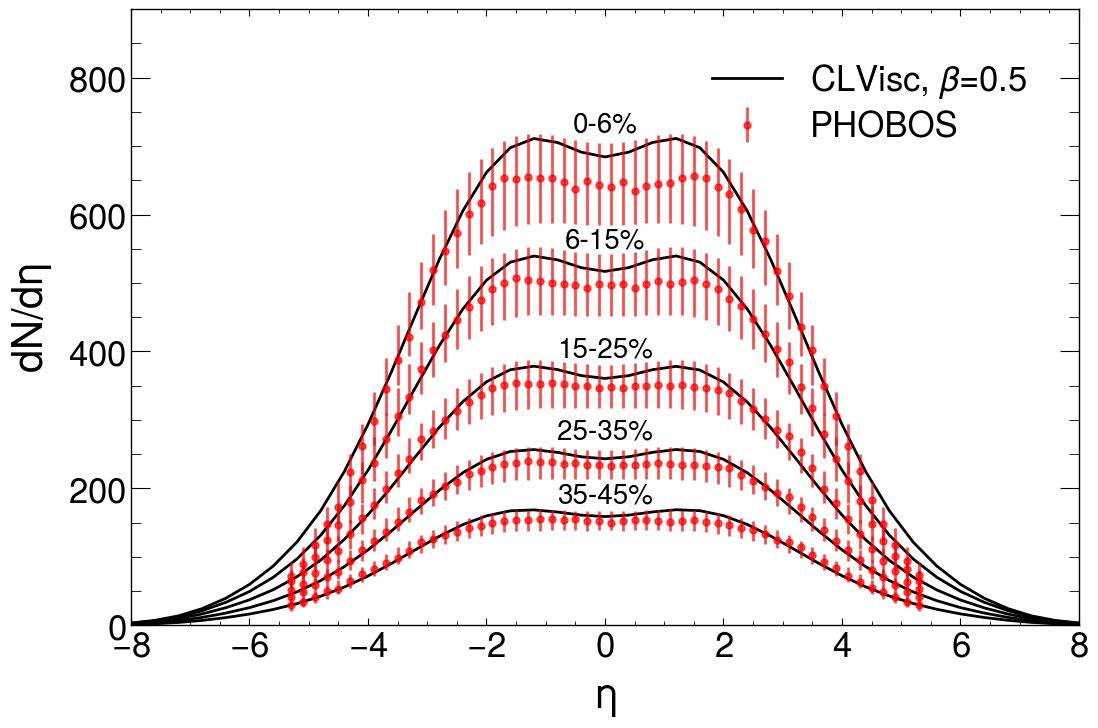

In [69]:
# 使用示例
plot_dNdeta_SMOOTH(cents=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],beta=0.5,
                   para='entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p5_smooth',
                   save_fig=False)

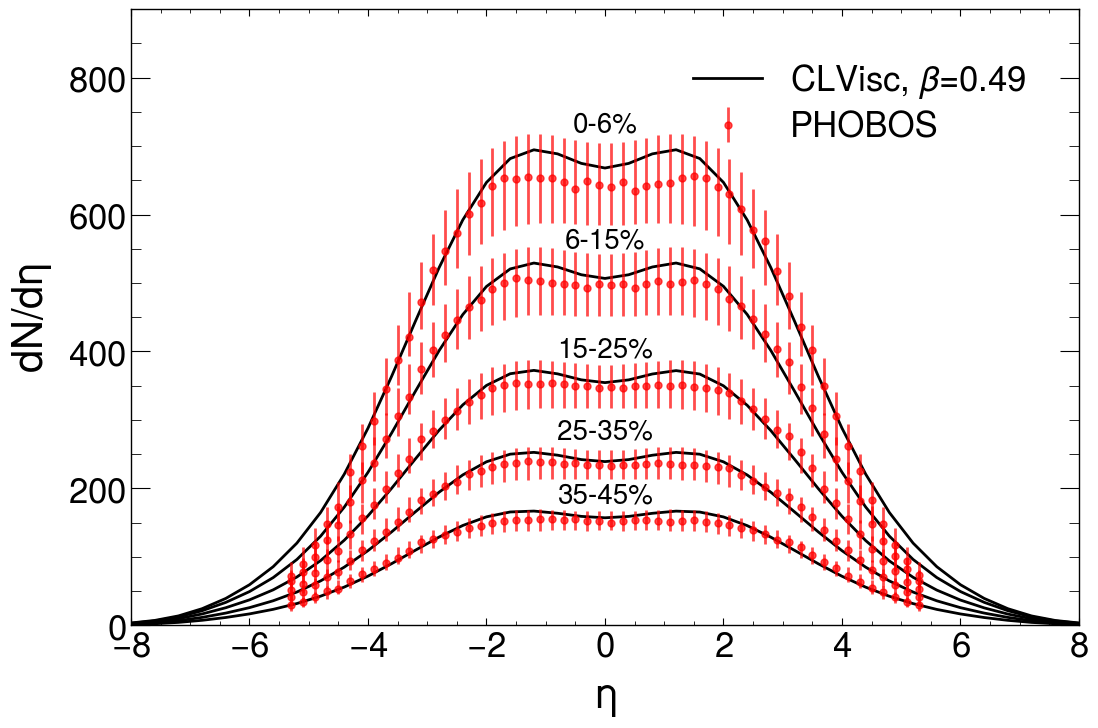

In [70]:
# 使用示例
plot_dNdeta_SMOOTH(cents=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],beta=0.49,
                   para='entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p49_smooth',
                   save_fig=False)

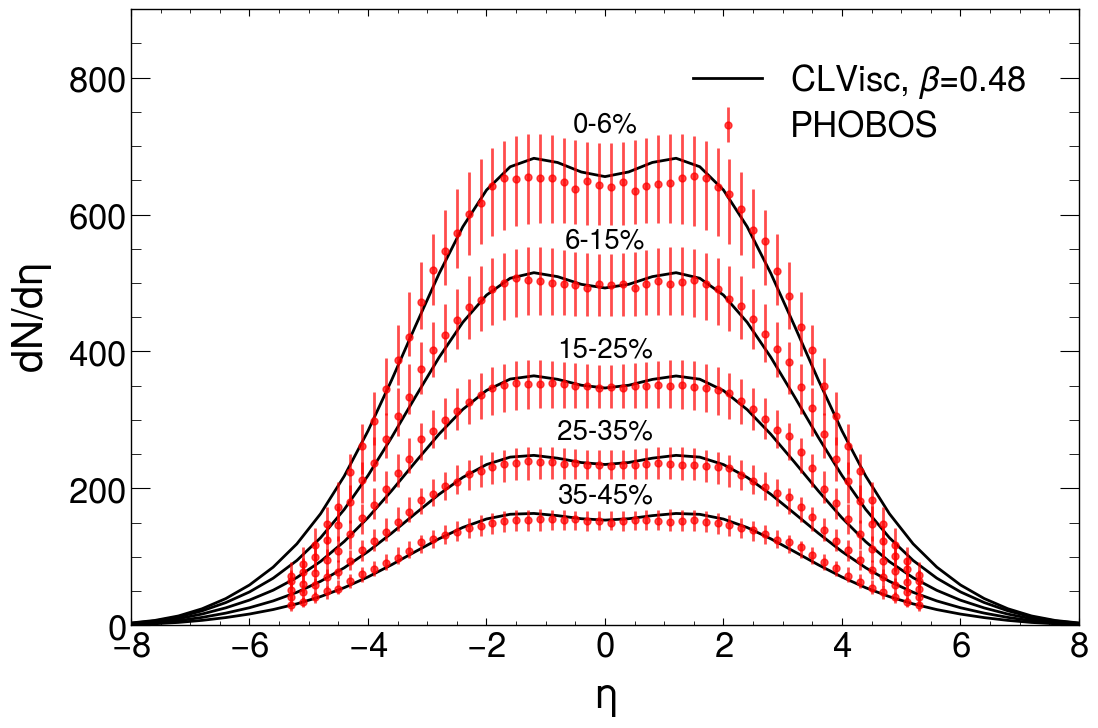

In [71]:
# 使用示例
plot_dNdeta_SMOOTH(cents=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],beta=0.48,
                   para='entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p48_smooth',
                   save_fig=False)

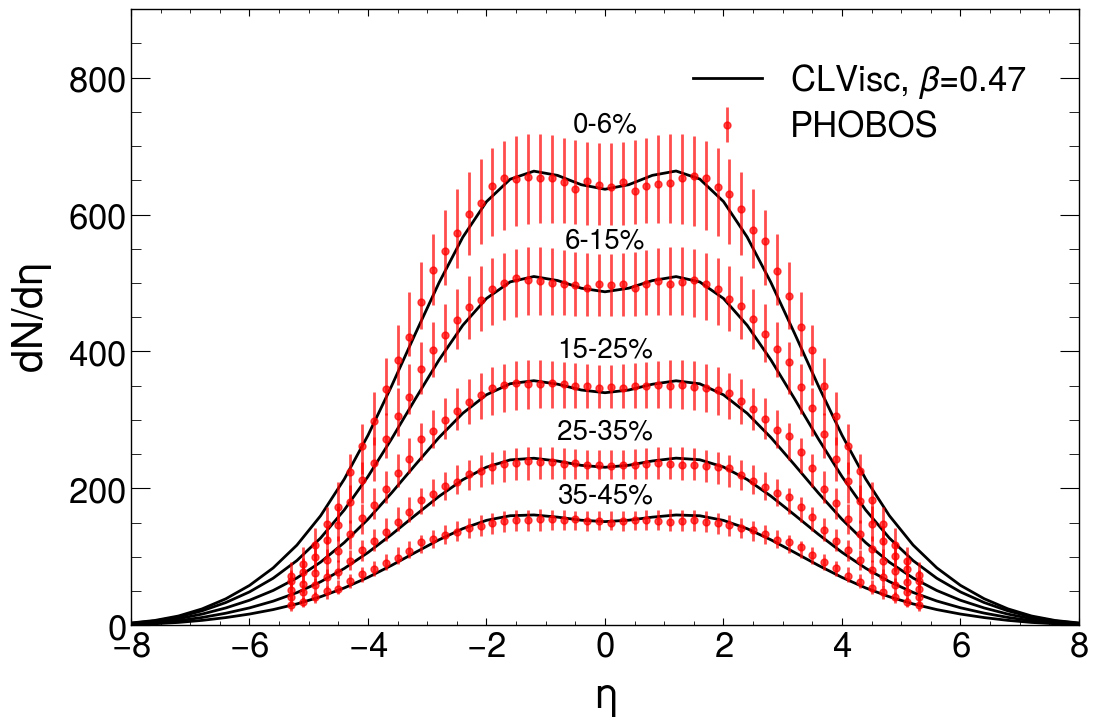

In [72]:
# 使用示例
plot_dNdeta_SMOOTH(cents=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],beta=0.47,
                   para='entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p47_smooth',
                   save_fig=False)

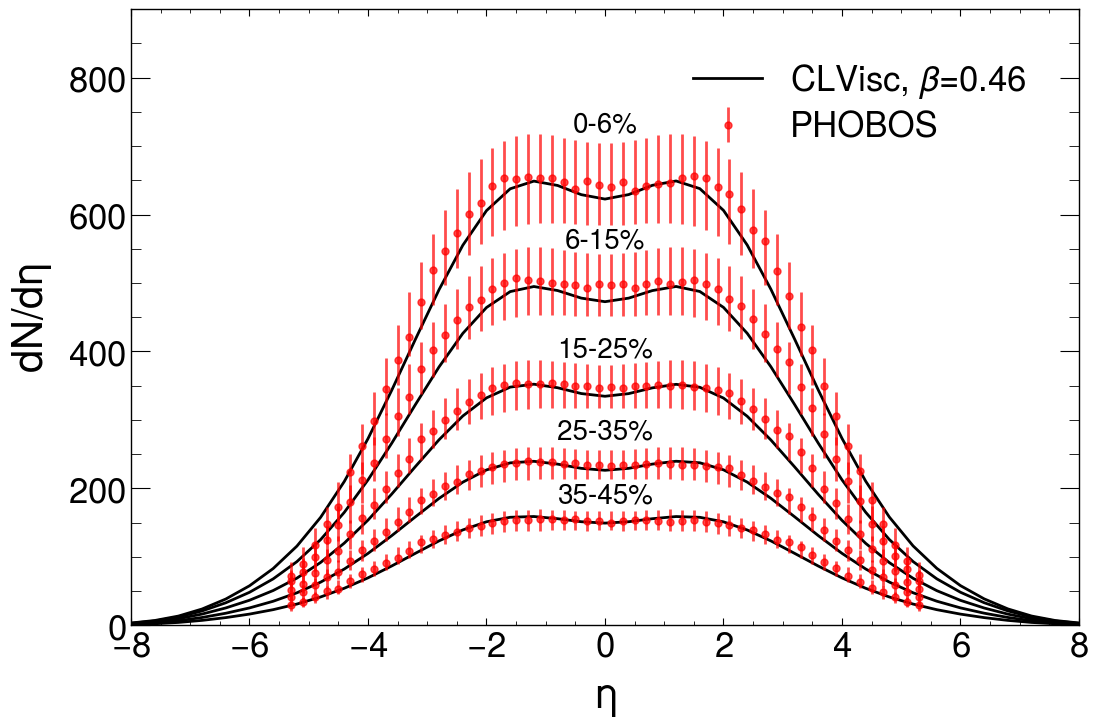

In [73]:
# 使用示例
plot_dNdeta_SMOOTH(cents=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],beta=0.46,
                   para='entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p46_smooth',
                   save_fig=False)

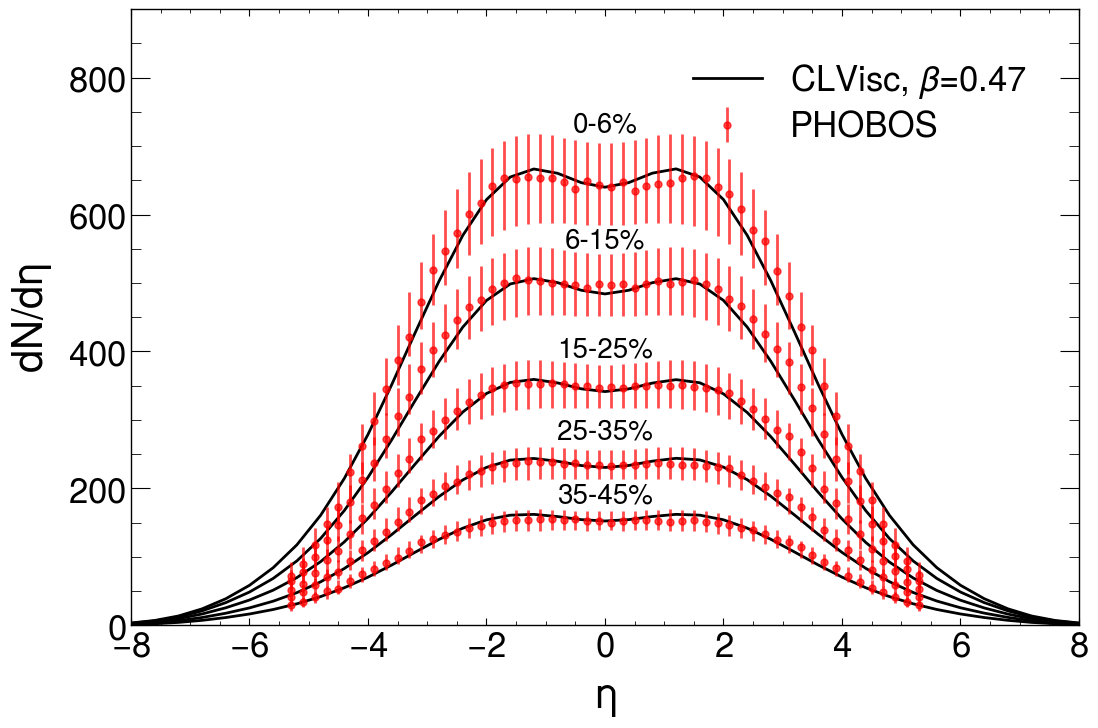

In [66]:
# 使用示例
plot_dNdeta_SMOOTH(cents=[(0, 6), (6, 15), (15, 25), (25, 35), (35, 45)],beta=0.47,
                   para='entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p47_smooth_new_eta_range',
                   save_fig=False)